In [1]:
import numpy as np # linear algebra
import pandas as pd
from xgboost import plot_importance, plot_tree
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10')

# Déclaration des variables

In [3]:
previous_year = 2024 
year = 2025

# MTD_test pour une année c'est le mois jusqu'a lequel in veut tester le modele par exemple pour tester jusqu'en Mars je mets 4 car in code we've < 4

MTD_test = 6


# debut_predict, fin_predict pour une année c'est les mois qui sert a faire les prediction ROLLING par le modele pour voir s'il understand the recent trend

debut_predict, fin_predict = 6, 13

# VISHAY_LAG


In [5]:
df = pd.read_excel(r'C:\Users\rtekem\OneDrive - Vishay Intertechnology, Inc\Desktop\Machine_Learning_project\IMPUT\Sales forecasting by product line and region\DF_vishay.xlsx')

df.head()

C:\Users\rtekem\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Period   REGION  Actual  Blg T-3  Blg T-2       Blg T-1  Blg Total Qty  \
0  201801  AMERICA    16.5      0.0      0.0  0.000000e+00         200223   
1  201801     ASIA    16.5      0.0      0.0  0.000000e+00         277819   
2  201801   EUROPE    16.5      0.0      0.0  0.000000e+00        4679501   
3  201802  AMERICA    20.0      0.0      0.0  1.663386e+06         776733   
4  201802     ASIA    20.0      0.0      0.0  6.561576e+05         396443   

    BACKLOG EUR  Billings EURO Mat/Group  
0  9.002369e+05     1127978.40       FP1  
1  4.155529e+05      726426.63       FP1  
2  3.884839e+06     5273907.40       FP1  
3  1.636298e+06     1059817.80       FP1  
4  6.302381e+05      663998.06       FP1

In [6]:
df['Period'] = pd.to_datetime(df['Period'].astype(str), format='%Y%m')

In [7]:
df.tail(3)

Period   REGION  Actual       Blg T-3       Blg T-2       Blg T-1  \
285 2025-12-01  AMERICA    26.0  1.173866e+05  1.709326e+05  3.426315e+05   
286 2025-12-01     ASIA    26.0  4.119240e+05  6.092065e+05  1.655363e+06   
287 2025-12-01   EUROPE    26.0  2.350936e+06  2.763720e+06  3.652395e+06   

     Blg Total Qty   BACKLOG EUR  Billings EURO Mat/Group  
285          56580  8.572678e+05            0.0       FP4  
286        8361895  1.785945e+06            0.0       FP2  
287         449730  3.977090e+06            0.0       FP1

In [8]:
df.shape

(288, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Period         288 non-null    datetime64[ns]
 1   REGION         288 non-null    object        
 2   Actual         288 non-null    float64       
 3   Blg T-3        288 non-null    float64       
 4   Blg T-2        288 non-null    float64       
 5   Blg T-1        288 non-null    float64       
 6   Blg Total Qty  288 non-null    int64         
 7   BACKLOG EUR    288 non-null    float64       
 8   Billings EURO  288 non-null    float64       
 9   Mat/Group      288 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 22.6+ KB


In [10]:
df.columns.values

array(['Period', 'REGION', 'Actual', 'Blg T-3', 'Blg T-2', 'Blg T-1',
       'Blg Total Qty', 'BACKLOG EUR', 'Billings EURO', 'Mat/Group'],
      dtype=object)

In [11]:
df.dtypes

Period           datetime64[ns]
REGION                   object
Actual                  float64
Blg T-3                 float64
Blg T-2                 float64
Blg T-1                 float64
Blg Total Qty             int64
BACKLOG EUR             float64
Billings EURO           float64
Mat/Group                object
dtype: object

In [12]:
df.isnull().sum()

Period           0
REGION           0
Actual           0
Blg T-3          0
Blg T-2          0
Blg T-1          0
Blg Total Qty    0
BACKLOG EUR      0
Billings EURO    0
Mat/Group        0
dtype: int64

In [13]:
df.dtypes.value_counts()

float64           6
object            2
datetime64[ns]    1
int64             1
Name: count, dtype: int64

<Axes: ylabel='count'>

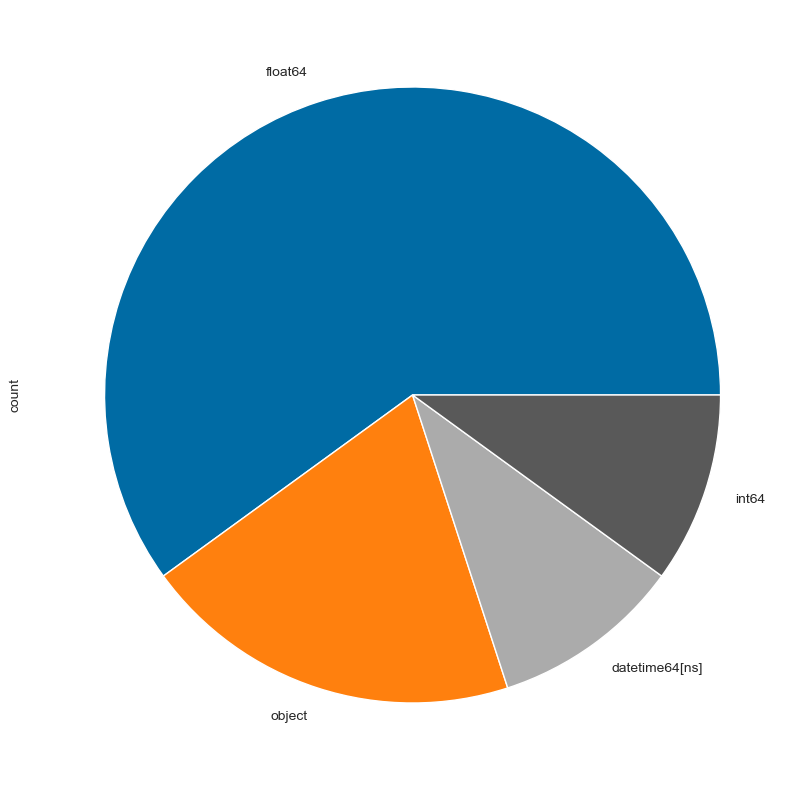

In [14]:
df.dtypes.value_counts().plot.pie()

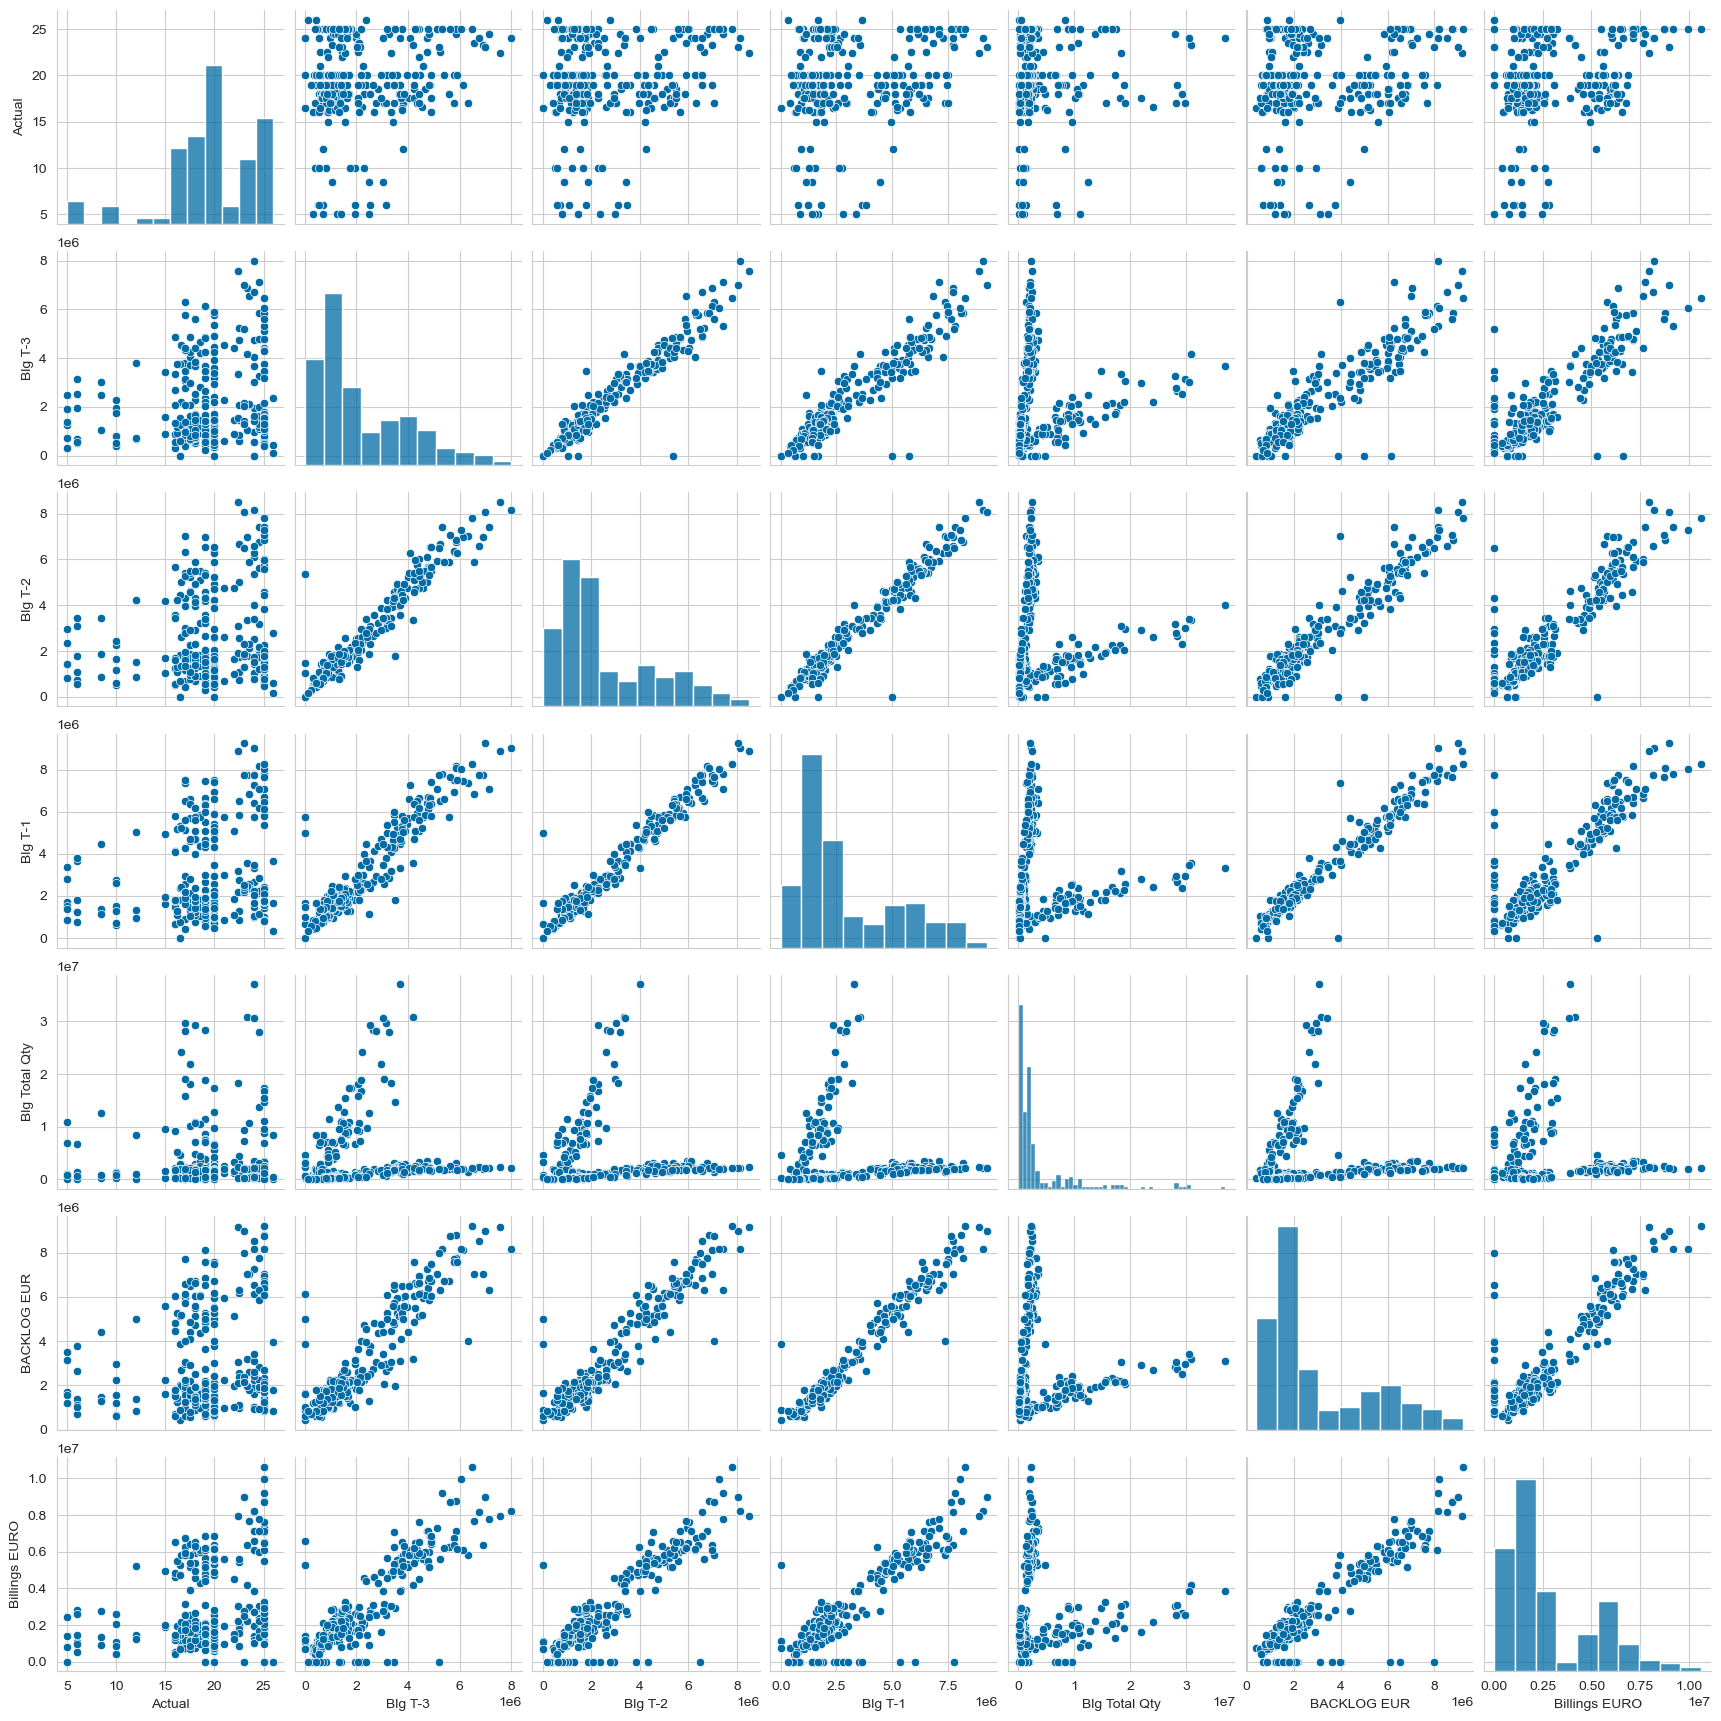

In [15]:
sns.pairplot(df)

<Axes: xlabel='Period'>

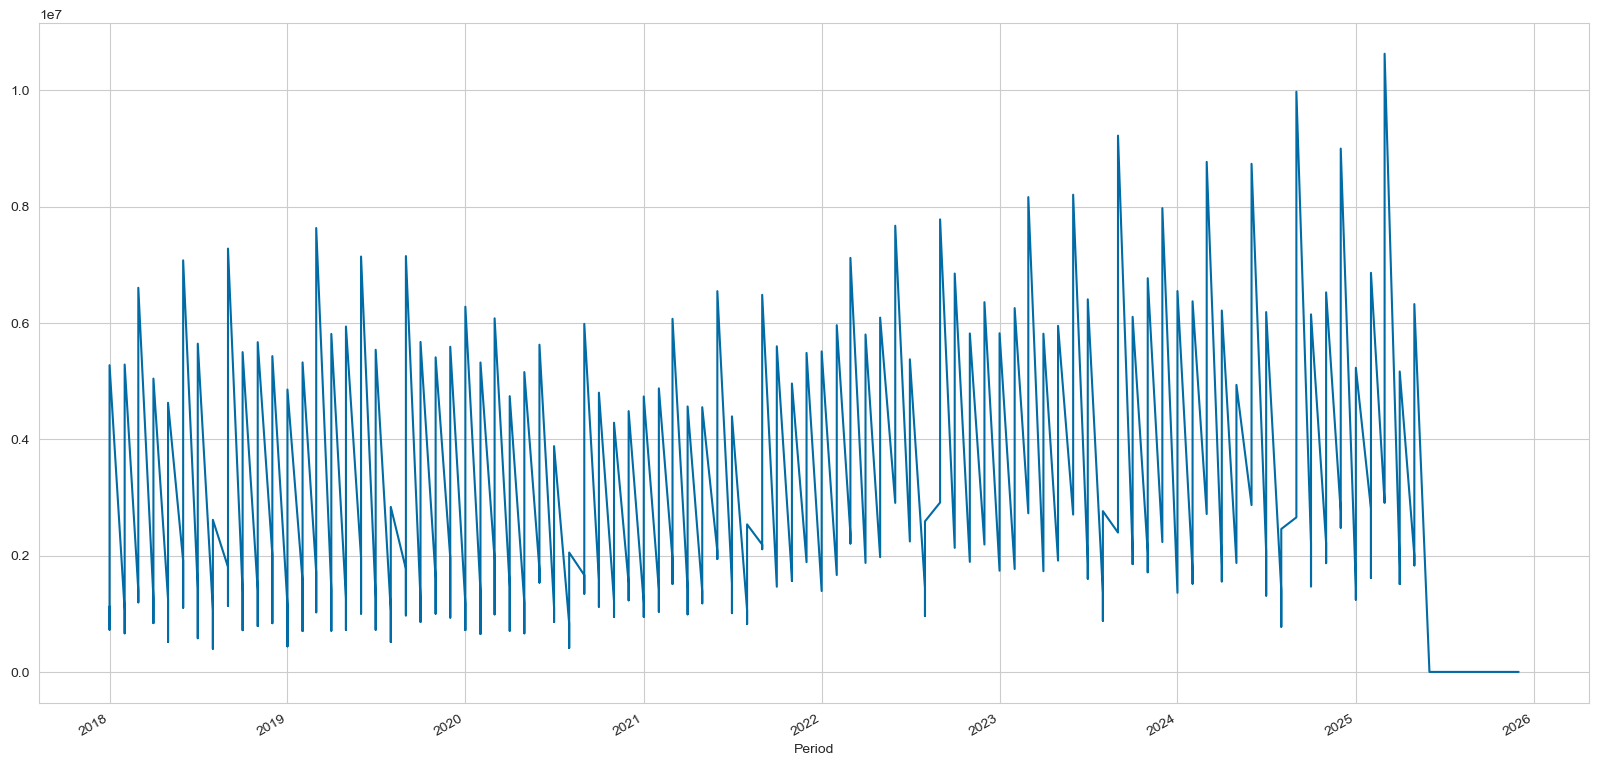

In [16]:
df.set_index('Period')['Billings EURO'].plot()

array([<Axes: xlabel='Period'>, <Axes: xlabel='Period'>,
       <Axes: xlabel='Period'>], dtype=object)

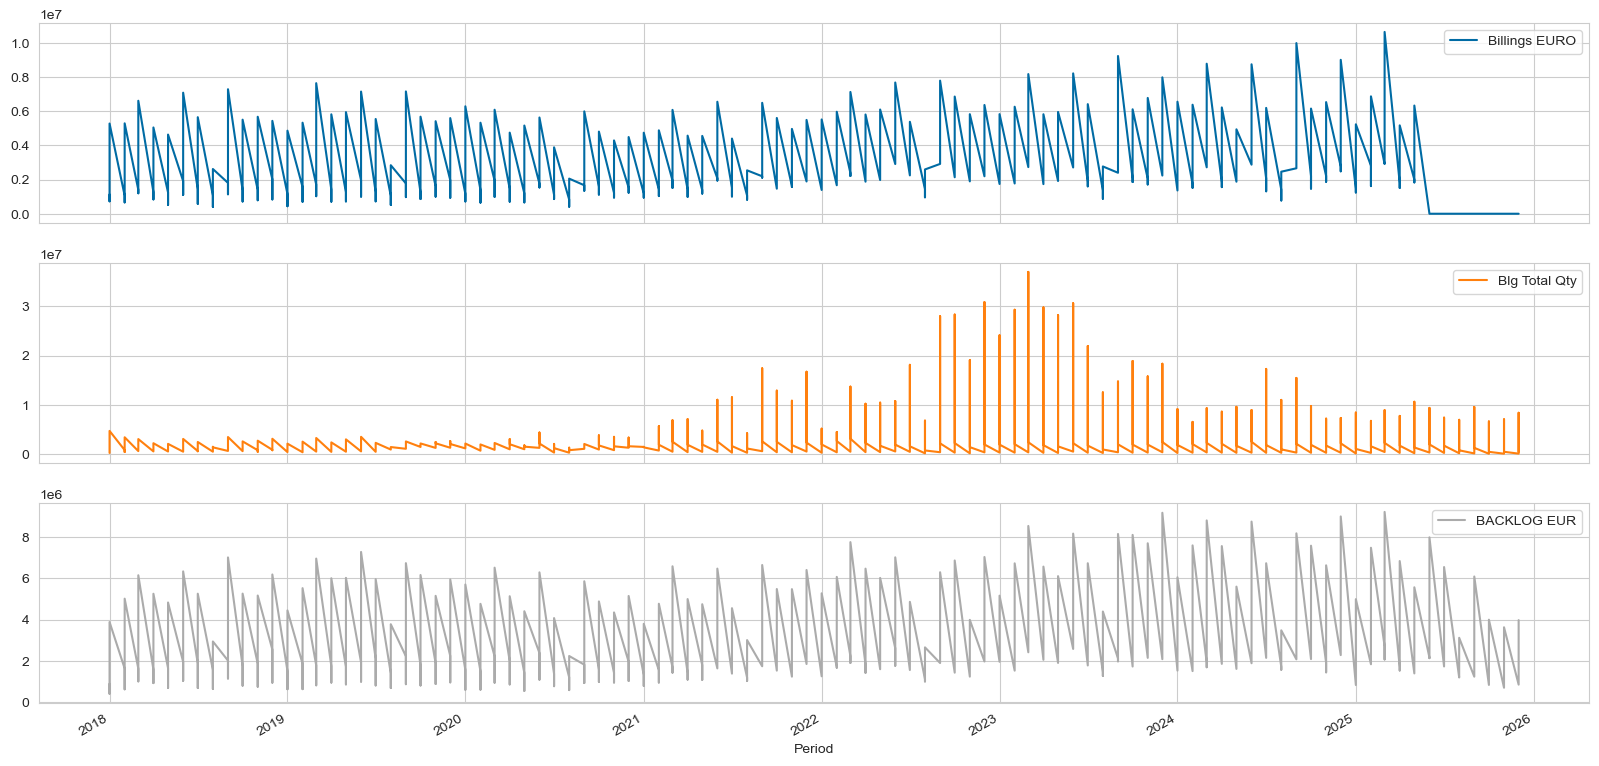

In [17]:
df.set_index('Period')[['Billings EURO','Blg Total Qty','BACKLOG EUR']].plot(subplots=True)

### Pre-processing

In [19]:
df.head(12)

Period   REGION  Actual       Blg T-3       Blg T-2       Blg T-1  \
0  2018-01-01  AMERICA    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
1  2018-01-01     ASIA    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
2  2018-01-01   EUROPE    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
3  2018-02-01  AMERICA    20.0  0.000000e+00  0.000000e+00  1.663386e+06   
4  2018-02-01     ASIA    20.0  0.000000e+00  0.000000e+00  6.561576e+05   
5  2018-02-01   EUROPE    20.0  0.000000e+00  0.000000e+00  4.975812e+06   
6  2018-03-01  AMERICA    24.0  0.000000e+00  1.464672e+06  1.479903e+06   
7  2018-03-01     ASIA    24.0  0.000000e+00  1.026570e+06  1.018436e+06   
8  2018-03-01   EUROPE    24.0  0.000000e+00  5.361207e+06  5.732376e+06   
9  2018-04-01  AMERICA    19.0  1.043593e+06  1.066547e+06  1.483390e+06   
10 2018-04-01     ASIA    19.0  7.041474e+05  7.057524e+05  8.523218e+05   
11 2018-04-01   EUROPE    19.0  3.689241e+06  3.581141e+06  4.466920e+06   

    Blg Total Qty   BACKLOG EUR  Billings EURO Mat/Group  
0          200223  9.002369e+05     1127978.40       FP1  
1          277819  4.155529e+05      726426.63       FP1  
2         4679501  3.884839e+06     5273907.40       FP1  
3          776733  1.636298e+06     1059817.80       FP1  
4          396443  6.302381e+05      663998.06       FP1  
5         3382363  5.015252e+06     5285160.31       FP1  
6          574619  1.628475e+06     1402030.11       FP1  
7         2288800  1.014246e+06     1196682.67       FP1  
8         3017933  6.147889e+06     6604852.14       FP1  
9          509805  1.585139e+06     1267848.04       FP1  
10        1115703  9.304594e+05      839132.38       FP1  
11        2175285  5.252894e+06     5043298.00       FP1

In [20]:
df['quarter'] = df['Period'].dt.quarter
df['month'] = df['Period'].dt.month
df['year'] = df['Period'].dt.year

df['log_Backlog'] = np.log1p(df['BACKLOG EUR'])
df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

In [21]:
#df=df.drop(['Period','Mat/Group'],axis=1)
#df=df.drop(['Period','Blg T-3','Mat/Group'],axis=1)

In [22]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Initialisation de l'encodeur avec sparse_output=False
encoder = OneHotEncoder(sparse_output=False)

# Encodage de la colonne REGION
encoded_array = encoder.fit_transform(df[['REGION']])

# Récupération des noms de colonnes générés
column_names = encoder.get_feature_names_out(['REGION'])

# ✅ Vérification du format de sortie
print(f"Shape of encoded array: {encoded_array.shape}")  # Doit être (180, 3)
print(f"Feature names: {column_names}")  # Doit être ['REGION_AP', 'REGION_EU', 'REGION_NA']

# ✅ Convertir correctement en DataFrame
df_encoded = pd.DataFrame(encoded_array, columns=column_names, index=df.index)

# ✅ Fusion avec df sans REGION
df = df.drop(columns=['REGION']).join(df_encoded)

Shape of encoded array: (288, 3)
Feature names: ['REGION_AMERICA' 'REGION_ASIA' 'REGION_EUROPE']


In [23]:
df.head()

Period  Actual  Blg T-3  Blg T-2       Blg T-1  Blg Total Qty  \
0 2018-01-01    16.5      0.0      0.0  0.000000e+00         200223   
1 2018-01-01    16.5      0.0      0.0  0.000000e+00         277819   
2 2018-01-01    16.5      0.0      0.0  0.000000e+00        4679501   
3 2018-02-01    20.0      0.0      0.0  1.663386e+06         776733   
4 2018-02-01    20.0      0.0      0.0  6.561576e+05         396443   

    BACKLOG EUR  Billings EURO Mat/Group  quarter  month  year  log_Backlog  \
0  9.002369e+05     1127978.40       FP1        1      1  2018    13.710414   
1  4.155529e+05      726426.63       FP1        1      1  2018    12.937368   
2  3.884839e+06     5273907.40       FP1        1      1  2018    15.172592   
3  1.636298e+06     1059817.80       FP1        1      2  2018    14.307948   
4  6.302381e+05      663998.06       FP1        1      2  2018    13.353855   

   quarter_sin   quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
0          1.0  6.123234e-17             1.0          0.0            0.0  
1          1.0  6.123234e-17             0.0          1.0            0.0  
2          1.0  6.123234e-17             0.0          0.0            1.0  
3          1.0  6.123234e-17             1.0          0.0            0.0  
4          1.0  6.123234e-17             0.0          1.0            0.0

In [24]:


# Liste des colonnes one-hot pour les régions
region_cols = ['REGION_AMERICA', 'REGION_ASIA', 'REGION_EUROPE']

# Initialisation des colonnes à NaN
df['rolling_mean_sales_3'] = pd.NA
for lag in range(1, 4):
    df[f'sales_diff_t-{lag}'] = pd.NA

# Pour chaque colonne région (encodée)
for region_col in region_cols:
    # On filtre uniquement les lignes où la région est active (1)
    region_mask = df[region_col] == 1

    # Index des lignes concernées
    region_indices = df[region_mask].index

    # On extrait uniquement les lignes concernées, et on les trie par date
    df_region = df.loc[region_indices].sort_values(by='Period')

    # Moyenne mobile avec shift (exclut la valeur courante)
    rolling_mean = df_region['Billings EURO'].shift(1).rolling(window=3).mean()

    # Ajout dans le dataframe d'origine
    df.loc[region_indices, 'rolling_mean_sales_3'] = rolling_mean

    # Ajout des sales_diff_t-1, t-2, t-3
    for lag in range(1, 4):
        diff_series = df_region['Billings EURO'].diff(lag)
        df.loc[region_indices, f'sales_diff_t-{lag}'] = diff_series


In [25]:
df.head(20)

Period  Actual       Blg T-3       Blg T-2       Blg T-1  \
0  2018-01-01    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
1  2018-01-01    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
2  2018-01-01    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
3  2018-02-01    20.0  0.000000e+00  0.000000e+00  1.663386e+06   
4  2018-02-01    20.0  0.000000e+00  0.000000e+00  6.561576e+05   
5  2018-02-01    20.0  0.000000e+00  0.000000e+00  4.975812e+06   
6  2018-03-01    24.0  0.000000e+00  1.464672e+06  1.479903e+06   
7  2018-03-01    24.0  0.000000e+00  1.026570e+06  1.018436e+06   
8  2018-03-01    24.0  0.000000e+00  5.361207e+06  5.732376e+06   
9  2018-04-01    19.0  1.043593e+06  1.066547e+06  1.483390e+06   
10 2018-04-01    19.0  7.041474e+05  7.057524e+05  8.523218e+05   
11 2018-04-01    19.0  3.689241e+06  3.581141e+06  4.466920e+06   
12 2018-05-01    16.0  8.421211e+05  1.224620e+06  1.589071e+06   
13 2018-05-01    16.0  3.128158e+05  5.031267e+05  6.631210e+05   
14 2018-05-01    16.0  2.671984e+06  3.585974e+06  4.140908e+06   
15 2018-06-01    25.0  1.088336e+06  1.479550e+06  1.840204e+06   
16 2018-06-01    25.0  4.784502e+05  7.402197e+05  9.427519e+05   
17 2018-06-01    25.0  3.449749e+06  4.556749e+06  5.832996e+06   
18 2018-07-01    20.0  7.823703e+05  1.472550e+06  1.720959e+06   
19 2018-07-01    20.0  3.462145e+05  4.561827e+05  6.020942e+05   

    Blg Total Qty   BACKLOG EUR  Billings EURO Mat/Group  quarter  ...  \
0          200223  9.002369e+05     1127978.40       FP1        1  ...   
1          277819  4.155529e+05      726426.63       FP1        1  ...   
2         4679501  3.884839e+06     5273907.40       FP1        1  ...   
3          776733  1.636298e+06     1059817.80       FP1        1  ...   
4          396443  6.302381e+05      663998.06       FP1        1  ...   
5         3382363  5.015252e+06     5285160.31       FP1        1  ...   
6          574619  1.628475e+06     1402030.11       FP1        1  ...   
7         2288800  1.014246e+06     1196682.67       FP1        1  ...   
8         3017933  6.147889e+06     6604852.14       FP1        1  ...   
9          509805  1.585139e+06     1267848.04       FP1        2  ...   
10        1115703  9.304594e+05      839132.38       FP1        2  ...   
11        2175285  5.252894e+06     5043298.00       FP1        2  ...   
12         493340  1.656894e+06     1248940.53       FP1        2  ...   
13        1029474  6.955586e+05      518287.11       FP1        2  ...   
14        2043774  4.830055e+06     4627548.96       FP1        2  ...   
15         456476  1.955739e+06     1909011.55       FP1        2  ...   
16        1788508  1.041237e+06     1104324.16       FP1        2  ...   
17        3048786  6.335294e+06     7076516.37       FP1        2  ...   
18         582187  1.878122e+06     1430288.49       FP1        3  ...   
19         539297  6.938062e+05      579439.92       FP1        3  ...   

    log_Backlog   quarter_sin   quarter_cos  REGION_AMERICA  REGION_ASIA  \
0     13.710414  1.000000e+00  6.123234e-17             1.0          0.0   
1     12.937368  1.000000e+00  6.123234e-17             0.0          1.0   
2     15.172592  1.000000e+00  6.123234e-17             0.0          0.0   
3     14.307948  1.000000e+00  6.123234e-17             1.0          0.0   
4     13.353855  1.000000e+00  6.123234e-17             0.0          1.0   
5     15.427994  1.000000e+00  6.123234e-17             0.0          0.0   
6     14.303155  1.000000e+00  6.123234e-17             1.0          0.0   
7     13.829657  1.000000e+00  6.123234e-17             0.0          1.0   
8     15.631620  1.000000e+00  6.123234e-17             0.0          0.0   
9     14.276183  1.224647e-16 -1.000000e+00             1.0          0.0   
10    13.743435  1.224647e-16 -1.000000e+00             0.0          1.0   
11    15.474290  1.224647e-16 -1.000000e+00             0.0          0.0   
12    14.320456  1.224647e-16 -1.000000e+00             

In [26]:
# Liste des dates à exclure
dates_to_drop = pd.to_datetime(['2018-01-01', '2018-02-01', '2018-03-01'])

# On filtre les lignes à garder (donc celles dont Period n'est pas dans dates_to_drop)
df = df[~df['Period'].isin(dates_to_drop)]


df=df.drop(['Period','Mat/Group'],axis=1)
#df=df.drop(['Period','Blg T-3','Mat/Group'],axis=1)



In [27]:
df.head(9)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
9     19.0  1.043593e+06  1.066547e+06  1.483390e+06         509805   
10    19.0  7.041474e+05  7.057524e+05  8.523218e+05        1115703   
11    19.0  3.689241e+06  3.581141e+06  4.466920e+06        2175285   
12    16.0  8.421211e+05  1.224620e+06  1.589071e+06         493340   
13    16.0  3.128158e+05  5.031267e+05  6.631210e+05        1029474   
14    16.0  2.671984e+06  3.585974e+06  4.140908e+06        2043774   
15    25.0  1.088336e+06  1.479550e+06  1.840204e+06         456476   
16    25.0  4.784502e+05  7.402197e+05  9.427519e+05        1788508   
17    25.0  3.449749e+06  4.556749e+06  5.832996e+06        3048786   

     BACKLOG EUR  Billings EURO  quarter  month  year  log_Backlog  \
9   1.585139e+06     1267848.04        2      4  2018    14.276183   
10  9.304594e+05      839132.38        2      4  2018    13.743435   
11  5.252894e+06     5043298.00        2      4  2018    15.474290   
12  1.656894e+06     1248940.53        2      5  2018    14.320456   
13  6.955586e+05      518287.11        2      5  2018    13.452472   
14  4.830055e+06     4627548.96        2      5  2018    15.390369   
15  1.955739e+06     1909011.55        2      6  2018    14.486279   
16  1.041237e+06     1104324.16        2      6  2018    13.855921   
17  6.335294e+06     7076516.37        2      6  2018    15.661647   

     quarter_sin  quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
9   1.224647e-16         -1.0             1.0          0.0            0.0   
10  1.224647e-16         -1.0             0.0          1.0            0.0   
11  1.224647e-16         -1.0             0.0          0.0            1.0   
12  1.224647e-16         -1.0             1.0          0.0            0.0   
13  1.224647e-16         -1.0             0.0          1.0            0.0   
14  1.224647e-16         -1.0             0.0          0.0            1.0   
15  1.224647e-16         -1.0             1.0          0.0            0.0   
16  1.224647e-16         -1.0             0.0          1.0            0.0   
17  1.224647e-16         -1.0             0.0          0.0            1.0   

   rolling_mean_sales_3 sales_diff_t-1 sales_diff_t-2 sales_diff_t-3  
9            1196608.77     -134182.07      208030.24      139869.64  
10            862369.12     -357550.29      175134.32      112705.75  
11       5721306.616667    -1561554.14     -241862.31      -230609.4  
12       1243231.983333      -18907.51     -153089.58      189122.73  
13        899937.703333     -320845.27     -678395.56     -145710.95  
14       5644436.816667     -415749.04    -1977303.18     -657611.35  
15       1306272.893333      660071.02      641163.51      506981.44  
16        851367.386667      586037.05      265191.78      -92358.51  
17       5425233.033333     2448967.41     2033218.37      471664.23

In [28]:
# Identifier les colonnes de type object
object_cols = df.select_dtypes(include='object').columns

# Les convertir en float64
df[object_cols] = df[object_cols].apply(pd.to_numeric, errors='coerce').astype('float64')

In [29]:
df.dtypes

Actual                  float64
Blg T-3                 float64
Blg T-2                 float64
Blg T-1                 float64
Blg Total Qty             int64
BACKLOG EUR             float64
Billings EURO           float64
quarter                   int32
month                     int32
year                      int32
log_Backlog             float64
quarter_sin             float64
quarter_cos             float64
REGION_AMERICA          float64
REGION_ASIA             float64
REGION_EUROPE           float64
rolling_mean_sales_3    float64
sales_diff_t-1          float64
sales_diff_t-2          float64
sales_diff_t-3          float64
dtype: object

#### To change

In [31]:
df_train=df[df['year'] < previous_year]
X_train=df_train.drop(['Billings EURO'],axis=1)
y_train=df_train['Billings EURO']

In [32]:
df_test = df[((df['year'] == previous_year)) | ((df['year'] == year) & (df['month'] < MTD_test))]

X_test=df_test.drop(['Billings EURO'],axis=1)
y_test=df_test['Billings EURO']

In [33]:
df_test.shape

(51, 20)

In [34]:
df_test.head(5)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
216    16.0  1.327916e+06  1.685202e+06  1.743102e+06         191565   
217    16.0  2.085319e+06  1.597469e+06  1.825497e+06        9105058   
218    16.0  4.881041e+06  5.660553e+06  5.777857e+06        1828236   
219    20.0  1.270276e+06  1.188518e+06  1.526136e+06         247733   
220    20.0  1.570154e+06  1.551265e+06  1.545120e+06        6510518   

      BACKLOG EUR  Billings EURO  quarter  month  year  log_Backlog  \
216  1.535350e+06     1360570.66        1      1  2024    14.244269   
217  1.771613e+06     1459936.67        1      1  2024    14.387402   
218  6.050074e+06     6548783.75        1      1  2024    15.615581   
219  1.532167e+06     1735804.69        1      2  2024    14.242194   
220  1.511414e+06     1517802.60        1      2  2024    14.228557   

     quarter_sin   quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
216          1.0  6.123234e-17             1.0          0.0            0.0   
217          1.0  6.123234e-17             0.0          1.0            0.0   
218          1.0  6.123234e-17             0.0          0.0            1.0   
219          1.0  6.123234e-17             1.0          0.0            0.0   
220          1.0  6.123234e-17             0.0          1.0            0.0   

     rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  
216          2.112110e+06      -872388.98      -688289.96      -693940.35  
217          2.203172e+06     -1581411.04      -253955.54      -394339.24  
218          6.949760e+06     -1425686.41      -220644.36       443403.15  
219          1.880797e+06       375234.03      -497154.95      -313055.93  
220          2.071726e+06        57865.93     -1523545.11      -196089.61

In [35]:
df_test.columns

Index(['Actual', 'Blg T-3', 'Blg T-2', 'Blg T-1', 'Blg Total Qty',
       'BACKLOG EUR', 'Billings EURO', 'quarter', 'month', 'year',
       'log_Backlog', 'quarter_sin', 'quarter_cos', 'REGION_AMERICA',
       'REGION_ASIA', 'REGION_EUROPE', 'rolling_mean_sales_3',
       'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3'],
      dtype='object')

In [36]:
from sklearn.preprocessing import StandardScaler

# Sélection des colonnes numériques à standardiser

  # 'Billings EURO' est la cible, donc on ne la touche pas

#numeric_cols = ['Blg T-1','BACKLOG EUR', 'Blg Total Qty']
#numeric_cols = ['Blg T-2','Blg T-1','BACKLOG EUR', 'Blg Total Qty']
#numeric_cols = ['Blg T-3','Blg T-2','Blg T-1','Blg Total Qty', 'BACKLOG EUR','rolling_mean_sales_3',
       #'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']
# Initialisation du scaler
#scaler = StandardScaler()

# Standardisation des données d'entraînement et de test
#X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
#X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [37]:
X_train.shape,X_test.shape

((207, 19), (51, 19))

In [38]:
X_train.head(5)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
9     19.0  1.043593e+06  1.066547e+06  1.483390e+06         509805   
10    19.0  7.041474e+05  7.057524e+05  8.523218e+05        1115703   
11    19.0  3.689241e+06  3.581141e+06  4.466920e+06        2175285   
12    16.0  8.421211e+05  1.224620e+06  1.589071e+06         493340   
13    16.0  3.128158e+05  5.031267e+05  6.631210e+05        1029474   

     BACKLOG EUR  quarter  month  year  log_Backlog   quarter_sin  \
9   1.585139e+06        2      4  2018    14.276183  1.224647e-16   
10  9.304594e+05        2      4  2018    13.743435  1.224647e-16   
11  5.252894e+06        2      4  2018    15.474290  1.224647e-16   
12  1.656894e+06        2      5  2018    14.320456  1.224647e-16   
13  6.955586e+05        2      5  2018    13.452472  1.224647e-16   

    quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
9          -1.0             1.0          0.0            0.0   
10         -1.0             0.0          1.0            0.0   
11         -1.0             0.0          0.0            1.0   
12         -1.0             1.0          0.0            0.0   
13         -1.0             0.0          1.0            0.0   

    rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  
9           1.196609e+06      -134182.07       208030.24       139869.64  
10          8.623691e+05      -357550.29       175134.32       112705.75  
11          5.721307e+06     -1561554.14      -241862.31      -230609.40  
12          1.243232e+06       -18907.51      -153089.58       189122.73  
13          8.999377e+05      -320845.27      -678395.56      -145710.95

In [39]:
X_train.dtypes

Actual                  float64
Blg T-3                 float64
Blg T-2                 float64
Blg T-1                 float64
Blg Total Qty             int64
BACKLOG EUR             float64
quarter                   int32
month                     int32
year                      int32
log_Backlog             float64
quarter_sin             float64
quarter_cos             float64
REGION_AMERICA          float64
REGION_ASIA             float64
REGION_EUROPE           float64
rolling_mean_sales_3    float64
sales_diff_t-1          float64
sales_diff_t-2          float64
sales_diff_t-3          float64
dtype: object

In [40]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)

In [41]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  549827.774710
MAE :  374285.435294


In [42]:
from sklearn.metrics import mean_absolute_error as MAE
import numpy as np

mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 10.29%


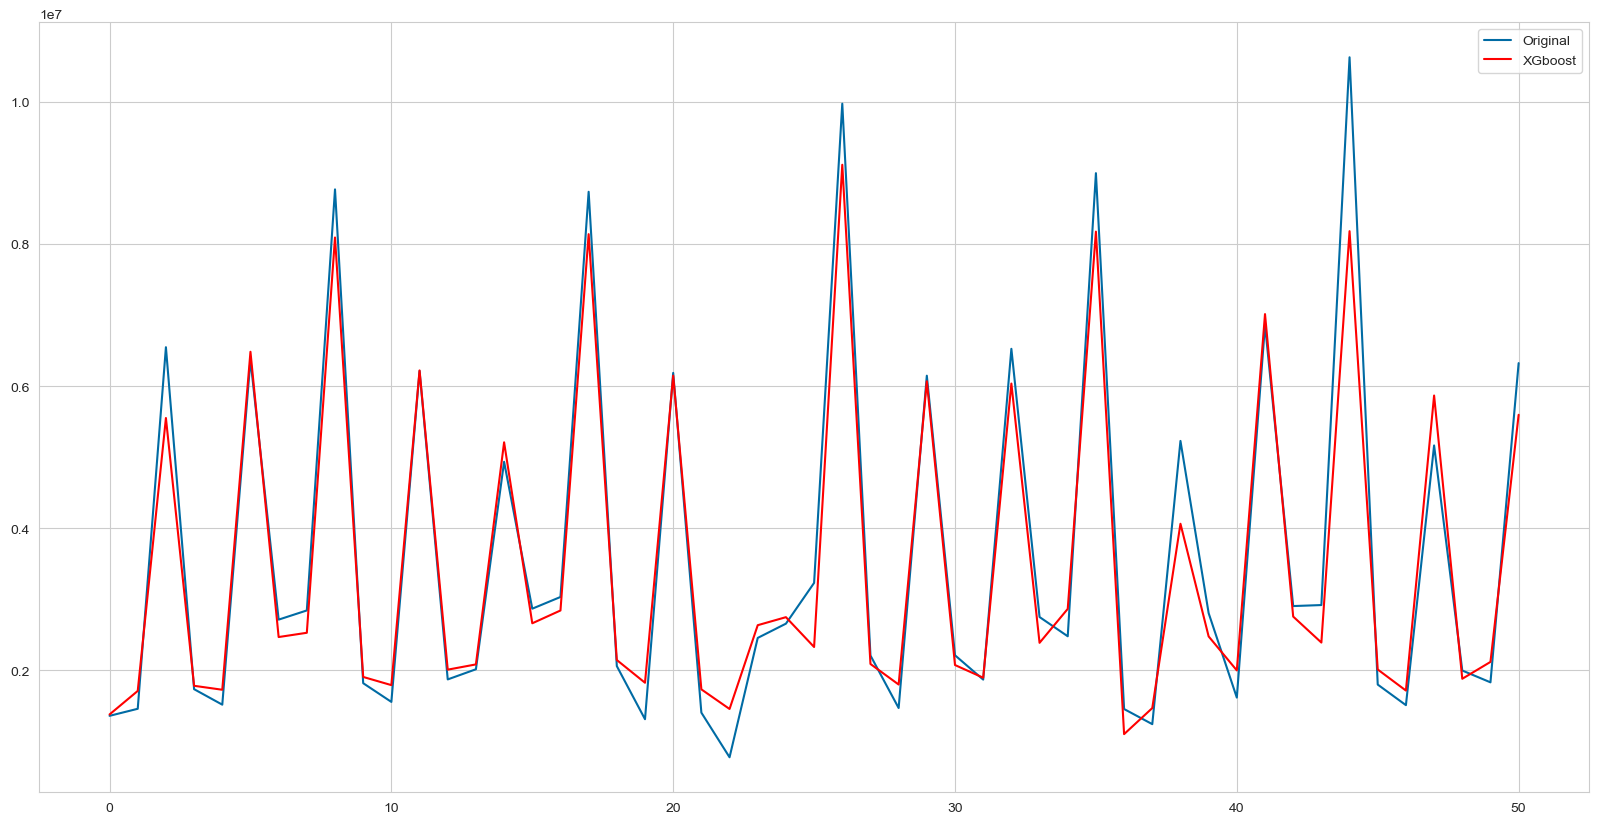

In [43]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [44]:
# Conversion de y_test et yhat en DataFrame avec les mêmes index que X_test
df_results = X_test.copy()  # Copie X_test pour ne pas modifier l'original
df_results["Valeur Réelle"] = y_test.values  # Ajout de y_test
df_results["Prédiction"] = yhat  # Ajout des prédictions

In [45]:
# Affichage des premières lignes
df_results.head()

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
216    16.0  1.327916e+06  1.685202e+06  1.743102e+06         191565   
217    16.0  2.085319e+06  1.597469e+06  1.825497e+06        9105058   
218    16.0  4.881041e+06  5.660553e+06  5.777857e+06        1828236   
219    20.0  1.270276e+06  1.188518e+06  1.526136e+06         247733   
220    20.0  1.570154e+06  1.551265e+06  1.545120e+06        6510518   

      BACKLOG EUR  quarter  month  year  log_Backlog  ...   quarter_cos  \
216  1.535350e+06        1      1  2024    14.244269  ...  6.123234e-17   
217  1.771613e+06        1      1  2024    14.387402  ...  6.123234e-17   
218  6.050074e+06        1      1  2024    15.615581  ...  6.123234e-17   
219  1.532167e+06        1      2  2024    14.242194  ...  6.123234e-17   
220  1.511414e+06        1      2  2024    14.228557  ...  6.123234e-17   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  rolling_mean_sales_3  \
216             1.0          0.0            0.0          2.112110e+06   
217             0.0          1.0            0.0          2.203172e+06   
218             0.0          0.0            1.0          6.949760e+06   
219             1.0          0.0            0.0          1.880797e+06   
220             0.0          1.0            0.0          2.071726e+06   

     sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  Valeur Réelle  \
216      -872388.98      -688289.96      -693940.35     1360570.66   
217     -1581411.04      -253955.54      -394339.24     1459936.67   
218     -1425686.41      -220644.36       443403.15     6548783.75   
219       375234.03      -497154.95      -313055.93     1735804.69   
220        57865.93     -1523545.11      -196089.61     1517802.60   

      Prédiction  
216  1380108.625  
217  1711172.000  
218  5552268.000  
219  1783397.000  
220  1727772.875  

[5 rows x 21 columns]

In [46]:
from sklearn.model_selection import RandomizedSearchCV


# Définition des hyperparamètres avec un plus grand espace de recherche
params = {
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [i / 10.0 for i in range(0, 8)],
    'subsample': [i / 10.0 for i in range(5, 11)],
    'colsample_bytree': [i / 10.0 for i in range(5, 11)],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Ajout du learning rate
    'n_estimators': [100, 500, 1000, 2000]  # Augmentation du nombre d'arbres
}

# Initialisation de XGBoost
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

# RandomizedSearchCV pour un tuning plus rapide
random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, 
                                   n_iter=30, cv=5, verbose=1, n_jobs=-1)

# Entraînement du modèle optimisé
random_search.fit(X_train, y_train)

# Meilleur modèle trouvé
best_xgb = random_search.best_estimator_
print("Meilleur score R2 :", r2_score(y_test, best_xgb.predict(X_test)))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleur score R2 : 0.9693745854397496


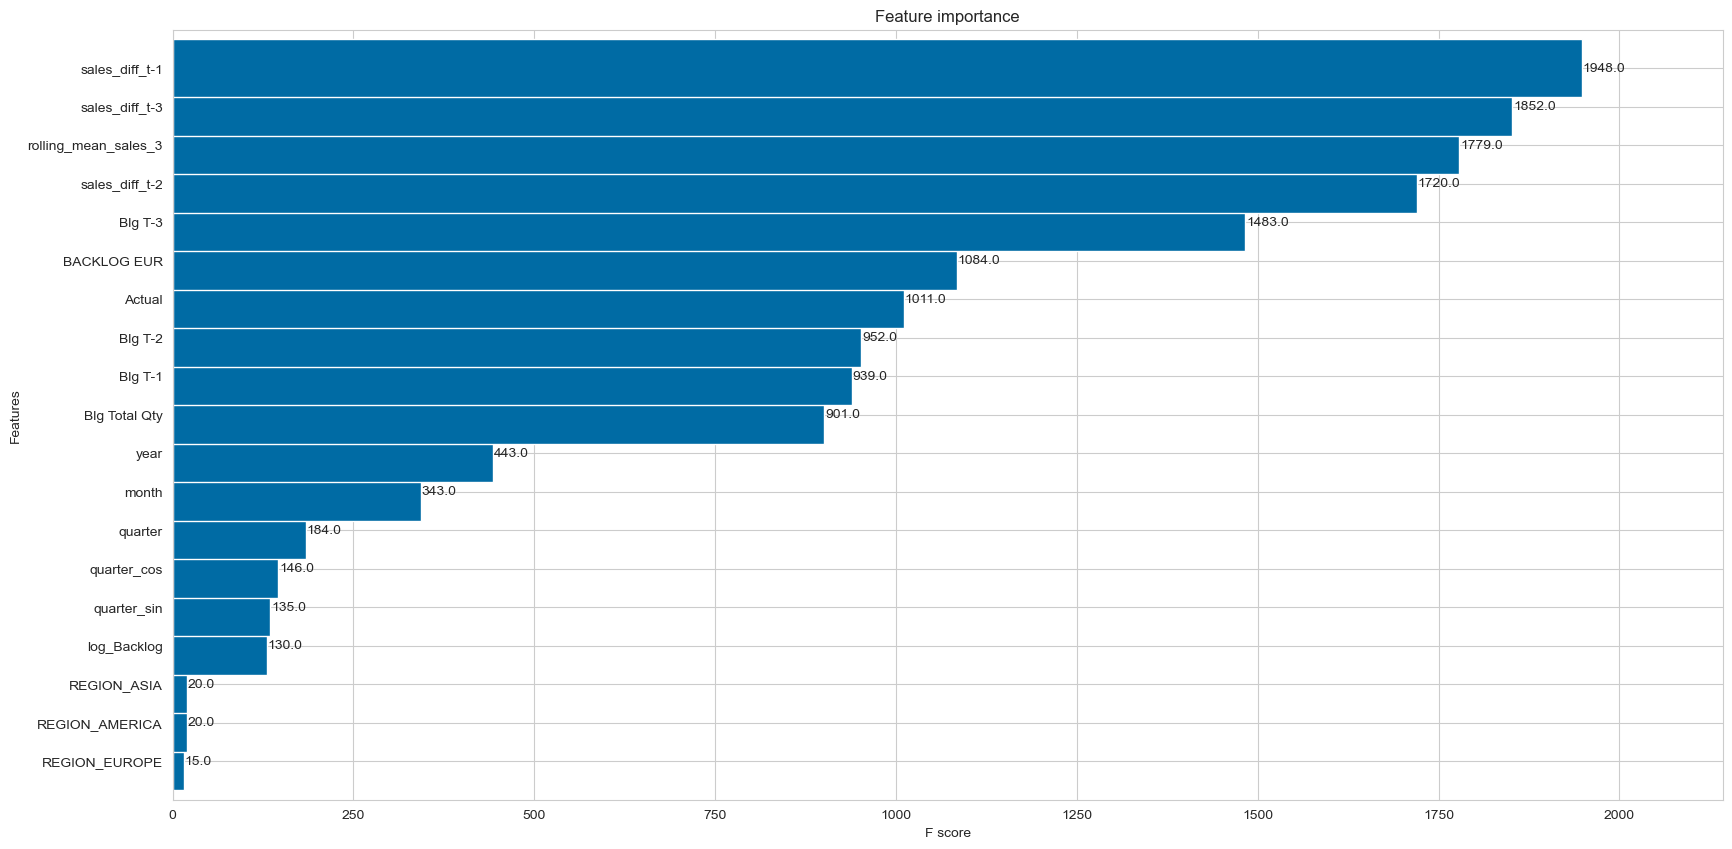

In [47]:
_ = plot_importance(best_xgb, height=1.5)

In [48]:
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [49]:
yhat = random_search.predict(X_test)
rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  451614.337542
MAE :  321089.646324


In [50]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 8.83%


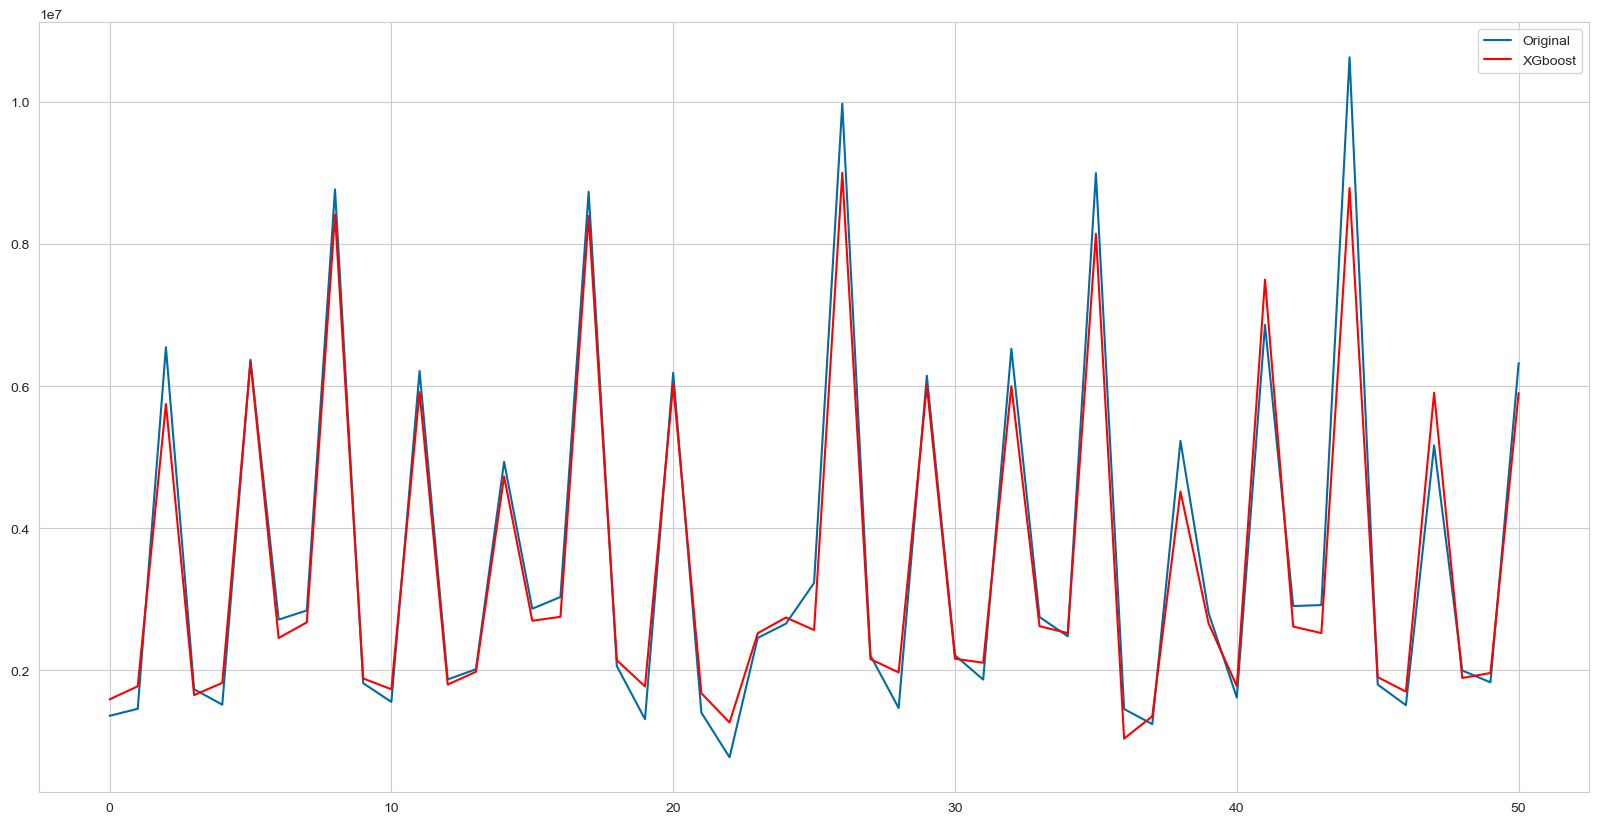

In [51]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

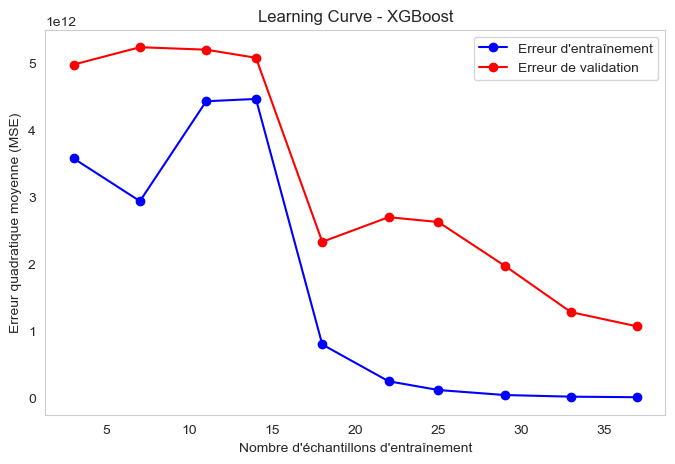

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Définition des splits temporels
tscv = TimeSeriesSplit(n_splits=5)

# Calcul de la learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Conversion en erreurs positives (MSE)
train_errors = -train_scores.mean(axis=1)
val_errors = -val_scores.mean(axis=1)

# Affichage des courbes
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors, "o-", label="Erreur d'entraînement", color="blue")
plt.plot(train_sizes, val_errors, "o-", label="Erreur de validation", color="red")

plt.xlabel("Nombre d'échantillons d'entraînement")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Learning Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()

In [53]:
import optuna
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.model_selection import train_test_split

# Fonction d'optimisation avec Optuna
def objective(trial):
    # Espace de recherche des hyperparamètres
    params = {
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.7, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 500, 1000, 2000]),
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }

    # Initialisation du modèle
    xgb_reg = xgb.XGBRegressor(**params)

    # Entraînement du modèle
    xgb_reg.fit(X_train, y_train)

    # Prédictions sur le test set
    y_pred = xgb_reg.predict(X_test)

    # Calcul du RMSE
    rmse = np.sqrt(MSE(y_test, y_pred))

    return rmse  # On minimise le RMSE

# Lancement de l'optimisation avec Optuna
study = optuna.create_study(direction="minimize")  # Minimiser le RMSE
study.optimize(objective, n_trials=30)

# Meilleurs hyperparamètres trouvés
best_params = study.best_params
print("Meilleurs hyperparamètres :", best_params)

# Reconstruction du meilleur modèle avec les hyperparamètres optimaux
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

# Prédictions finales
yhat = best_xgb.predict(X_test)

[I 2025-06-06 11:07:03,751] A new study created in memory with name: no-name-0a43d0c1-21ed-462f-8e0b-685836bc304a
C:\Users\rtekem\AppData\Local\Temp\ipykernel_19072\951080644.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
[I 2025-06-06 11:07:04,670] Trial 0 finished with value: 429432.0147149801 and parameters: {'min_child_weight': 6, 'gamma': 0.6000000000000001, 'subsample': 0.5, 'colsample_bytree': 0.5, 'max_depth': 5, 'learning_rate': 0.161340917559974, 'n_estimators': 1000}. Best is trial 0 with value: 429432.0147149801.
C:\Users\rtekem\AppData\Local\Temp\ipykernel_19072\951080644.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Meilleurs hyperparamètres : {'min_child_weight': 5, 'gamma': 0.4, 'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 6, 'learning_rate': 0.13147531579300556, 'n_estimators': 2000}


In [54]:
# Évaluation du modèle optimisé
rmse = np.sqrt(MSE(y_test, yhat))
r2 = r2_score(y_test, yhat)

print("Meilleur score R2 :", r2)
print("RMSE : % f" % (rmse))

Meilleur score R2 : 0.9757704651430106
RMSE :  401697.631921


In [55]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 8.36%


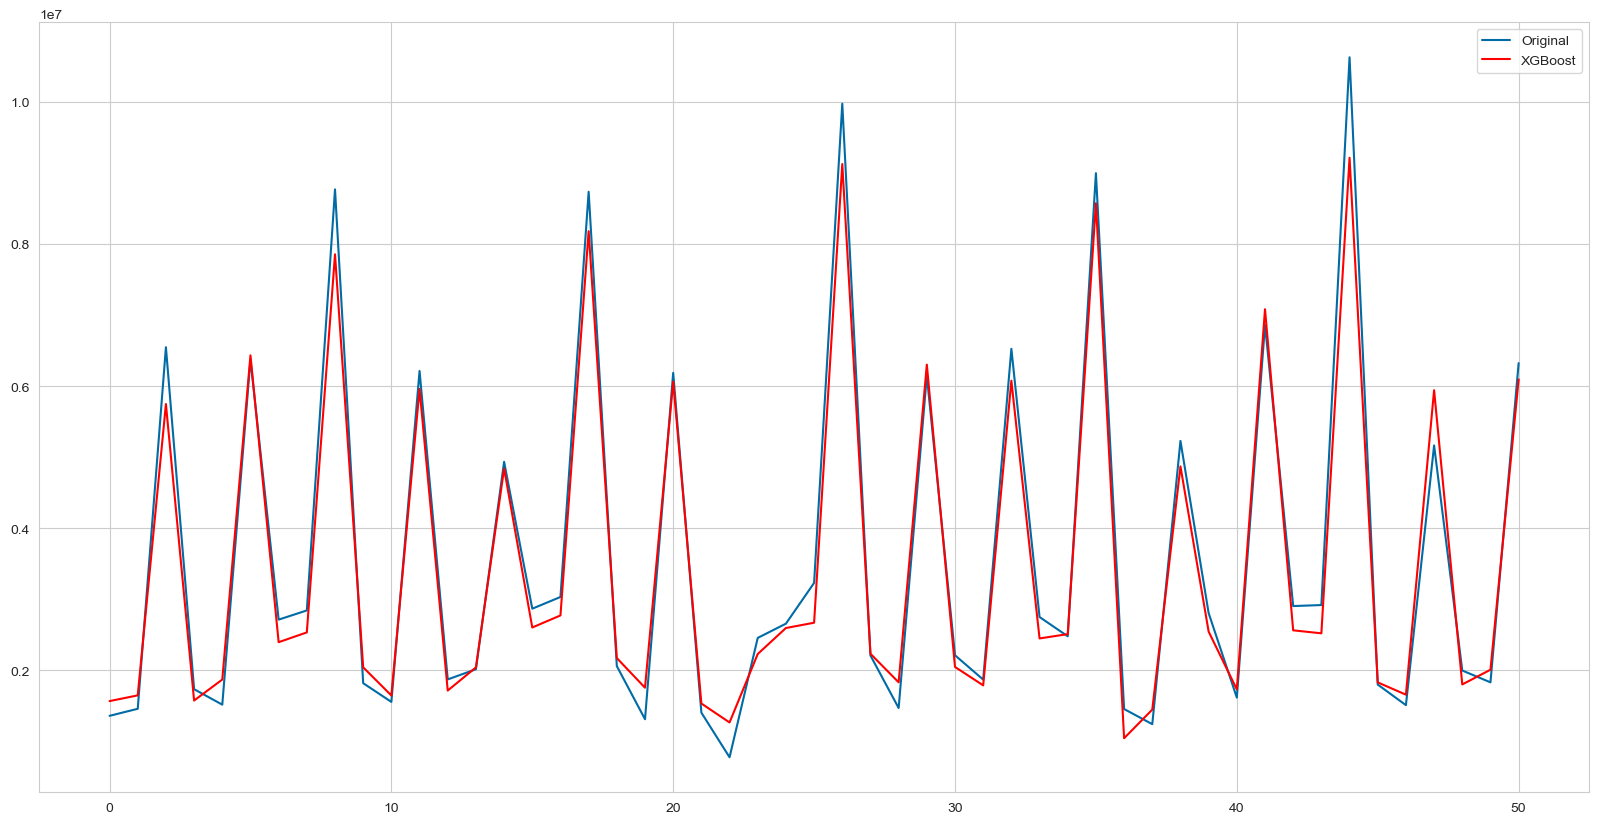

In [56]:
# Affichage des résultats
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost')
plt.legend()
plt.show()

In [57]:
import pandas as pd

# S'assurer que y_test est une Series (si ce n'est pas le cas)
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.squeeze()

# Création du DataFrame des résultats
results_df1 = X_test.copy()  # On part de X_test
results_df1['y_test'] = y_test.values
results_df1['yhat'] = yhat


In [58]:
results_df1.shape

(51, 21)

In [59]:
# renommer les colonnes y_test en Billings EURO et yhat en predicted_Billings dans ton DataFrame results_df1

results_df1 = results_df1.rename(columns={
    'y_test': 'Billings EURO',
    'yhat': 'predicted_Billings'
})


In [60]:
# Affichage des premières lignes
results_df1.tail(10)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
257    20.0  4.893165e+06  6.558645e+06  7.424804e+06        1551236   
258    25.0  1.507512e+06  1.999800e+06  2.341248e+06         389538   
259    25.0  1.555275e+06  1.763113e+06  2.070321e+06        8888821   
260    25.0  6.485997e+06  7.798918e+06  8.244714e+06        2235042   
261    19.0  1.292684e+06  1.703688e+06  1.714897e+06         209852   
262    19.0  1.413438e+06  1.516923e+06  1.902752e+06        7726416   
263    19.0  4.826611e+06  5.327718e+06  6.308114e+06        1682593   
264    18.0  8.481915e+05  1.387091e+06  1.750885e+06         148448   
265    18.0  1.479411e+06  1.828923e+06  1.937019e+06       10602153   
266    18.0  3.839780e+06  4.924944e+06  5.625376e+06        1310514   

      BACKLOG EUR  quarter  month  year  log_Backlog  ...   quarter_cos  \
257  7.479048e+06        1      2  2025    15.827616  ...  6.123234e-17   
258  2.710795e+06        1      3  2025    14.812753  ...  6.123234e-17   
259  2.075579e+06        1      3  2025    14.545751  ...  6.123234e-17   
260  9.213117e+06        1      3  2025    16.036139  ...  6.123234e-17   
261  1.710295e+06        2      4  2025    14.352177  ... -1.000000e+00   
262  1.540899e+06        2      4  2025    14.247877  ... -1.000000e+00   
263  6.836247e+06        2      4  2025    15.737750  ... -1.000000e+00   
264  1.399039e+06        2      5  2025    14.151297  ... -1.000000e+00   
265  1.943520e+06        2      5  2025    14.480012  ... -1.000000e+00   
266  5.565573e+06        2      5  2025    15.532111  ... -1.000000e+00   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  rolling_mean_sales_3  \
257             0.0          0.0            1.0          6.918049e+06   
258             1.0          0.0            0.0          2.337865e+06   
259             0.0          1.0            0.0          1.780358e+06   
260             0.0          0.0            1.0          7.030086e+06   
261             1.0          0.0            0.0          2.389290e+06   
262             0.0          1.0            0.0          1.926829e+06   
263             0.0          0.0            1.0          7.573742e+06   
264             1.0          0.0            0.0          2.504014e+06   
265             0.0          1.0            0.0          2.015987e+06   
266             0.0          0.0            1.0          7.552545e+06   

     sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  Billings EURO  \
257      1632531.48     -2136004.07       336113.50     6862262.22   
258        99568.44      1449104.90       154273.80     2905514.25   
259      1302634.99      1676234.26       439413.75     2919785.53   
260      3766972.10      5399503.58      1630968.03    10629234.32   
261     -1104931.02     -1005362.58       344173.88     1800583.23   
262     -1408760.52      -106125.53       267473.74     1511025.01   
263     -5463096.40     -1696124.30       -63592.82     5166137.92   
264       197797.57      -907133.45      -807565.01     1998380.80   
265       321079.49     -1087681.03       214953.96     1832104.50   
266      1158659.04     -4304437.36      -537465.26     6324796.96   

     predicted_Billings  
257         7083207.500  
258         2564056.750  
259         2522040.500  
260         9215373.000  
261         1831595.875  
262         1658458.875  
263         5943507.500  
264         1802521.625  
265         2009422.750  
266         6096108.000  

[10 rows x 21 columns]

#### To change

#### To change

In [63]:
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler

# 1. Séparer les données
df_train = df[df['year'] < previous_year].copy()
df_test = df[(df['year'] >= previous_year)].copy()

X_train = df_train.drop(['Billings EURO'], axis=1)
y_train = df_train['Billings EURO']



In [64]:
X_train.head(5)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
9     19.0  1.043593e+06  1.066547e+06  1.483390e+06         509805   
10    19.0  7.041474e+05  7.057524e+05  8.523218e+05        1115703   
11    19.0  3.689241e+06  3.581141e+06  4.466920e+06        2175285   
12    16.0  8.421211e+05  1.224620e+06  1.589071e+06         493340   
13    16.0  3.128158e+05  5.031267e+05  6.631210e+05        1029474   

     BACKLOG EUR  quarter  month  year  log_Backlog   quarter_sin  \
9   1.585139e+06        2      4  2018    14.276183  1.224647e-16   
10  9.304594e+05        2      4  2018    13.743435  1.224647e-16   
11  5.252894e+06        2      4  2018    15.474290  1.224647e-16   
12  1.656894e+06        2      5  2018    14.320456  1.224647e-16   
13  6.955586e+05        2      5  2018    13.452472  1.224647e-16   

    quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
9          -1.0             1.0          0.0            0.0   
10         -1.0             0.0          1.0            0.0   
11         -1.0             0.0          0.0            1.0   
12         -1.0             1.0          0.0            0.0   
13         -1.0             0.0          1.0            0.0   

    rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  
9           1.196609e+06      -134182.07       208030.24       139869.64  
10          8.623691e+05      -357550.29       175134.32       112705.75  
11          5.721307e+06     -1561554.14      -241862.31      -230609.40  
12          1.243232e+06       -18907.51      -153089.58       189122.73  
13          8.999377e+05      -320845.27      -678395.56      -145710.95

In [65]:
# 2. Standardisation
#numeric_cols = ['Blg T-3','Blg T-2','Blg T-1','Blg Total Qty', 'BACKLOG EUR',
                #'rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']

#scaler = StandardScaler()
#X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

In [66]:
X_train.head(5)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
9     19.0  1.043593e+06  1.066547e+06  1.483390e+06         509805   
10    19.0  7.041474e+05  7.057524e+05  8.523218e+05        1115703   
11    19.0  3.689241e+06  3.581141e+06  4.466920e+06        2175285   
12    16.0  8.421211e+05  1.224620e+06  1.589071e+06         493340   
13    16.0  3.128158e+05  5.031267e+05  6.631210e+05        1029474   

     BACKLOG EUR  quarter  month  year  log_Backlog   quarter_sin  \
9   1.585139e+06        2      4  2018    14.276183  1.224647e-16   
10  9.304594e+05        2      4  2018    13.743435  1.224647e-16   
11  5.252894e+06        2      4  2018    15.474290  1.224647e-16   
12  1.656894e+06        2      5  2018    14.320456  1.224647e-16   
13  6.955586e+05        2      5  2018    13.452472  1.224647e-16   

    quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
9          -1.0             1.0          0.0            0.0   
10         -1.0             0.0          1.0            0.0   
11         -1.0             0.0          0.0            1.0   
12         -1.0             1.0          0.0            0.0   
13         -1.0             0.0          1.0            0.0   

    rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  
9           1.196609e+06      -134182.07       208030.24       139869.64  
10          8.623691e+05      -357550.29       175134.32       112705.75  
11          5.721307e+06     -1561554.14      -241862.31      -230609.40  
12          1.243232e+06       -18907.51      -153089.58       189122.73  
13          8.999377e+05      -320845.27      -678395.56      -145710.95

In [67]:
# 3. Initialiser un DataFrame pour les prédictions
df_forecast = df_test.copy()
df_forecast['predicted_Billings'] = np.nan

#### To change

In [69]:
# 4. Ajouter les vraies valeurs connues jusqu’à mONTH YEAR
known_df = df_forecast[(df_forecast['year'] == previous_year) | ((df_forecast['year'] == year) & (df_forecast['month'] < MTD_test))].copy()
pred_df = df_forecast[(df_forecast['year'] == year) & (df_forecast['month'] >= MTD_test)].copy()

In [70]:
# 5. Fusionner
combined = pd.concat([known_df, pred_df], ignore_index=True)
combined['predicted_Billings'] = combined['Billings EURO']

In [71]:
df_forecast.shape , known_df.shape , pred_df.shape , combined.shape 

((72, 21), (51, 21), (21, 21), (72, 21))

In [72]:
# 6. Fonction de mise à jour des features
#def update_features(df_region):
    #df_region = df_region.sort_values(by=['year', 'month']).copy()
    #df_region['rolling_mean_sales_3'] = df_region['predicted_Billings'].shift(1).rolling(window=3).mean()
    #for lag in range(1, 4):
        #df_region[f'sales_diff_t-{lag}'] = df_region['predicted_Billings'].diff(lag)
    #return df_region

In [73]:
def update_features(df_region):
    df_region = df_region.sort_values(by=['year', 'month']).copy()
    df_region['rolling_mean_sales_3'] = df_region['predicted_Billings'].shift(1).rolling(window=3).mean()
    for lag in range(1, 4):
        df_region[f'sales_diff_t-{lag}'] = df_region['predicted_Billings'].diff(lag)
    
    # Supprimer les lignes où l'une des colonnes calculées contient un NaN
    df_region = df_region.dropna(subset=['rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3'])
    
    return df_region


In [74]:
#df_region

In [75]:
for year in [year]:
    for month in range(debut_predict, fin_predict):
        print(f"Prévision {month}/{year}")
        idx_target = (combined['year'] == year) & (combined['month'] == month)

        for region_col in ['REGION_AMERICA', 'REGION_ASIA', 'REGION_EUROPE']:
            region_mask = combined[region_col] == 1
            df_region = combined[region_mask].copy()
            df_region = update_features(df_region)

            # On s'assure que seuls les index valides sont utilisés pour la mise à jour
            valid_index = df_region.index

            combined.loc[valid_index, ['rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']] = \
                df_region[['rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']]

        # Extraire les features
        X_pred = combined.loc[idx_target].drop(['Billings EURO', 'predicted_Billings'], axis=1).astype(float)

        # Standardiser la ligne à prédire
        #X_pred[numeric_cols] = scaler.transform(X_pred[numeric_cols])

        # Prédiction
        y_pred = best_xgb.predict(X_pred)
        combined.loc[idx_target, 'predicted_Billings'] = y_pred


Prévision 6/2025
Prévision 7/2025
Prévision 8/2025
Prévision 9/2025
Prévision 10/2025
Prévision 11/2025
Prévision 12/2025


In [76]:
# 7. Prévision itérative avec StandardScaler à chaque étape
#for year in [2025]:
    #for month in range(4, 13):
        #print(f"Prévision {month}/{year}")
        #idx_target = (combined['year'] == year) & (combined['month'] == month)

        #for region_col in ['REGION_AMERICA', 'REGION_ASIA', 'REGION_EUROPE']:
            #region_mask = combined[region_col] == 1
            #df_region = combined[region_mask].copy()
            #df_region = update_features(df_region)

            #combined.loc[region_mask, ['rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']] = \
                #df_region[['rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']].values

        # Extraire les features
        #X_pred = combined.loc[idx_target].drop(['Billings EURO', 'predicted_Billings'], axis=1).astype(float)

        # Standardiser la ligne à prédire
        #X_pred[numeric_cols] = scaler.transform(X_pred[numeric_cols])

        # Prédiction
        #y_pred = best_xgb.predict(X_pred)
        #combined.loc[idx_target, 'predicted_Billings'] = y_pred

In [77]:
# 8. Évaluation
eval_mask = (combined['year'] == previous_year) | ((combined['year'] == year) & (combined['month'] < MTD_test))
y_true = combined.loc[eval_mask, 'Billings EURO']
y_pred_eval = combined.loc[eval_mask, 'predicted_Billings']

rmse = np.sqrt(MSE(y_true, y_pred_eval))
r2 = r2_score(y_true, y_pred_eval)
mae = MAE(y_true, y_pred_eval)
mae_percentage = (mae / np.mean(y_true)) * 100

print("Meilleur score R2 :", r2)
print("RMSE : % f" % rmse)
print("MAE en pourcentage : %.2f%%" % mae_percentage)

Meilleur score R2 : 1.0
RMSE :  0.000000
MAE en pourcentage : 0.00%


In [78]:
# 9. Export final
final_preds = combined[(combined['year'] == year)][['year', 'month', 'predicted_Billings']]

In [79]:
combined.isna().sum()

Actual                  0
Blg T-3                 0
Blg T-2                 0
Blg T-1                 0
Blg Total Qty           0
BACKLOG EUR             0
Billings EURO           0
quarter                 0
month                   0
year                    0
log_Backlog             0
quarter_sin             0
quarter_cos             0
REGION_AMERICA          0
REGION_ASIA             0
REGION_EUROPE           0
rolling_mean_sales_3    0
sales_diff_t-1          0
sales_diff_t-2          0
sales_diff_t-3          0
predicted_Billings      0
dtype: int64

In [80]:
combined.head(10)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
0    16.0  1.327916e+06  1.685202e+06  1.743102e+06         191565   
1    16.0  2.085319e+06  1.597469e+06  1.825497e+06        9105058   
2    16.0  4.881041e+06  5.660553e+06  5.777857e+06        1828236   
3    20.0  1.270276e+06  1.188518e+06  1.526136e+06         247733   
4    20.0  1.570154e+06  1.551265e+06  1.545120e+06        6510518   
5    20.0  5.764709e+06  6.383809e+06  6.944323e+06        2006449   
6    25.0  1.270256e+06  1.433775e+06  1.574871e+06         295296   
7    25.0  1.644453e+06  1.452610e+06  1.690372e+06        9291042   
8    25.0  5.872569e+06  6.853453e+06  8.090305e+06        2241286   
9    19.0  1.056794e+06  1.355089e+06  1.473699e+06         254275   

    BACKLOG EUR  Billings EURO  quarter  month  year  ...   quarter_sin  \
0  1.535350e+06     1360570.66        1      1  2024  ...  1.000000e+00   
1  1.771613e+06     1459936.67        1      1  2024  ...  1.000000e+00   
2  6.050074e+06     6548783.75        1      1  2024  ...  1.000000e+00   
3  1.532167e+06     1735804.69        1      2  2024  ...  1.000000e+00   
4  1.511414e+06     1517802.60        1      2  2024  ...  1.000000e+00   
5  7.593257e+06     6372559.23        1      2  2024  ...  1.000000e+00   
6  1.925909e+06     2714684.37        1      3  2024  ...  1.000000e+00   
7  1.697827e+06     2843931.20        1      3  2024  ...  1.000000e+00   
8  8.801484e+06     8770047.63        1      3  2024  ...  1.000000e+00   
9  1.860770e+06     1820015.24        2      4  2024  ...  1.224647e-16   

    quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
0  6.123234e-17             1.0          0.0            0.0   
1  6.123234e-17             0.0          1.0            0.0   
2  6.123234e-17             0.0          0.0            1.0   
3  6.123234e-17             1.0          0.0            0.0   
4  6.123234e-17             0.0          1.0            0.0   
5  6.123234e-17             0.0          0.0            1.0   
6  6.123234e-17             1.0          0.0            0.0   
7  6.123234e-17             0.0          1.0            0.0   
8  6.123234e-17             0.0          0.0            1.0   
9 -1.000000e+00             1.0          0.0            0.0   

   rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  \
0          2.112110e+06      -872388.98      -688289.96      -693940.35   
1          2.203172e+06     -1581411.04      -253955.54      -394339.24   
2          6.949760e+06     -1425686.41      -220644.36       443403.15   
3          1.880797e+06       375234.03      -497154.95      -313055.93   
4          2.071726e+06        57865.93     -1523545.11      -196089.61   
5          7.097561e+06      -176224.52     -1601910.93      -396868.88   
6          1.776445e+06       978879.68      1354113.71       481724.73   
7          2.006362e+06      1326128.60      1383994.53      -197416.51   
8          6.965271e+06      2397488.40      2221263.88       795577.47   
9          1.937020e+06      -894669.13        84210.55       459444.58   

   predicted_Billings  
0          1360570.66  
1          1459936.67  
2          6548783.75  
3          1735804.69  
4          1517802.60  
5          6372559.23  
6          2714684.37  
7          2843931.20  
8          8770047.63  
9          1820015.24  

[10 rows x 21 columns]

In [81]:
combined.shape

(72, 21)

In [82]:
combined.tail(40)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
32    18.0  4.417080e+06  5.472602e+06  6.190540e+06        1702489   
33    23.0  1.420070e+06  1.758942e+06  2.180818e+06         241572   
34    23.0  2.144811e+06  2.288527e+06  2.272190e+06        7302964   
35    23.0  6.996177e+06  8.052242e+06  9.253355e+06        2163197   
36    12.0  6.942508e+05  8.583321e+05  9.302006e+05          87875   
37    12.0  7.045142e+05  1.526639e+06  1.314476e+06        8407034   
38    12.0  3.819952e+06  4.234078e+06  5.015205e+06        1013892   
39    20.0  1.018532e+06  1.793776e+06  2.212928e+06         206189   
40    20.0  1.478119e+06  1.669167e+06  2.024821e+06        6720000   
41    20.0  4.893165e+06  6.558645e+06  7.424804e+06        1551236   
42    25.0  1.507512e+06  1.999800e+06  2.341248e+06         389538   
43    25.0  1.555275e+06  1.763113e+06  2.070321e+06        8888821   
44    25.0  6.485997e+06  7.798918e+06  8.244714e+06        2235042   
45    19.0  1.292684e+06  1.703688e+06  1.714897e+06         209852   
46    19.0  1.413438e+06  1.516923e+06  1.902752e+06        7726416   
47    19.0  4.826611e+06  5.327718e+06  6.308114e+06        1682593   
48    18.0  8.481915e+05  1.387091e+06  1.750885e+06         148448   
49    18.0  1.479411e+06  1.828923e+06  1.937019e+06       10602153   
50    18.0  3.839780e+06  4.924944e+06  5.625376e+06        1310514   
51    23.0  1.304670e+06  1.883682e+06  2.398461e+06         278608   
52    23.0  2.032185e+06  1.295134e+06  2.530387e+06        9353500   
53    23.0  5.205921e+06  6.497793e+06  7.756563e+06        1935841   
54    19.0  8.290376e+05  1.042155e+06  1.459661e+06         203163   
55    19.0  1.417734e+06  9.017562e+05  1.905211e+06        7375060   
56    19.0  3.457444e+06  4.322539e+06  6.006144e+06        1682028   
57     5.0  3.219911e+05  8.002111e+05  8.677194e+05         137063   
58     5.0  7.067963e+05  7.977363e+05  1.382087e+06        6933153   
59     5.0  1.926043e+06  2.368019e+06  2.793927e+06         732760   
60    25.0  4.080630e+05  4.759840e+05  8.187882e+05          98991   
61    25.0  1.309769e+06  7.915164e+05  1.759420e+06        9543428   
62    25.0  3.169257e+06  3.853770e+06  5.344733e+06        1234750   
63    20.0  4.252910e+05  4.044390e+05  4.593149e+05          37116   
64    20.0  5.383332e+05  5.698030e+05  1.412635e+06        6597719   
65    20.0  2.190149e+06  2.946893e+06  3.488876e+06         426867   
66    19.0  2.282571e+05  2.980425e+05  5.600717e+05          47471   
67    19.0  5.690620e+05  5.747473e+05  1.394569e+06        7026387   
68    19.0  2.048333e+06  2.057335e+06  3.010614e+06         436021   
69    26.0  1.173866e+05  1.709326e+05  3.426315e+05          56580   
70    26.0  4.119240e+05  6.092065e+05  1.655363e+06        8361895   
71    26.0  2.350936e+06  2.763720e+06  3.652395e+06         449730   

     BACKLOG EUR  Billings EURO  quarter  month  year  ...   quarter_sin  \
32  6.628500e+06     6526148.72        4     11  2024  ... -2.449294e-16   
33  2.285660e+06     2751240.45        4     12  2024  ... -2.449294e-16   
34  2.384372e+06     2480371.78        4     12  2024  ... -2.449294e-16   
35  8.993952e+06     8998266.29        4     12  2024  ... -2.449294e-16   
36  8.369455e+05     1456409.35        1      1  2025  ...  1.000000e+00   
37  1.388378e+06     1243551.27        1      1  2025  ...  1.000000e+00   
38  4.991226e+06     5229730.74        1      1  2025  ...  1.000000e+00   
39  1.842539e+06     2805945.81        1      2  2025  ...  1.000000e+00   
40  1.974238e+06     1617150.54        1      2  2025  ...  1.000000e+00   
41  7.479048e+06     6862262.22        1      2  2025  ...  1.000000e+00   
42  2.710795e+06     2905514.25        1      3  2025  ...  1.000000e+00   
43  2.075579e+06     2919785.53        1      3  2025  ...  1.000000e+00   
44  9.213117e+06    10629234.32        1      3  2025  ...  1.000000e+00   
45  1.710295e+06     1800583

In [83]:
#  filtrer uniquement les lignes de la table combined où la colonne 'Billings EURO' est égale à 0.00

combined = combined[np.isclose(combined['Billings EURO'], 0.00)]

In [84]:
combined.tail(40)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
51    23.0  1.304670e+06  1.883682e+06  2.398461e+06         278608   
52    23.0  2.032185e+06  1.295134e+06  2.530387e+06        9353500   
53    23.0  5.205921e+06  6.497793e+06  7.756563e+06        1935841   
54    19.0  8.290376e+05  1.042155e+06  1.459661e+06         203163   
55    19.0  1.417734e+06  9.017562e+05  1.905211e+06        7375060   
56    19.0  3.457444e+06  4.322539e+06  6.006144e+06        1682028   
57     5.0  3.219911e+05  8.002111e+05  8.677194e+05         137063   
58     5.0  7.067963e+05  7.977363e+05  1.382087e+06        6933153   
59     5.0  1.926043e+06  2.368019e+06  2.793927e+06         732760   
60    25.0  4.080630e+05  4.759840e+05  8.187882e+05          98991   
61    25.0  1.309769e+06  7.915164e+05  1.759420e+06        9543428   
62    25.0  3.169257e+06  3.853770e+06  5.344733e+06        1234750   
63    20.0  4.252910e+05  4.044390e+05  4.593149e+05          37116   
64    20.0  5.383332e+05  5.698030e+05  1.412635e+06        6597719   
65    20.0  2.190149e+06  2.946893e+06  3.488876e+06         426867   
66    19.0  2.282571e+05  2.980425e+05  5.600717e+05          47471   
67    19.0  5.690620e+05  5.747473e+05  1.394569e+06        7026387   
68    19.0  2.048333e+06  2.057335e+06  3.010614e+06         436021   
69    26.0  1.173866e+05  1.709326e+05  3.426315e+05          56580   
70    26.0  4.119240e+05  6.092065e+05  1.655363e+06        8361895   
71    26.0  2.350936e+06  2.763720e+06  3.652395e+06         449730   

     BACKLOG EUR  Billings EURO  quarter  month  year  ...   quarter_sin  \
51  2.167255e+06            0.0        2      6  2025  ...  1.224647e-16   
52  2.137497e+06            0.0        2      6  2025  ...  1.224647e-16   
53  7.983567e+06            0.0        2      6  2025  ...  1.224647e-16   
54  1.735729e+06            0.0        3      7  2025  ... -1.000000e+00   
55  2.101247e+06            0.0        3      7  2025  ... -1.000000e+00   
56  6.545976e+06            0.0        3      7  2025  ... -1.000000e+00   
57  1.202809e+06            0.0        3      8  2025  ... -1.000000e+00   
58  1.211676e+06            0.0        3      8  2025  ... -1.000000e+00   
59  3.123485e+06            0.0        3      8  2025  ... -1.000000e+00   
60  1.241113e+06            0.0        3      9  2025  ... -1.000000e+00   
61  1.870237e+06            0.0        3      9  2025  ... -1.000000e+00   
62  6.088072e+06            0.0        3      9  2025  ... -1.000000e+00   
63  8.421610e+05            0.0        4     10  2025  ... -2.449294e-16   
64  1.331474e+06            0.0        4     10  2025  ... -2.449294e-16   
65  3.997920e+06            0.0        4     10  2025  ... -2.449294e-16   
66  7.063344e+05            0.0        4     11  2025  ... -2.449294e-16   
67  1.525657e+06            0.0        4     11  2025  ... -2.449294e-16   
68  3.631242e+06            0.0        4     11  2025  ... -2.449294e-16   
69  8.572678e+05            0.0        4     12  2025  ... -2.449294e-16   
70  1.785945e+06            0.0        4     12  2025  ... -2.449294e-16   
71  3.977090e+06            0.0        4     12  2025  ... -2.449294e-16   

     quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
51 -1.000000e+00             1.0          0.0            0.0   
52 -1.000000e+00             0.0          1.0            0.0   
53 -1.000000e+00             0.0          0.0            1.0   
54 -1.836970e-16             1.0          0.0            0.0   
55 -1.836970e-16             0.0          1.0            0.0   
56 -1.836970e-16             0.0          0.0            1.0   
57 -1.836970e-16             1.0          0.0            0.0   
58 -1.836970e-16             0.0          1.0            0.0   
59 -1.836970e-16             0.0          0.0            1.0   
60 -1.836970e-16             1.0          0.0            0.0   
61 -1.836970e-16             0.0          1.0            0.0   


In [85]:
combined_final = pd.concat([results_df1,combined], ignore_index=True)


In [86]:
combined_final.head(15)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
0     16.0  1.327916e+06  1.685202e+06  1.743102e+06         191565   
1     16.0  2.085319e+06  1.597469e+06  1.825497e+06        9105058   
2     16.0  4.881041e+06  5.660553e+06  5.777857e+06        1828236   
3     20.0  1.270276e+06  1.188518e+06  1.526136e+06         247733   
4     20.0  1.570154e+06  1.551265e+06  1.545120e+06        6510518   
5     20.0  5.764709e+06  6.383809e+06  6.944323e+06        2006449   
6     25.0  1.270256e+06  1.433775e+06  1.574871e+06         295296   
7     25.0  1.644453e+06  1.452610e+06  1.690372e+06        9291042   
8     25.0  5.872569e+06  6.853453e+06  8.090305e+06        2241286   
9     19.0  1.056794e+06  1.355089e+06  1.473699e+06         254275   
10    19.0  1.649446e+06  1.841905e+06  1.926243e+06        8589866   
11    19.0  4.241059e+06  5.424941e+06  6.344735e+06        2065617   
12    15.0  8.895738e+05  1.052578e+06  1.593390e+06         224516   
13    15.0  1.569364e+06  1.694691e+06  1.955839e+06        9569228   
14    15.0  3.427546e+06  4.201860e+06  4.954693e+06        1659487   

     BACKLOG EUR  quarter  month  year  log_Backlog  ...   quarter_cos  \
0   1.535350e+06        1      1  2024    14.244269  ...  6.123234e-17   
1   1.771613e+06        1      1  2024    14.387402  ...  6.123234e-17   
2   6.050074e+06        1      1  2024    15.615581  ...  6.123234e-17   
3   1.532167e+06        1      2  2024    14.242194  ...  6.123234e-17   
4   1.511414e+06        1      2  2024    14.228557  ...  6.123234e-17   
5   7.593257e+06        1      2  2024    15.842771  ...  6.123234e-17   
6   1.925909e+06        1      3  2024    14.470909  ...  6.123234e-17   
7   1.697827e+06        1      3  2024    14.344861  ...  6.123234e-17   
8   8.801484e+06        1      3  2024    15.990431  ...  6.123234e-17   
9   1.860770e+06        2      4  2024    14.436501  ... -1.000000e+00   
10  2.200370e+06        2      4  2024    14.604137  ... -1.000000e+00   
11  7.559615e+06        2      4  2024    15.838331  ... -1.000000e+00   
12  1.618105e+06        2      5  2024    14.296767  ... -1.000000e+00   
13  2.237305e+06        2      5  2024    14.620783  ... -1.000000e+00   
14  5.598114e+06        2      5  2024    15.537940  ... -1.000000e+00   

    REGION_AMERICA  REGION_ASIA  REGION_EUROPE  rolling_mean_sales_3  \
0              1.0          0.0            0.0          2.112110e+06   
1              0.0          1.0            0.0          2.203172e+06   
2              0.0          0.0            1.0          6.949760e+06   
3              1.0          0.0            0.0          1.880797e+06   
4              0.0          1.0            0.0          2.071726e+06   
5              0.0          0.0            1.0          7.097561e+06   
6              1.0          0.0            0.0          1.776445e+06   
7              0.0          1.0            0.0          2.006362e+06   
8              0.0          0.0            1.0          6.965271e+06   
9              1.0          0.0            0.0          1.937020e+06   
10             0.0          1.0            0.0          1.940557e+06   
11             0.0          0.0            1.0          7.230464e+06   
12             1.0          0.0            0.0          2.090168e+06   
13             0.0          1.0            0.0          1.972777e+06   
14             0.0          0.0            1.0          7.118986e+06   

    sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  Billings EURO  \
0       -872388.98      -688289.96      -693940.35     1360570.66   
1      -1581411.04      -253955.54      -394339.24     1459936.67   
2      -1425686.41      -220644.36       443403.15     6548783.75   
3        375234.03      -497154.95      -313055.93     1735804.69   
4         57865.93     -1523545.11      -196089.61     1517802.60   
5       -176224.52     -1601910.93      -396868.88     6372559.23   
6        978879.68      1354113.71       48172

In [87]:
df_encoded = combined_final[['REGION_AMERICA','REGION_ASIA','REGION_EUROPE']]

In [88]:
df_encoded.shape , combined_final.shape 

((72, 3), (72, 21))

In [89]:
# Reconstruction de la colonne REGION
#df_encoded= df_encoded.copy()
df_encoded['REGION'] = encoder.inverse_transform(df_encoded).squeeze()

C:\Users\rtekem\AppData\Local\Temp\ipykernel_19072\3411269311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['REGION'] = encoder.inverse_transform(df_encoded).squeeze()


In [90]:
df_encoded.head(5)

REGION_AMERICA  REGION_ASIA  REGION_EUROPE   REGION
0             1.0          0.0            0.0  AMERICA
1             0.0          1.0            0.0     ASIA
2             0.0          0.0            1.0   EUROPE
3             1.0          0.0            0.0  AMERICA
4             0.0          1.0            0.0     ASIA

In [91]:
df_encoded = df_encoded.drop(columns=['REGION_AMERICA','REGION_ASIA','REGION_EUROPE'])

In [92]:
df_encoded.head(5)

REGION
0  AMERICA
1     ASIA
2   EUROPE
3  AMERICA
4     ASIA

In [93]:
# ✅ Fusion avec df sans REGION
combined_final = combined_final.join(df_encoded)

In [94]:
combined_final.head(5)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
0    16.0  1.327916e+06  1.685202e+06  1.743102e+06         191565   
1    16.0  2.085319e+06  1.597469e+06  1.825497e+06        9105058   
2    16.0  4.881041e+06  5.660553e+06  5.777857e+06        1828236   
3    20.0  1.270276e+06  1.188518e+06  1.526136e+06         247733   
4    20.0  1.570154e+06  1.551265e+06  1.545120e+06        6510518   

    BACKLOG EUR  quarter  month  year  log_Backlog  ...  REGION_AMERICA  \
0  1.535350e+06        1      1  2024    14.244269  ...             1.0   
1  1.771613e+06        1      1  2024    14.387402  ...             0.0   
2  6.050074e+06        1      1  2024    15.615581  ...             0.0   
3  1.532167e+06        1      2  2024    14.242194  ...             1.0   
4  1.511414e+06        1      2  2024    14.228557  ...             0.0   

   REGION_ASIA  REGION_EUROPE  rolling_mean_sales_3  sales_diff_t-1  \
0          0.0            0.0          2.112110e+06      -872388.98   
1          1.0            0.0          2.203172e+06     -1581411.04   
2          0.0            1.0          6.949760e+06     -1425686.41   
3          0.0            0.0          1.880797e+06       375234.03   
4          1.0            0.0          2.071726e+06        57865.93   

   sales_diff_t-2  sales_diff_t-3  Billings EURO  predicted_Billings   REGION  
0      -688289.96      -693940.35     1360570.66         1568195.500  AMERICA  
1      -253955.54      -394339.24     1459936.67         1648658.625     ASIA  
2      -220644.36       443403.15     6548783.75         5748838.000   EUROPE  
3      -497154.95      -313055.93     1735804.69         1575915.000  AMERICA  
4     -1523545.11      -196089.61     1517802.60         1871186.875     ASIA  

[5 rows x 22 columns]

In [95]:
combined_final  = combined_final.drop(columns=['REGION_AMERICA','REGION_ASIA','REGION_EUROPE'])

In [96]:
combined_final.head(5)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
0    16.0  1.327916e+06  1.685202e+06  1.743102e+06         191565   
1    16.0  2.085319e+06  1.597469e+06  1.825497e+06        9105058   
2    16.0  4.881041e+06  5.660553e+06  5.777857e+06        1828236   
3    20.0  1.270276e+06  1.188518e+06  1.526136e+06         247733   
4    20.0  1.570154e+06  1.551265e+06  1.545120e+06        6510518   

    BACKLOG EUR  quarter  month  year  log_Backlog  quarter_sin   quarter_cos  \
0  1.535350e+06        1      1  2024    14.244269          1.0  6.123234e-17   
1  1.771613e+06        1      1  2024    14.387402          1.0  6.123234e-17   
2  6.050074e+06        1      1  2024    15.615581          1.0  6.123234e-17   
3  1.532167e+06        1      2  2024    14.242194          1.0  6.123234e-17   
4  1.511414e+06        1      2  2024    14.228557          1.0  6.123234e-17   

   rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  \
0          2.112110e+06      -872388.98      -688289.96      -693940.35   
1          2.203172e+06     -1581411.04      -253955.54      -394339.24   
2          6.949760e+06     -1425686.41      -220644.36       443403.15   
3          1.880797e+06       375234.03      -497154.95      -313055.93   
4          2.071726e+06        57865.93     -1523545.11      -196089.61   

   Billings EURO  predicted_Billings   REGION  
0     1360570.66         1568195.500  AMERICA  
1     1459936.67         1648658.625     ASIA  
2     6548783.75         5748838.000   EUROPE  
3     1735804.69         1575915.000  AMERICA  
4     1517802.60         1871186.875     ASIA

In [97]:
# Condition sur la colonne REGION
combined_final['Material Grp 3'] = combined_final['REGION'].apply(lambda x: 'vishay' if x == 'CN' else 'vishay')

In [98]:
combined_final.head(5)

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
0    16.0  1.327916e+06  1.685202e+06  1.743102e+06         191565   
1    16.0  2.085319e+06  1.597469e+06  1.825497e+06        9105058   
2    16.0  4.881041e+06  5.660553e+06  5.777857e+06        1828236   
3    20.0  1.270276e+06  1.188518e+06  1.526136e+06         247733   
4    20.0  1.570154e+06  1.551265e+06  1.545120e+06        6510518   

    BACKLOG EUR  quarter  month  year  log_Backlog  quarter_sin   quarter_cos  \
0  1.535350e+06        1      1  2024    14.244269          1.0  6.123234e-17   
1  1.771613e+06        1      1  2024    14.387402          1.0  6.123234e-17   
2  6.050074e+06        1      1  2024    15.615581          1.0  6.123234e-17   
3  1.532167e+06        1      2  2024    14.242194          1.0  6.123234e-17   
4  1.511414e+06        1      2  2024    14.228557          1.0  6.123234e-17   

   rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  \
0          2.112110e+06      -872388.98      -688289.96      -693940.35   
1          2.203172e+06     -1581411.04      -253955.54      -394339.24   
2          6.949760e+06     -1425686.41      -220644.36       443403.15   
3          1.880797e+06       375234.03      -497154.95      -313055.93   
4          2.071726e+06        57865.93     -1523545.11      -196089.61   

   Billings EURO  predicted_Billings   REGION Material Grp 3  
0     1360570.66         1568195.500  AMERICA         vishay  
1     1459936.67         1648658.625     ASIA         vishay  
2     6548783.75         5748838.000   EUROPE         vishay  
3     1735804.69         1575915.000  AMERICA         vishay  
4     1517802.60         1871186.875     ASIA         vishay

In [99]:
# Affichage des résultats
tekem = combined_final[['month','Billings EURO','predicted_Billings']]

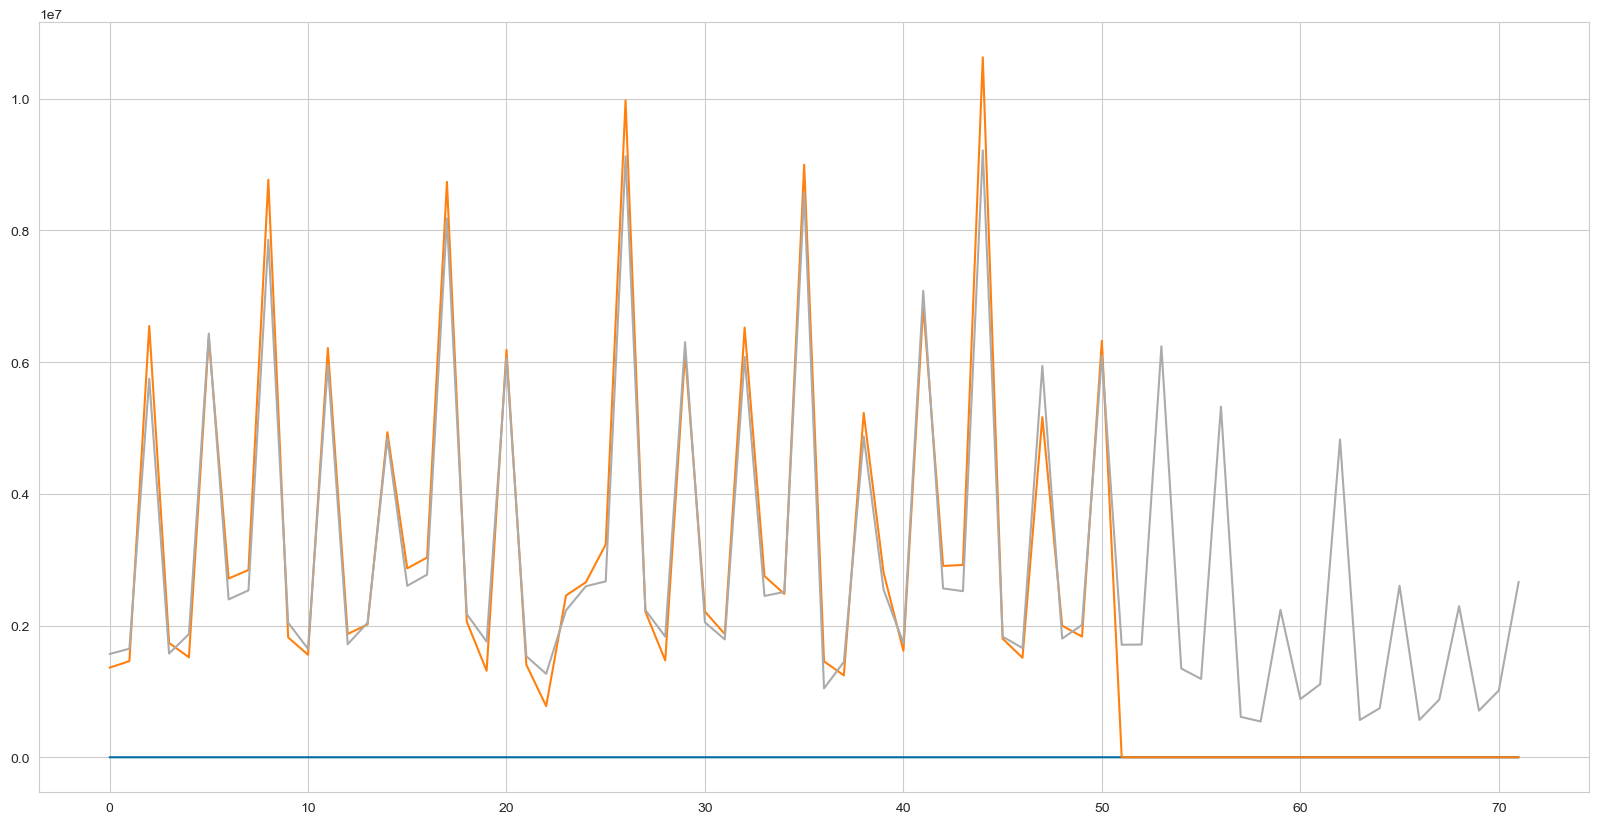

In [100]:
plt.plot(tekem)

In [101]:
df_vishay = combined_final.copy()

In [102]:
df_vishay['periode'] = df_vishay['year'].astype(str) + "-" + df_vishay['month'].astype(str).str.zfill(2)

df_vishay.head()

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
0    16.0  1.327916e+06  1.685202e+06  1.743102e+06         191565   
1    16.0  2.085319e+06  1.597469e+06  1.825497e+06        9105058   
2    16.0  4.881041e+06  5.660553e+06  5.777857e+06        1828236   
3    20.0  1.270276e+06  1.188518e+06  1.526136e+06         247733   
4    20.0  1.570154e+06  1.551265e+06  1.545120e+06        6510518   

    BACKLOG EUR  quarter  month  year  log_Backlog  ...   quarter_cos  \
0  1.535350e+06        1      1  2024    14.244269  ...  6.123234e-17   
1  1.771613e+06        1      1  2024    14.387402  ...  6.123234e-17   
2  6.050074e+06        1      1  2024    15.615581  ...  6.123234e-17   
3  1.532167e+06        1      2  2024    14.242194  ...  6.123234e-17   
4  1.511414e+06        1      2  2024    14.228557  ...  6.123234e-17   

   rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  \
0          2.112110e+06      -872388.98      -688289.96      -693940.35   
1          2.203172e+06     -1581411.04      -253955.54      -394339.24   
2          6.949760e+06     -1425686.41      -220644.36       443403.15   
3          1.880797e+06       375234.03      -497154.95      -313055.93   
4          2.071726e+06        57865.93     -1523545.11      -196089.61   

   Billings EURO  predicted_Billings   REGION Material Grp 3  periode  
0     1360570.66         1568195.500  AMERICA         vishay  2024-01  
1     1459936.67         1648658.625     ASIA         vishay  2024-01  
2     6548783.75         5748838.000   EUROPE         vishay  2024-01  
3     1735804.69         1575915.000  AMERICA         vishay  2024-02  
4     1517802.60         1871186.875     ASIA         vishay  2024-02  

[5 rows x 21 columns]

In [103]:
# Conversion de la colonne "periode" en type datetime
df_vishay['periode'] = pd.to_datetime(df_vishay['periode'], format='%Y-%m')
                                                                                                
df_vishay.head()

Actual       Blg T-3       Blg T-2       Blg T-1  Blg Total Qty  \
0    16.0  1.327916e+06  1.685202e+06  1.743102e+06         191565   
1    16.0  2.085319e+06  1.597469e+06  1.825497e+06        9105058   
2    16.0  4.881041e+06  5.660553e+06  5.777857e+06        1828236   
3    20.0  1.270276e+06  1.188518e+06  1.526136e+06         247733   
4    20.0  1.570154e+06  1.551265e+06  1.545120e+06        6510518   

    BACKLOG EUR  quarter  month  year  log_Backlog  ...   quarter_cos  \
0  1.535350e+06        1      1  2024    14.244269  ...  6.123234e-17   
1  1.771613e+06        1      1  2024    14.387402  ...  6.123234e-17   
2  6.050074e+06        1      1  2024    15.615581  ...  6.123234e-17   
3  1.532167e+06        1      2  2024    14.242194  ...  6.123234e-17   
4  1.511414e+06        1      2  2024    14.228557  ...  6.123234e-17   

   rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  \
0          2.112110e+06      -872388.98      -688289.96      -693940.35   
1          2.203172e+06     -1581411.04      -253955.54      -394339.24   
2          6.949760e+06     -1425686.41      -220644.36       443403.15   
3          1.880797e+06       375234.03      -497154.95      -313055.93   
4          2.071726e+06        57865.93     -1523545.11      -196089.61   

   Billings EURO  predicted_Billings   REGION Material Grp 3    periode  
0     1360570.66         1568195.500  AMERICA         vishay 2024-01-01  
1     1459936.67         1648658.625     ASIA         vishay 2024-01-01  
2     6548783.75         5748838.000   EUROPE         vishay 2024-01-01  
3     1735804.69         1575915.000  AMERICA         vishay 2024-02-01  
4     1517802.60         1871186.875     ASIA         vishay 2024-02-01  

[5 rows x 21 columns]

In [104]:
# Regrouper par période et sommer les valeurs
df_somme = df_vishay.groupby('periode')[['Billings EURO', 'predicted_Billings']].sum().reset_index()

# Afficher le résultat
print(df_somme)

      periode  Billings EURO  predicted_Billings
0  2024-01-01     9369291.08        8.965692e+06
1  2024-02-01     9626166.52        9.881500e+06
2  2024-03-01    14328663.20        1.278828e+07
3  2024-04-01     9590964.46        9.651124e+06
4  2024-05-01     8825252.63        8.599562e+06
5  2024-06-01    14638325.20        1.355999e+07
6  2024-07-01     9560832.54        9.994488e+06
7  2024-08-01     4640453.22        5.032826e+06
8  2024-09-01    15865585.51        1.439470e+07
9  2024-10-01     9828369.35        1.037022e+07
10 2024-11-01    10609734.92        9.916194e+06
11 2024-12-01    14229878.52        1.353577e+07
12 2025-01-01     7929691.36        7.365055e+06
13 2025-02-01    11285358.57        1.136134e+07
14 2025-03-01    16454534.10        1.430147e+07
15 2025-04-01     8477746.16        9.433562e+06
16 2025-05-01    10155282.26        9.908052e+06
17 2025-06-01           0.00        9.659809e+06
18 2025-07-01           0.00        7.862136e+06
19 2025-08-01       

In [105]:
from IPython.display import display
display(df_somme)

periode  Billings EURO  predicted_Billings
0  2024-01-01     9369291.08        8.965692e+06
1  2024-02-01     9626166.52        9.881500e+06
2  2024-03-01    14328663.20        1.278828e+07
3  2024-04-01     9590964.46        9.651124e+06
4  2024-05-01     8825252.63        8.599562e+06
5  2024-06-01    14638325.20        1.355999e+07
6  2024-07-01     9560832.54        9.994488e+06
7  2024-08-01     4640453.22        5.032826e+06
8  2024-09-01    15865585.51        1.439470e+07
9  2024-10-01     9828369.35        1.037022e+07
10 2024-11-01    10609734.92        9.916194e+06
11 2024-12-01    14229878.52        1.353577e+07
12 2025-01-01     7929691.36        7.365055e+06
13 2025-02-01    11285358.57        1.136134e+07
14 2025-03-01    16454534.10        1.430147e+07
15 2025-04-01     8477746.16        9.433562e+06
16 2025-05-01    10155282.26        9.908052e+06
17 2025-06-01           0.00        9.659809e+06
18 2025-07-01           0.00        7.862136e+06
19 2025-08-01           0.00        3.394394e+06
20 2025-09-01           0.00        6.819773e+06
21 2025-10-01           0.00        3.916944e+06
22 2025-11-01           0.00        3.737199e+06
23 2025-12-01           0.00        4.387630e+06

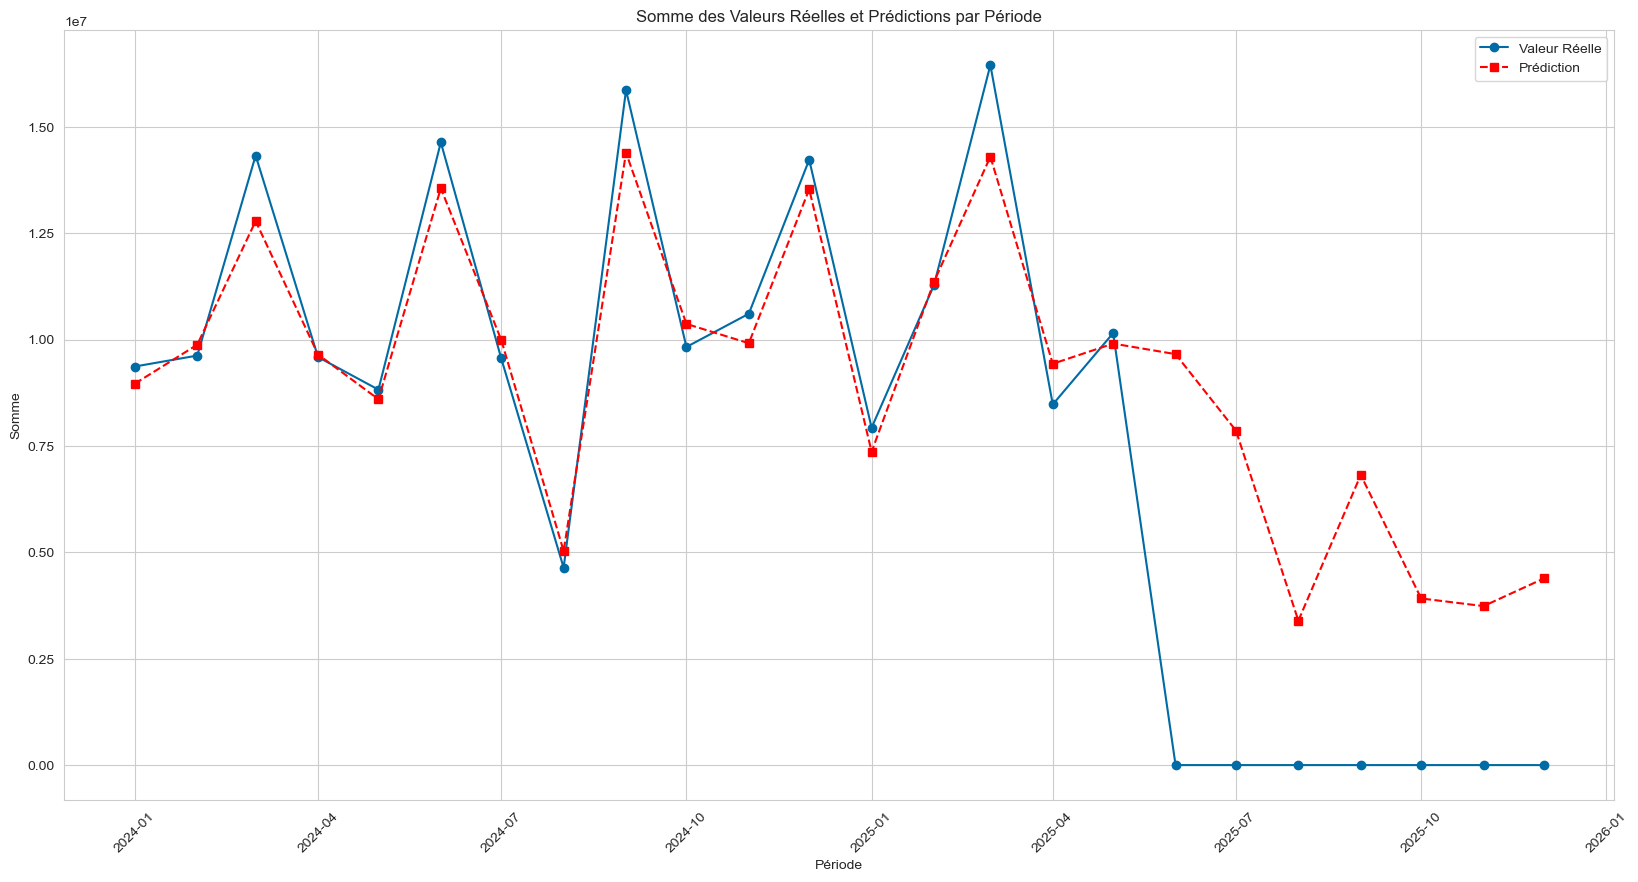

In [106]:
plt.plot(df_somme['periode'], df_somme['Billings EURO'], label='Valeur Réelle', marker='o')
plt.plot(df_somme['periode'], df_somme['predicted_Billings'], label='Prédiction', marker='s', linestyle='dashed', color='red')

plt.xlabel('Période')
plt.ylabel('Somme')
plt.title('Somme des Valeurs Réelles et Prédictions par Période')
plt.legend()
plt.xticks(rotation=45)  # Rotation des dates pour meilleure lisibilité
plt.grid(True)
plt.show()

In [107]:
# Remplacement des valeurs numériques par les libellés Q1, Q2, Q3, Q4
df_vishay["quarter"] = df_vishay["quarter"].replace({
    1: "Q1",
    2: "Q2",
    3: "Q3",
    4: "Q4"
})

# Création ou remplacement de la colonne avec le format YYYYMM
df_vishay["periode"] = df_vishay["periode"].dt.strftime("%Y%m")

# Liste des colonnes à supprimer
cols_to_drop = [
    "Actual", "Blg T-3", "Blg T-2", "Blg T-1", "quarter_sin","log_Backlog", "quarter_cos",
    "rolling_mean_sales_3", "sales_diff_t-1", "sales_diff_t-2", "sales_diff_t-3"
]

# Suppression des colonnes si elles existent dans le DataFrame
df_vishay = df_vishay.drop(columns=[col for col in cols_to_drop if col in df_vishay.columns])


# Sauvegarde du DataFrame dans le fichier CSV
df_vishay.to_csv(r"I:\Marketing\Stats_com\RT_REPORTING\POWER BI\datawarehouse\df_vishay_Sales_prediction.csv", index=False)

In [108]:
# Affichage d’un aperçu
df_vishay.head()

Blg Total Qty   BACKLOG EUR quarter  month  year  Billings EURO  \
0         191565  1.535350e+06      Q1      1  2024     1360570.66   
1        9105058  1.771613e+06      Q1      1  2024     1459936.67   
2        1828236  6.050074e+06      Q1      1  2024     6548783.75   
3         247733  1.532167e+06      Q1      2  2024     1735804.69   
4        6510518  1.511414e+06      Q1      2  2024     1517802.60   

   predicted_Billings   REGION Material Grp 3 periode  
0         1568195.500  AMERICA         vishay  202401  
1         1648658.625     ASIA         vishay  202401  
2         5748838.000   EUROPE         vishay  202401  
3         1575915.000  AMERICA         vishay  202402  
4         1871186.875     ASIA         vishay  202402

# FP1_LAG


In [110]:
df = pd.read_excel(r'C:\Users\rtekem\OneDrive - Vishay Intertechnology, Inc\Desktop\Machine_Learning_project\IMPUT\Sales forecasting by product line and region\DF_FP11.xlsx')

df.head()

C:\Users\rtekem\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Period Mat/Group   REGION  Actual  Blg T-3  Blg T-2        Blg T-1  \
0  201801       FP1  AMERICA    16.5      0.0      0.0       0.000000   
1  201801       FP1     ASIA    16.5      0.0      0.0       0.000000   
2  201801       FP1   EUROPE    16.5      0.0      0.0       0.000000   
3  201802       FP1  AMERICA    20.0      0.0      0.0  356392.420397   
4  201802       FP1     ASIA    20.0      0.0      0.0   74422.044385   

   Blg Total Qty    BACKLOG EUR  Billings EURO  
0          74052  124972.939514      146724.09  
1          68370   58530.350150       57207.70  
2         477846  611863.104000      865229.66  
3         332114  339012.336851      163969.17  
4          57325   72929.288720       59246.39

In [111]:
df['Period'] = pd.to_datetime(df['Period'].astype(str), format='%Y%m')

In [112]:
df.tail(3)

Period Mat/Group  REGION  Actual    Blg T-3    Blg T-2      Blg T-1  \
283 2025-11-01       FP1    ASIA    19.0       0.00       0.00     760.1815   
284 2025-11-01       FP1  EUROPE    19.0  155038.33  152730.17  197115.2500   
285 2025-12-01       FP1  EUROPE    26.0  159563.20  180587.67  203900.0100   

     Blg Total Qty  BACKLOG EUR  Billings EURO  
283            500     766.5295            0.0  
284          60911  264289.3700            0.0  
285          43177  257197.9350            0.0

In [113]:
df.shape

(286, 10)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Period         286 non-null    datetime64[ns]
 1   Mat/Group      286 non-null    object        
 2   REGION         286 non-null    object        
 3   Actual         286 non-null    float64       
 4   Blg T-3        286 non-null    float64       
 5   Blg T-2        286 non-null    float64       
 6   Blg T-1        286 non-null    float64       
 7   Blg Total Qty  286 non-null    int64         
 8   BACKLOG EUR    286 non-null    float64       
 9   Billings EURO  286 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 22.5+ KB


In [115]:
df.columns.values

array(['Period', 'Mat/Group', 'REGION', 'Actual', 'Blg T-3', 'Blg T-2',
       'Blg T-1', 'Blg Total Qty', 'BACKLOG EUR', 'Billings EURO'],
      dtype=object)

In [116]:
df.dtypes

Period           datetime64[ns]
Mat/Group                object
REGION                   object
Actual                  float64
Blg T-3                 float64
Blg T-2                 float64
Blg T-1                 float64
Blg Total Qty             int64
BACKLOG EUR             float64
Billings EURO           float64
dtype: object

In [117]:
df.isnull().sum()

Period           0
Mat/Group        0
REGION           0
Actual           0
Blg T-3          0
Blg T-2          0
Blg T-1          0
Blg Total Qty    0
BACKLOG EUR      0
Billings EURO    0
dtype: int64

In [118]:
df.dtypes.value_counts()

float64           6
object            2
datetime64[ns]    1
int64             1
Name: count, dtype: int64

<Axes: ylabel='count'>

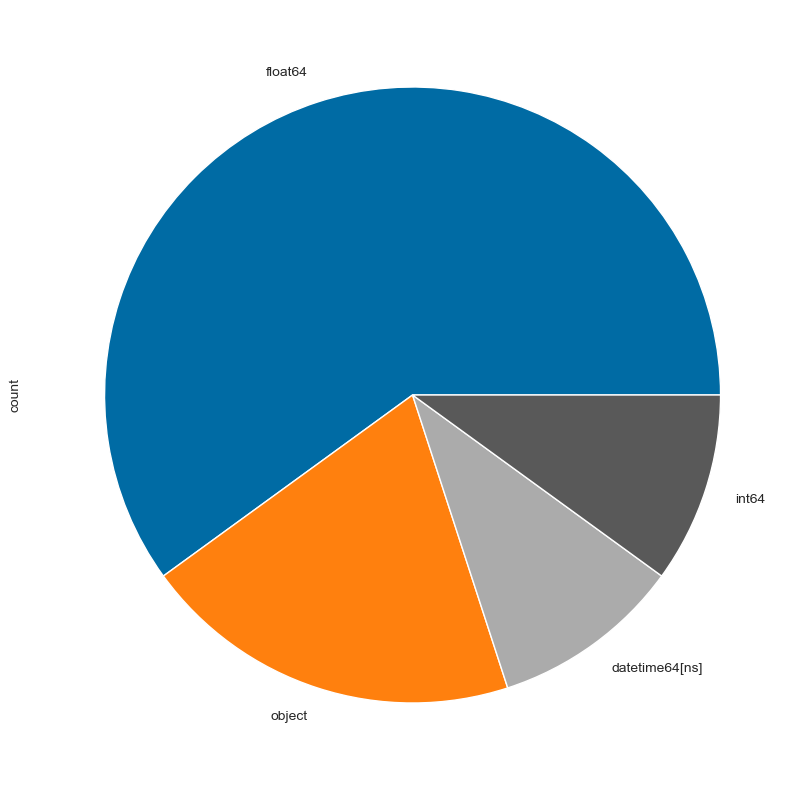

In [119]:
df.dtypes.value_counts().plot.pie()

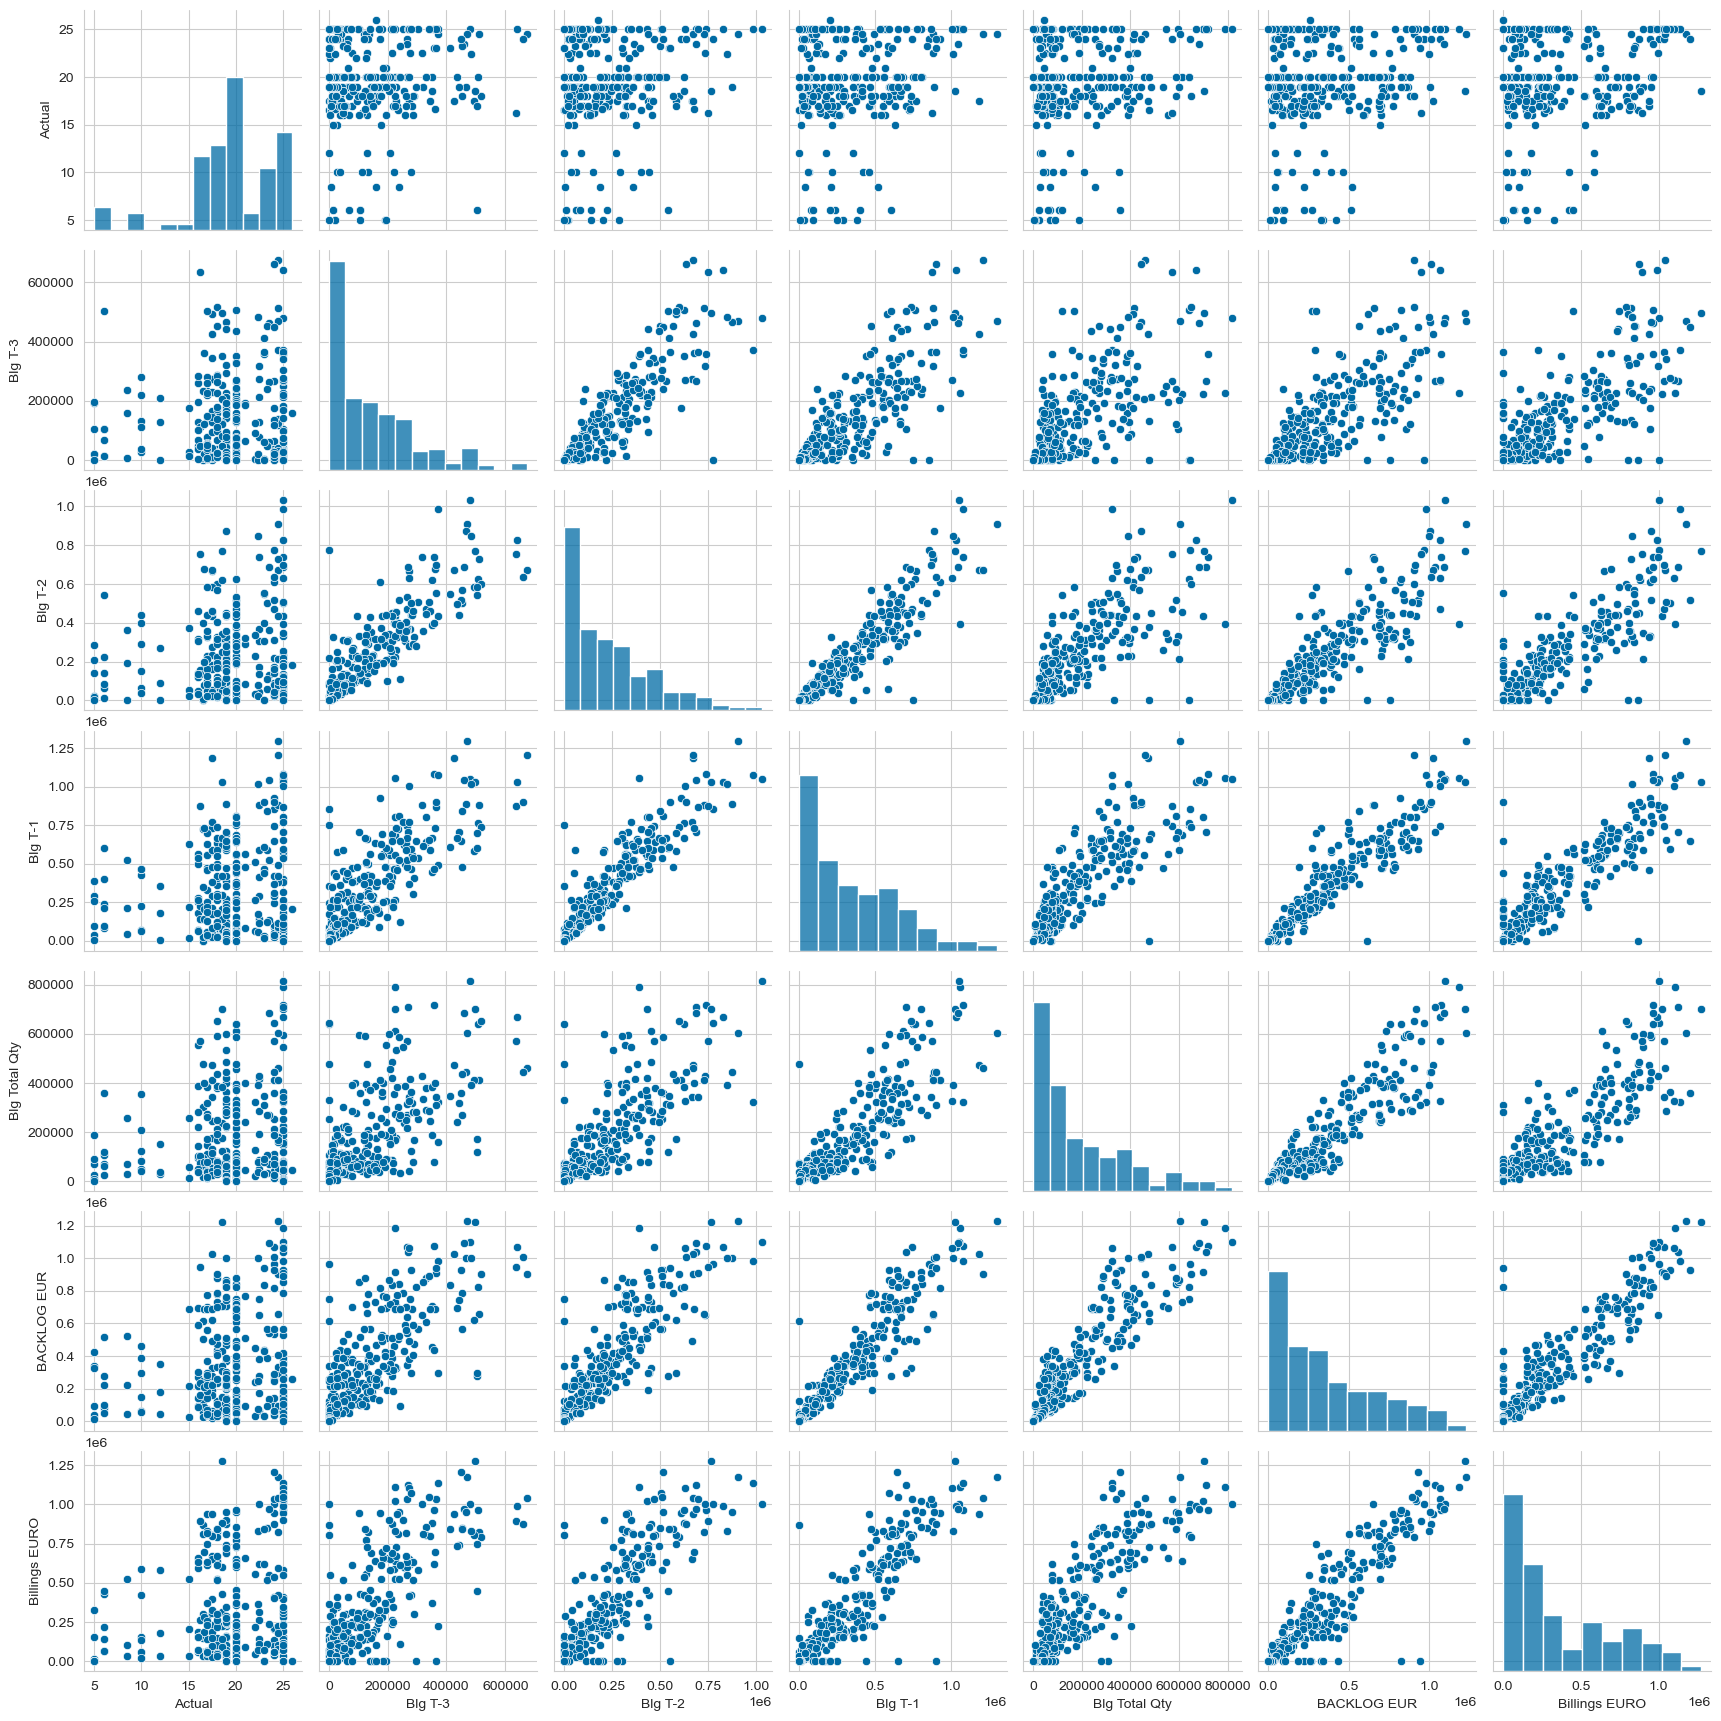

In [120]:
sns.pairplot(df)

<Axes: xlabel='Period'>

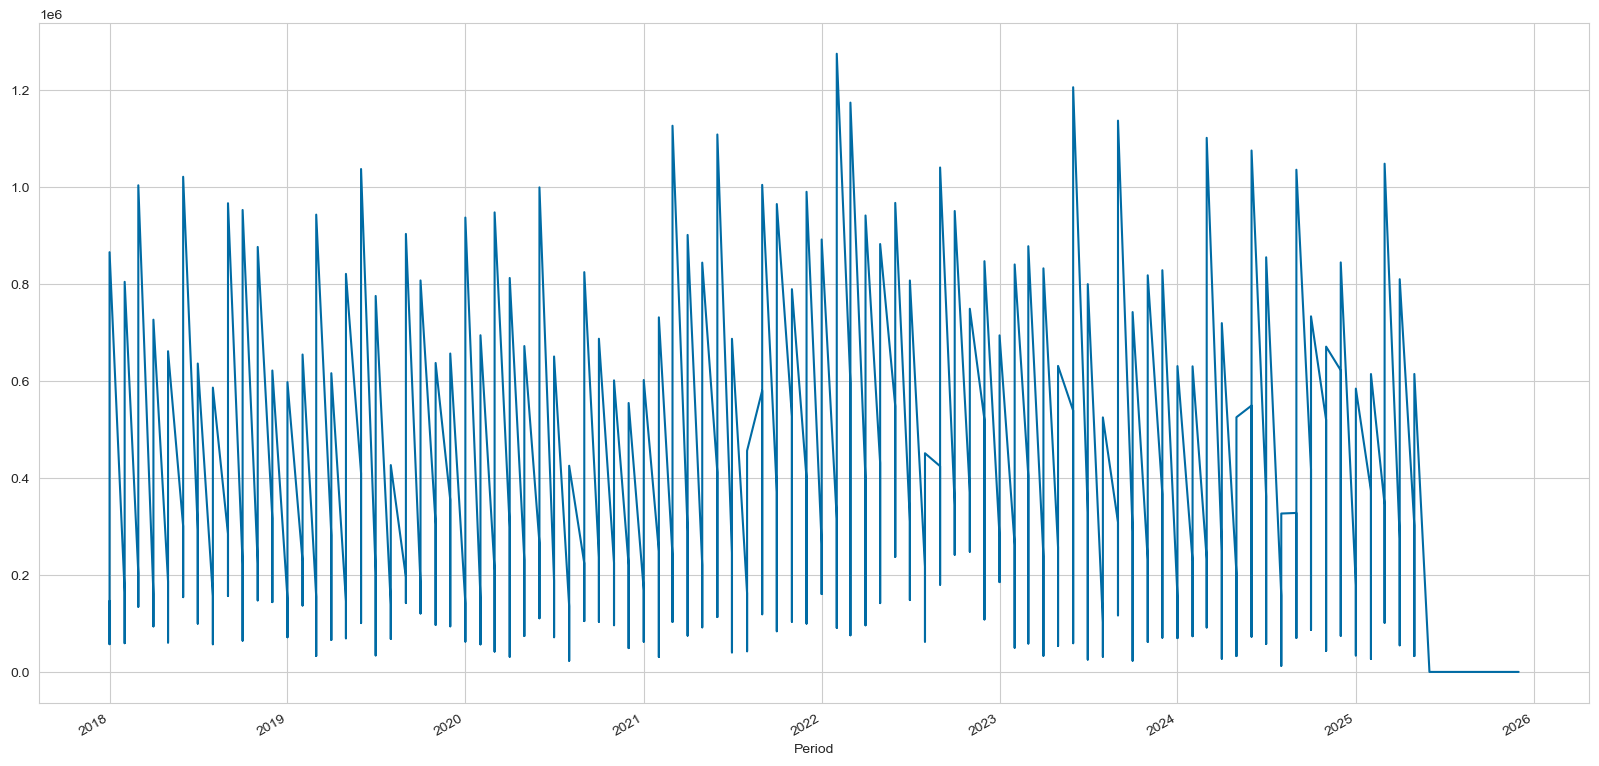

In [121]:
df.set_index('Period')['Billings EURO'].plot()

array([<Axes: xlabel='Period'>, <Axes: xlabel='Period'>,
       <Axes: xlabel='Period'>], dtype=object)

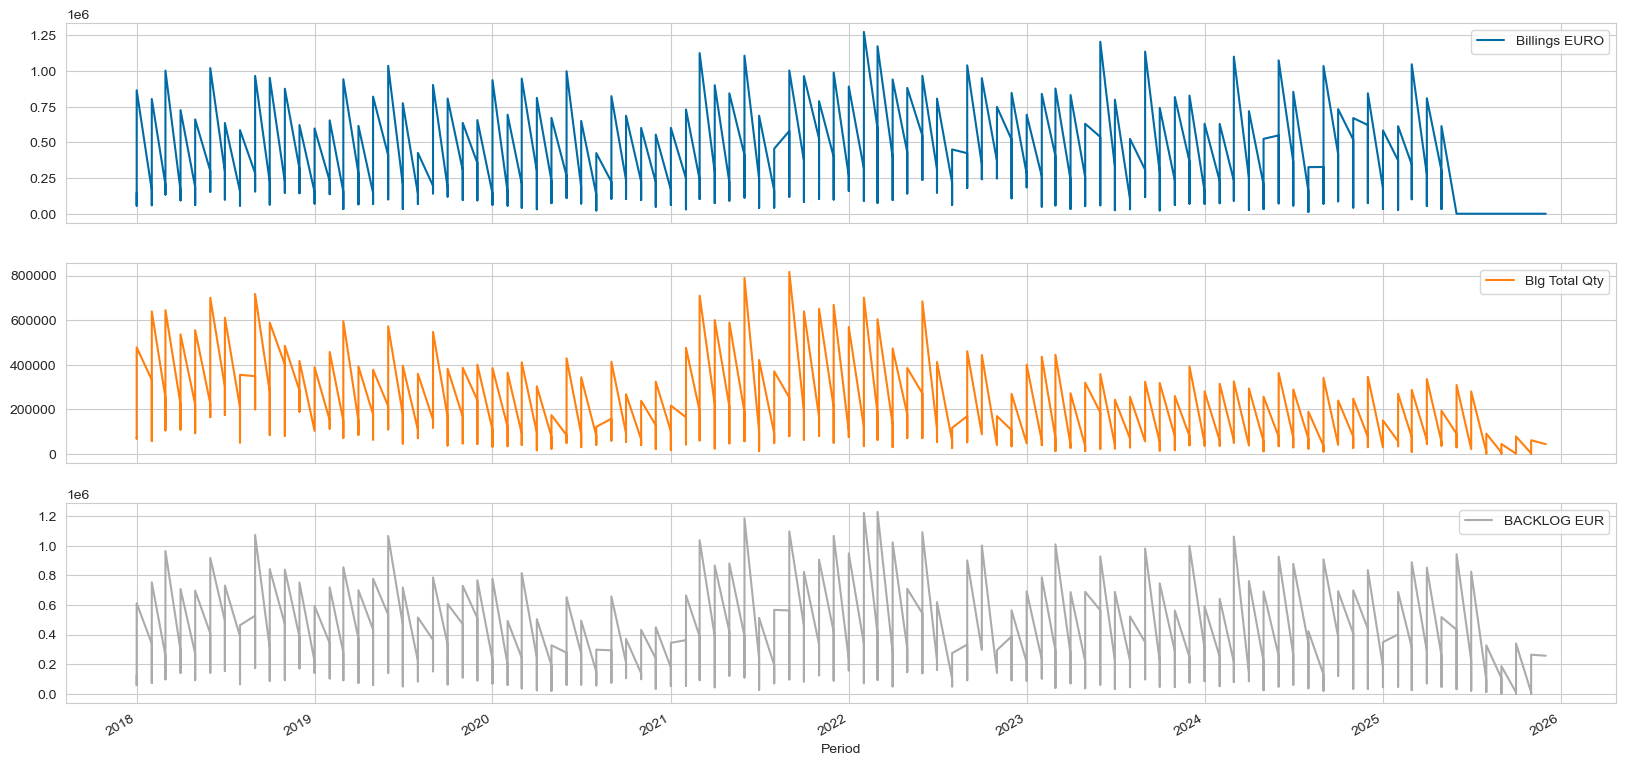

In [122]:
df.set_index('Period')[['Billings EURO','Blg Total Qty','BACKLOG EUR']].plot(subplots=True)

### Pre-processing

In [124]:
df.head(12)

Period Mat/Group   REGION  Actual       Blg T-3        Blg T-2  \
0  2018-01-01       FP1  AMERICA    16.5       0.00000       0.000000   
1  2018-01-01       FP1     ASIA    16.5       0.00000       0.000000   
2  2018-01-01       FP1   EUROPE    16.5       0.00000       0.000000   
3  2018-02-01       FP1  AMERICA    20.0       0.00000       0.000000   
4  2018-02-01       FP1     ASIA    20.0       0.00000       0.000000   
5  2018-02-01       FP1   EUROPE    20.0       0.00000       0.000000   
6  2018-03-01       FP1  AMERICA    24.0       0.00000  220232.949567   
7  2018-03-01       FP1     ASIA    24.0       0.00000   89364.938910   
8  2018-03-01       FP1   EUROPE    24.0       0.00000  777346.796000   
9  2018-04-01       FP1  AMERICA    19.0   62676.83168   78562.945380   
10 2018-04-01       FP1     ASIA    19.0   68819.74073   68987.634170   
11 2018-04-01       FP1   EUROPE    19.0  227507.07780  258324.621800   

          Blg T-1  Blg Total Qty    BACKLOG EUR  Billings EURO  
0        0.000000          74052  124972.939514      146724.09  
1        0.000000          68370   58530.350150       57207.70  
2        0.000000         477846  611863.104000      865229.66  
3   356392.420397         332114  339012.336851      163969.17  
4    74422.044385          57325   72929.288720       59246.39  
5   752167.919460         639487  753058.175800      804159.47  
6   242690.015565         252434  258466.422606      203740.20  
7    88775.946860         105315   97781.805735      134360.26  
8   852948.597000         644975  964501.140270     1003151.76  
9   262337.353020         221355  293540.182180      160359.72  
10  118691.302775         108785  141150.597390       93953.35  
11  470679.459350         536218  707484.026750      726099.41

In [125]:
df['quarter'] = df['Period'].dt.quarter
df['month'] = df['Period'].dt.month
df['year'] = df['Period'].dt.year

df['log_Backlog'] = np.log1p(df['BACKLOG EUR'])
df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

In [126]:
#df=df.drop(['Period','Mat/Group'],axis=1)
#df=df.drop(['Period','Blg T-3','Mat/Group'],axis=1)

In [127]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Initialisation de l'encodeur avec sparse_output=False
encoder = OneHotEncoder(sparse_output=False)

# Encodage de la colonne REGION
encoded_array = encoder.fit_transform(df[['REGION']])

# Récupération des noms de colonnes générés
column_names = encoder.get_feature_names_out(['REGION'])

# ✅ Vérification du format de sortie
print(f"Shape of encoded array: {encoded_array.shape}")  # Doit être (180, 3)
print(f"Feature names: {column_names}")  # Doit être ['REGION_AP', 'REGION_EU', 'REGION_NA']

# ✅ Convertir correctement en DataFrame
df_encoded = pd.DataFrame(encoded_array, columns=column_names, index=df.index)

# ✅ Fusion avec df sans REGION
df = df.drop(columns=['REGION']).join(df_encoded)

Shape of encoded array: (286, 3)
Feature names: ['REGION_AMERICA' 'REGION_ASIA' 'REGION_EUROPE']


In [128]:
df.head()

Period Mat/Group  Actual  Blg T-3  Blg T-2        Blg T-1  \
0 2018-01-01       FP1    16.5      0.0      0.0       0.000000   
1 2018-01-01       FP1    16.5      0.0      0.0       0.000000   
2 2018-01-01       FP1    16.5      0.0      0.0       0.000000   
3 2018-02-01       FP1    20.0      0.0      0.0  356392.420397   
4 2018-02-01       FP1    20.0      0.0      0.0   74422.044385   

   Blg Total Qty    BACKLOG EUR  Billings EURO  quarter  month  year  \
0          74052  124972.939514      146724.09        1      1  2018   
1          68370   58530.350150       57207.70        1      1  2018   
2         477846  611863.104000      865229.66        1      1  2018   
3         332114  339012.336851      163969.17        1      2  2018   
4          57325   72929.288720       59246.39        1      2  2018   

   log_Backlog  quarter_sin   quarter_cos  REGION_AMERICA  REGION_ASIA  \
0    11.735861          1.0  6.123234e-17             1.0          0.0   
1    10.977318          1.0  6.123234e-17             0.0          1.0   
2    13.324265          1.0  6.123234e-17             0.0          0.0   
3    12.733795          1.0  6.123234e-17             1.0          0.0   
4    11.197259          1.0  6.123234e-17             0.0          1.0   

   REGION_EUROPE  
0            0.0  
1            0.0  
2            1.0  
3            0.0  
4            0.0

In [129]:


# Liste des colonnes one-hot pour les régions
region_cols = ['REGION_AMERICA', 'REGION_ASIA', 'REGION_EUROPE']

# Initialisation des colonnes à NaN
df['rolling_mean_sales_3'] = pd.NA
for lag in range(1, 4):
    df[f'sales_diff_t-{lag}'] = pd.NA

# Pour chaque colonne région (encodée)
for region_col in region_cols:
    # On filtre uniquement les lignes où la région est active (1)
    region_mask = df[region_col] == 1

    # Index des lignes concernées
    region_indices = df[region_mask].index

    # On extrait uniquement les lignes concernées, et on les trie par date
    df_region = df.loc[region_indices].sort_values(by='Period')

    # Moyenne mobile avec shift (exclut la valeur courante)
    rolling_mean = df_region['Billings EURO'].shift(1).rolling(window=3).mean()

    # Ajout dans le dataframe d'origine
    df.loc[region_indices, 'rolling_mean_sales_3'] = rolling_mean

    # Ajout des sales_diff_t-1, t-2, t-3
    for lag in range(1, 4):
        diff_series = df_region['Billings EURO'].diff(lag)
        df.loc[region_indices, f'sales_diff_t-{lag}'] = diff_series


In [130]:
df.head(20)

Period Mat/Group  Actual       Blg T-3        Blg T-2        Blg T-1  \
0  2018-01-01       FP1    16.5       0.00000       0.000000       0.000000   
1  2018-01-01       FP1    16.5       0.00000       0.000000       0.000000   
2  2018-01-01       FP1    16.5       0.00000       0.000000       0.000000   
3  2018-02-01       FP1    20.0       0.00000       0.000000  356392.420397   
4  2018-02-01       FP1    20.0       0.00000       0.000000   74422.044385   
5  2018-02-01       FP1    20.0       0.00000       0.000000  752167.919460   
6  2018-03-01       FP1    24.0       0.00000  220232.949567  242690.015565   
7  2018-03-01       FP1    24.0       0.00000   89364.938910   88775.946860   
8  2018-03-01       FP1    24.0       0.00000  777346.796000  852948.597000   
9  2018-04-01       FP1    19.0   62676.83168   78562.945380  262337.353020   
10 2018-04-01       FP1    19.0   68819.74073   68987.634170  118691.302775   
11 2018-04-01       FP1    19.0  227507.07780  258324.621800  470679.459350   
12 2018-05-01       FP1    16.0   47129.25474  120600.114751  274366.893509   
13 2018-05-01       FP1    16.0   36342.45282   50699.617840   68852.364150   
14 2018-05-01       FP1    16.0  195868.05600  317903.655600  565933.505875   
15 2018-06-01       FP1    25.0   57726.22798  137756.664110  398315.157165   
16 2018-06-01       FP1    25.0   41189.73910   53922.131080  100532.577100   
17 2018-06-01       FP1    25.0  223691.90180  434144.930300  804237.332100   
18 2018-07-01       FP1    20.0   46535.32056  310265.338430  450429.497650   
19 2018-07-01       FP1    20.0   22004.47100   90219.933880  145165.863720   

    Blg Total Qty    BACKLOG EUR  Billings EURO  quarter  ...  log_Backlog  \
0           74052  124972.939514      146724.09        1  ...    11.735861   
1           68370   58530.350150       57207.70        1  ...    10.977318   
2          477846  611863.104000      865229.66        1  ...    13.324265   
3          332114  339012.336851      163969.17        1  ...    12.733795   
4           57325   72929.288720       59246.39        1  ...    11.197259   
5          639487  753058.175800      804159.47        1  ...    13.531899   
6          252434  258466.422606      203740.20        1  ...    12.462525   
7          105315   97781.805735      134360.26        1  ...    11.490504   
8          644975  964501.140270     1003151.76        1  ...    13.779367   
9          221355  293540.182180      160359.72        2  ...    12.589773   
10         108785  141150.597390       93953.35        2  ...    11.857590   
11         536218  707484.026750      726099.41        2  ...    13.469472   
12         221043  271896.510656      186699.06        2  ...    12.513180   
13          92350   92601.135290       60687.24        2  ...    11.436067   
14         555095  696939.313165      661092.77        2  ...    13.454455   
15         225595  407737.119710      300435.21        2  ...    12.918380   
16         164200  142394.045200      154144.82        2  ...    11.866360   
17         700682  918202.867545     1020725.45        2  ...    13.730175   
18         300470  492583.787725      292506.16        3  ...    13.107422   
19         174580  153693.672980       99687.26        3  ...    11.942723   

     quarter_sin   quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
0   1.000000e+00  6.123234e-17             1.0          0.0            0.0   
1   1.000000e+00  6.123234e-17             0.0          1.0            0.0   
2   1.000000e+00  6.123234e-17             0.0          0.0            1.0   
3   1.000000e+00  6.123234e-17             1.0          0.0            0.0   
4   1.000000e+00  6.123234e-17             0.0          1.0            0.0   
5   1.000000e+00  6.123234e-17             0.0          0.0            1.0   
6   1.000000e+00  6.123234e-17             1.0          0.0            0.0   
7   1.000000e+00  6.123234e-17             0.0          1.0            0.0   
8   1.

In [131]:
# Liste des dates à exclure
dates_to_drop = pd.to_datetime(['2018-01-01', '2018-02-01', '2018-03-01'])

# On filtre les lignes à garder (donc celles dont Period n'est pas dans dates_to_drop)
df = df[~df['Period'].isin(dates_to_drop)]


df=df.drop(['Period','Mat/Group'],axis=1)
#df=df.drop(['Period','Blg T-3','Mat/Group'],axis=1)



In [132]:
df.head(9)

Actual       Blg T-3        Blg T-2        Blg T-1  Blg Total Qty  \
9     19.0   62676.83168   78562.945380  262337.353020         221355   
10    19.0   68819.74073   68987.634170  118691.302775         108785   
11    19.0  227507.07780  258324.621800  470679.459350         536218   
12    16.0   47129.25474  120600.114751  274366.893509         221043   
13    16.0   36342.45282   50699.617840   68852.364150          92350   
14    16.0  195868.05600  317903.655600  565933.505875         555095   
15    25.0   57726.22798  137756.664110  398315.157165         225595   
16    25.0   41189.73910   53922.131080  100532.577100         164200   
17    25.0  223691.90180  434144.930300  804237.332100         700682   

      BACKLOG EUR  Billings EURO  quarter  month  year  log_Backlog  \
9   293540.182180      160359.72        2      4  2018    12.589773   
10  141150.597390       93953.35        2      4  2018    11.857590   
11  707484.026750      726099.41        2      4  2018    13.469472   
12  271896.510656      186699.06        2      5  2018    12.513180   
13   92601.135290       60687.24        2      5  2018    11.436067   
14  696939.313165      661092.77        2      5  2018    13.454455   
15  407737.119710      300435.21        2      6  2018    12.918380   
16  142394.045200      154144.82        2      6  2018    11.866360   
17  918202.867545     1020725.45        2      6  2018    13.730175   

     quarter_sin  quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
9   1.224647e-16         -1.0             1.0          0.0            0.0   
10  1.224647e-16         -1.0             0.0          1.0            0.0   
11  1.224647e-16         -1.0             0.0          0.0            1.0   
12  1.224647e-16         -1.0             1.0          0.0            0.0   
13  1.224647e-16         -1.0             0.0          1.0            0.0   
14  1.224647e-16         -1.0             0.0          0.0            1.0   
15  1.224647e-16         -1.0             1.0          0.0            0.0   
16  1.224647e-16         -1.0             0.0          1.0            0.0   
17  1.224647e-16         -1.0             0.0          0.0            1.0   

   rolling_mean_sales_3 sales_diff_t-1 sales_diff_t-2 sales_diff_t-3  
9             171477.82      -43380.48       -3609.45       13635.63  
10         83604.783333      -40406.91       34706.96       36745.65  
11        890846.963333     -277052.35      -78060.06     -139130.25  
12            176023.03       26339.34      -17041.14       22729.89  
13         95853.333333      -33266.11      -73673.02        1440.85  
14        844470.213333      -65006.64     -342058.99      -143066.7  
15            183599.66      113736.15      140075.49       96695.01  
16         96333.616667       93457.58       60191.47       19784.56  
17        796781.313333      359632.68      294626.04       17573.69

In [133]:
# Identifier les colonnes de type object
object_cols = df.select_dtypes(include='object').columns

# Les convertir en float64
df[object_cols] = df[object_cols].apply(pd.to_numeric, errors='coerce').astype('float64')

In [134]:
df.dtypes

Actual                  float64
Blg T-3                 float64
Blg T-2                 float64
Blg T-1                 float64
Blg Total Qty             int64
BACKLOG EUR             float64
Billings EURO           float64
quarter                   int32
month                     int32
year                      int32
log_Backlog             float64
quarter_sin             float64
quarter_cos             float64
REGION_AMERICA          float64
REGION_ASIA             float64
REGION_EUROPE           float64
rolling_mean_sales_3    float64
sales_diff_t-1          float64
sales_diff_t-2          float64
sales_diff_t-3          float64
dtype: object

#### To change

In [136]:
df_train=df[df['year'] < previous_year]
X_train=df_train.drop(['Billings EURO'],axis=1)
y_train=df_train['Billings EURO']

In [137]:
df_test = df[((df['year'] == previous_year)) | ((df['year'] == year) & (df['month'] < MTD_test))]

X_test=df_test.drop(['Billings EURO'],axis=1)
y_test=df_test['Billings EURO']

In [138]:
df_test.shape

(51, 20)

In [139]:
df_test.head(5)

Actual        Blg T-3       Blg T-2        Blg T-1  Blg Total Qty  \
216    16.0  103262.548500  134544.69801  264654.616685          48282   
217    16.0    3144.578500   35142.75483   63449.912110          36655   
218    16.0  284771.060000  459159.23280  538477.927560         280073   
219    20.0   76448.481952   54173.80114  211889.630963          58726   
220    20.0   45074.186485   42142.22154   50388.068545          36325   

       BACKLOG EUR  Billings EURO  quarter  month  year  log_Backlog  \
216  304582.347680      156307.68        1      1  2024    12.626700   
217   85105.163640       69710.28        1      1  2024    11.351655   
218  589924.763120      630414.15        1      1  2024    13.287752   
219  250060.154319      228863.66        1      2  2024    12.429461   
220   51472.876855       73633.40        1      2  2024    10.848830   

     quarter_sin   quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
216          1.0  6.123234e-17             1.0          0.0            0.0   
217          1.0  6.123234e-17             0.0          1.0            0.0   
218          1.0  6.123234e-17             0.0          0.0            1.0   
219          1.0  6.123234e-17             1.0          0.0            0.0   
220          1.0  6.123234e-17             0.0          1.0            0.0   

     rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  
216         295576.486667      -209996.38       -75148.71      -132661.33  
217          51994.436667         -985.38         7727.05        46405.86  
218         795833.456667      -197671.30      -187185.21      -111401.41  
219         251356.043333        72555.98      -137440.40        -2592.73  
220          67463.056667         3923.12         2937.74        11650.17

In [140]:
df_test.columns

Index(['Actual', 'Blg T-3', 'Blg T-2', 'Blg T-1', 'Blg Total Qty',
       'BACKLOG EUR', 'Billings EURO', 'quarter', 'month', 'year',
       'log_Backlog', 'quarter_sin', 'quarter_cos', 'REGION_AMERICA',
       'REGION_ASIA', 'REGION_EUROPE', 'rolling_mean_sales_3',
       'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3'],
      dtype='object')

In [141]:
from sklearn.preprocessing import StandardScaler

# Sélection des colonnes numériques à standardiser

  # 'Billings EURO' est la cible, donc on ne la touche pas

#numeric_cols = ['Blg T-1','BACKLOG EUR', 'Blg Total Qty']
#numeric_cols = ['Blg T-2','Blg T-1','BACKLOG EUR', 'Blg Total Qty']
#numeric_cols = ['Blg T-3','Blg T-2','Blg T-1','Blg Total Qty', 'BACKLOG EUR','rolling_mean_sales_3',
       #'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']
# Initialisation du scaler
#scaler = StandardScaler()

# Standardisation des données d'entraînement et de test
#X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
#X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [142]:
X_train.shape,X_test.shape

((207, 19), (51, 19))

In [143]:
X_train.head(5)

Actual       Blg T-3        Blg T-2        Blg T-1  Blg Total Qty  \
9     19.0   62676.83168   78562.945380  262337.353020         221355   
10    19.0   68819.74073   68987.634170  118691.302775         108785   
11    19.0  227507.07780  258324.621800  470679.459350         536218   
12    16.0   47129.25474  120600.114751  274366.893509         221043   
13    16.0   36342.45282   50699.617840   68852.364150          92350   

      BACKLOG EUR  quarter  month  year  log_Backlog   quarter_sin  \
9   293540.182180        2      4  2018    12.589773  1.224647e-16   
10  141150.597390        2      4  2018    11.857590  1.224647e-16   
11  707484.026750        2      4  2018    13.469472  1.224647e-16   
12  271896.510656        2      5  2018    12.513180  1.224647e-16   
13   92601.135290        2      5  2018    11.436067  1.224647e-16   

    quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
9          -1.0             1.0          0.0            0.0   
10         -1.0             0.0          1.0            0.0   
11         -1.0             0.0          0.0            1.0   
12         -1.0             1.0          0.0            0.0   
13         -1.0             0.0          1.0            0.0   

    rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  
9          171477.820000       -43380.48        -3609.45        13635.63  
10          83604.783333       -40406.91        34706.96        36745.65  
11         890846.963333      -277052.35       -78060.06      -139130.25  
12         176023.030000        26339.34       -17041.14        22729.89  
13          95853.333333       -33266.11       -73673.02         1440.85

In [144]:
X_train.dtypes

Actual                  float64
Blg T-3                 float64
Blg T-2                 float64
Blg T-1                 float64
Blg Total Qty             int64
BACKLOG EUR             float64
quarter                   int32
month                     int32
year                      int32
log_Backlog             float64
quarter_sin             float64
quarter_cos             float64
REGION_AMERICA          float64
REGION_ASIA             float64
REGION_EUROPE           float64
rolling_mean_sales_3    float64
sales_diff_t-1          float64
sales_diff_t-2          float64
sales_diff_t-3          float64
dtype: object

In [145]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)

In [146]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  68049.323673
MAE :  48572.903588


In [147]:
from sklearn.metrics import mean_absolute_error as MAE
import numpy as np

mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 12.85%


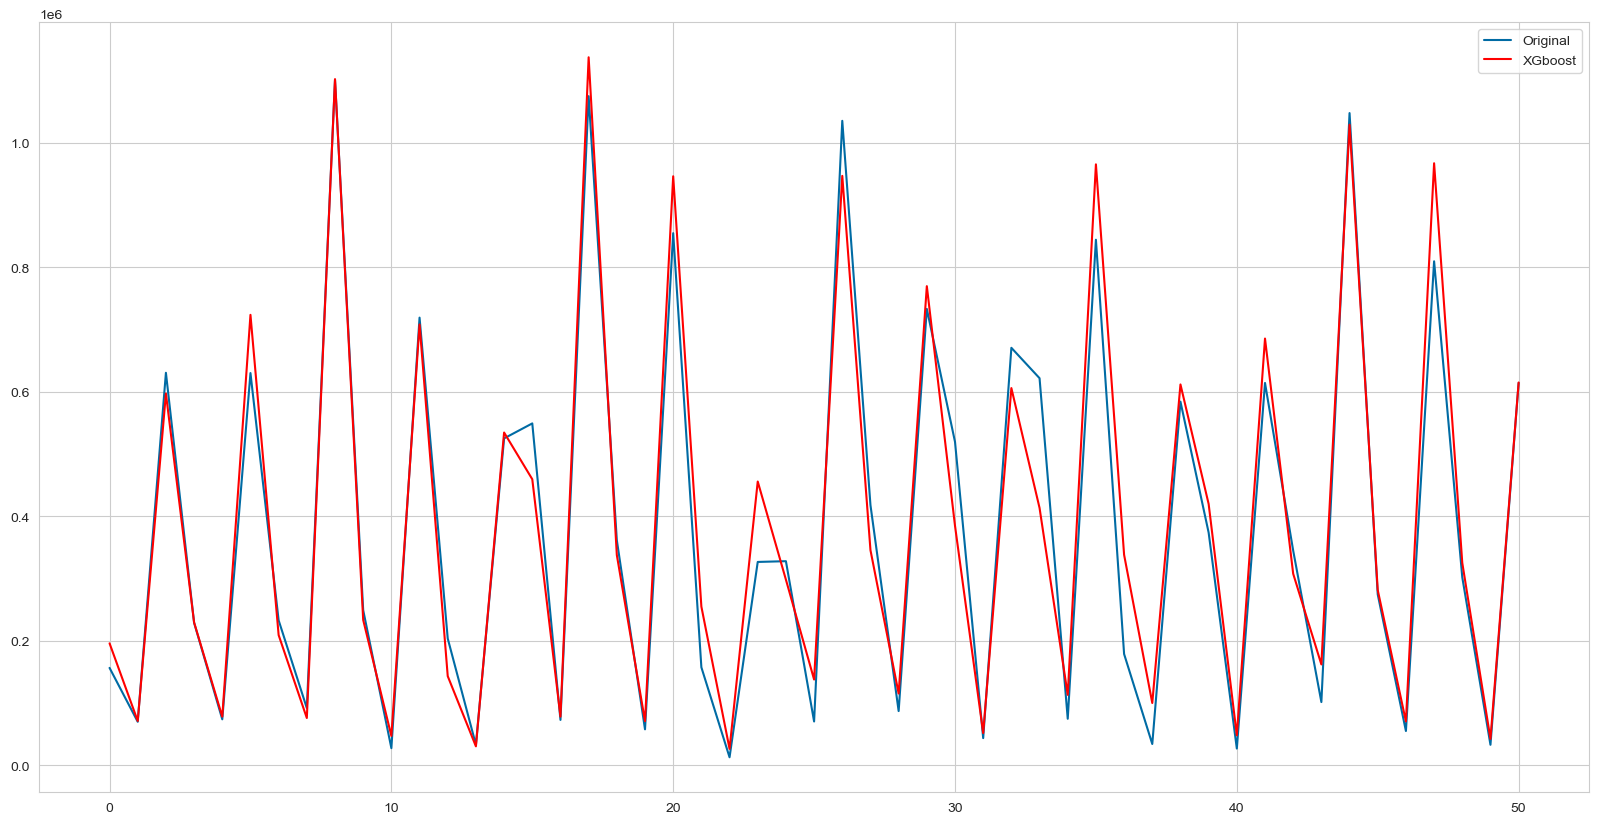

In [148]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [149]:
# Conversion de y_test et yhat en DataFrame avec les mêmes index que X_test
df_results = X_test.copy()  # Copie X_test pour ne pas modifier l'original
df_results["Valeur Réelle"] = y_test.values  # Ajout de y_test
df_results["Prédiction"] = yhat  # Ajout des prédictions

In [150]:
# Affichage des premières lignes
df_results.head()

Actual        Blg T-3       Blg T-2        Blg T-1  Blg Total Qty  \
216    16.0  103262.548500  134544.69801  264654.616685          48282   
217    16.0    3144.578500   35142.75483   63449.912110          36655   
218    16.0  284771.060000  459159.23280  538477.927560         280073   
219    20.0   76448.481952   54173.80114  211889.630963          58726   
220    20.0   45074.186485   42142.22154   50388.068545          36325   

       BACKLOG EUR  quarter  month  year  log_Backlog  ...   quarter_cos  \
216  304582.347680        1      1  2024    12.626700  ...  6.123234e-17   
217   85105.163640        1      1  2024    11.351655  ...  6.123234e-17   
218  589924.763120        1      1  2024    13.287752  ...  6.123234e-17   
219  250060.154319        1      2  2024    12.429461  ...  6.123234e-17   
220   51472.876855        1      2  2024    10.848830  ...  6.123234e-17   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  rolling_mean_sales_3  \
216             1.0          0.0            0.0         295576.486667   
217             0.0          1.0            0.0          51994.436667   
218             0.0          0.0            1.0         795833.456667   
219             1.0          0.0            0.0         251356.043333   
220             0.0          1.0            0.0          67463.056667   

     sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  Valeur Réelle  \
216      -209996.38       -75148.71      -132661.33      156307.68   
217         -985.38         7727.05        46405.86       69710.28   
218      -197671.30      -187185.21      -111401.41      630414.15   
219        72555.98      -137440.40        -2592.73      228863.66   
220         3923.12         2937.74        11650.17       73633.40   

        Prédiction  
216  195746.562500  
217   71010.265625  
218  597167.000000  
219  229282.078125  
220   77916.882812  

[5 rows x 21 columns]

In [151]:
from sklearn.model_selection import RandomizedSearchCV


# Définition des hyperparamètres avec un plus grand espace de recherche
params = {
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [i / 10.0 for i in range(0, 8)],
    'subsample': [i / 10.0 for i in range(5, 11)],
    'colsample_bytree': [i / 10.0 for i in range(5, 11)],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Ajout du learning rate
    'n_estimators': [100, 500, 1000, 2000]  # Augmentation du nombre d'arbres
}

# Initialisation de XGBoost
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

# RandomizedSearchCV pour un tuning plus rapide
random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, 
                                   n_iter=30, cv=5, verbose=1, n_jobs=-1)

# Entraînement du modèle optimisé
random_search.fit(X_train, y_train)

# Meilleur modèle trouvé
best_xgb = random_search.best_estimator_
print("Meilleur score R2 :", r2_score(y_test, best_xgb.predict(X_test)))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleur score R2 : 0.9749718981316682


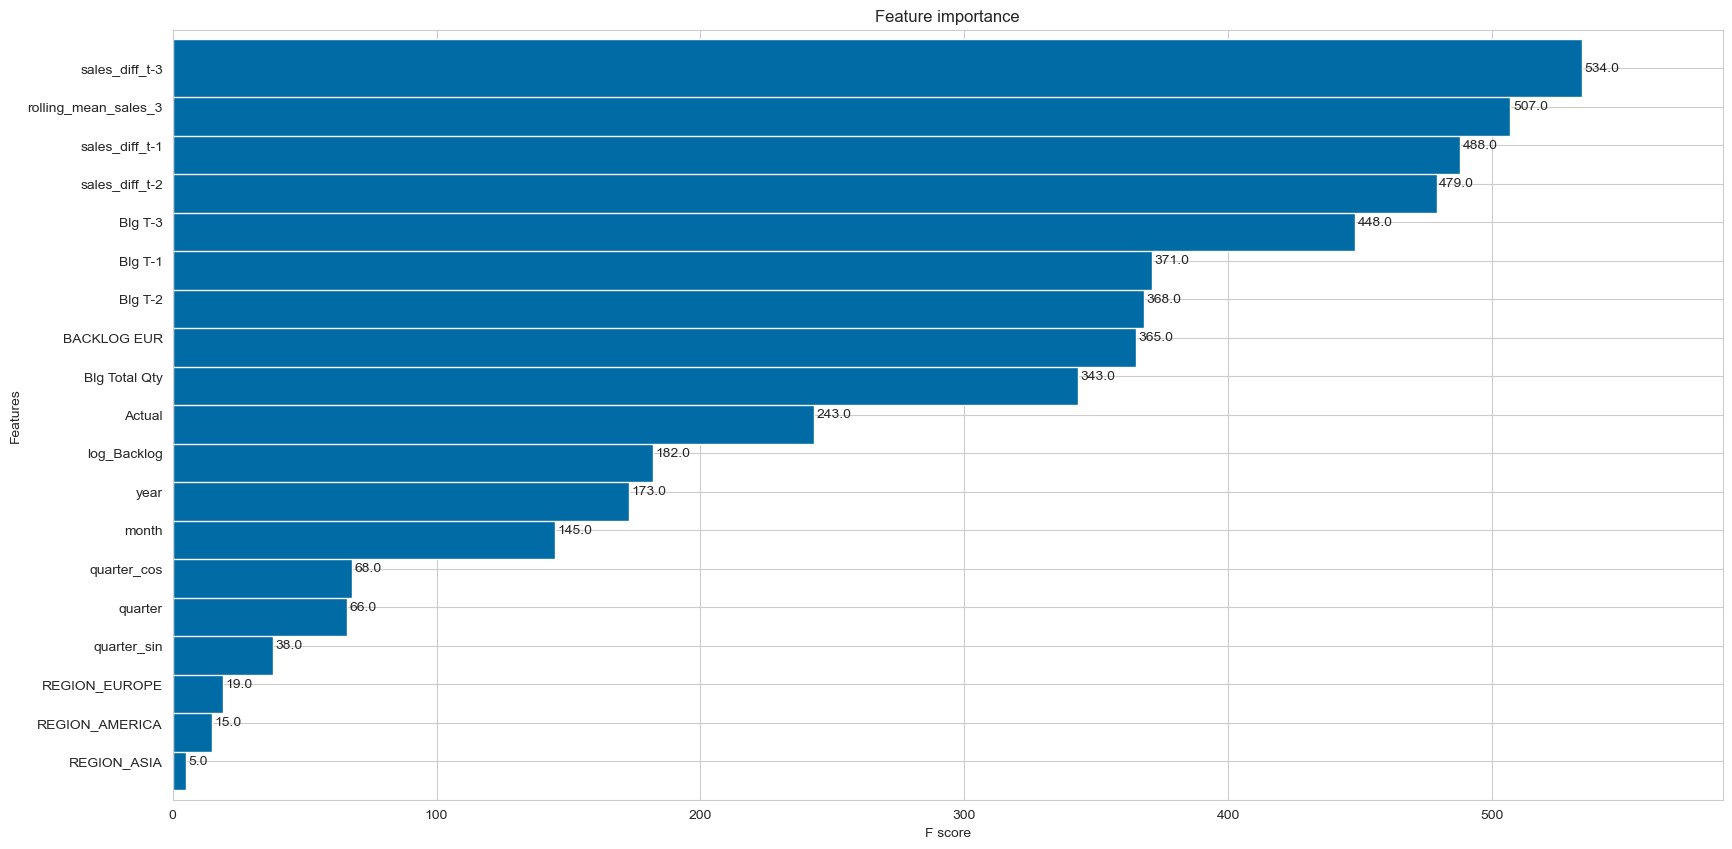

In [152]:
_ = plot_importance(best_xgb, height=1.5)

In [153]:
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [154]:
yhat = random_search.predict(X_test)
rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  50894.143272
MAE :  38148.835355


In [155]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 10.09%


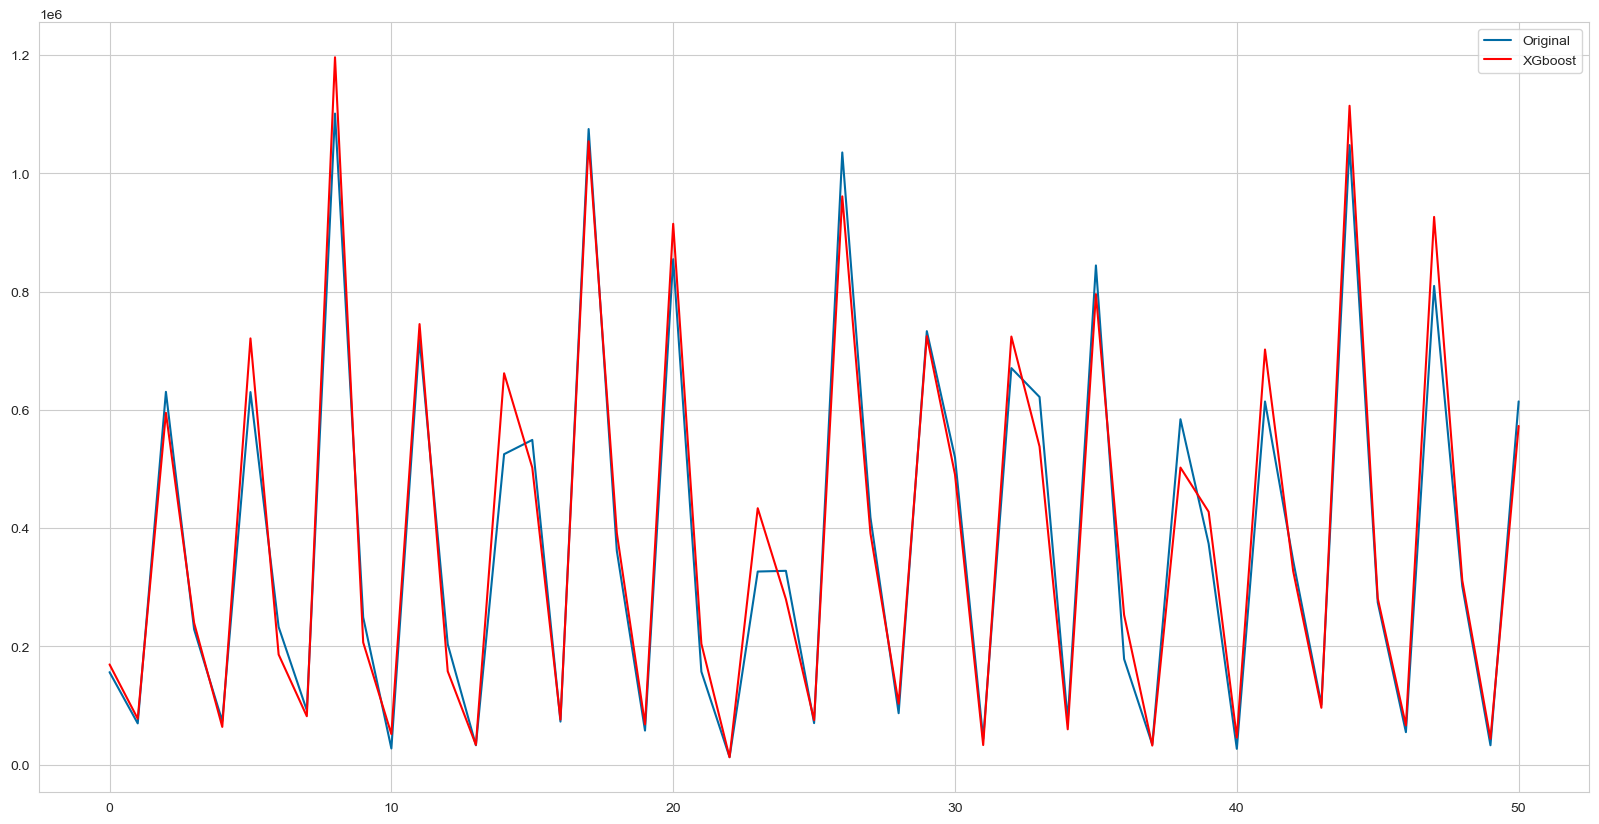

In [156]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

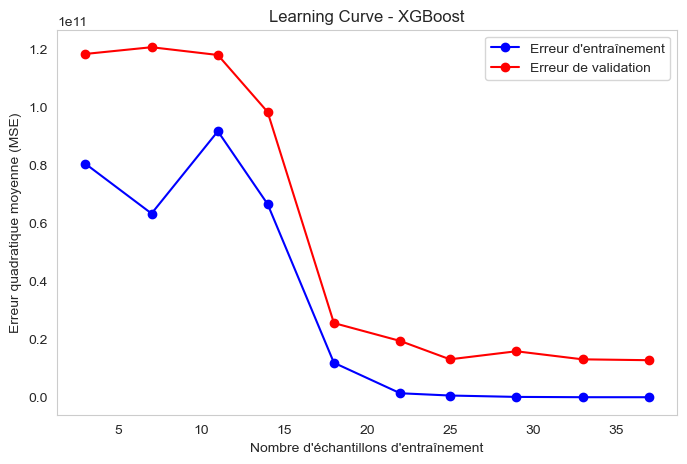

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Définition des splits temporels
tscv = TimeSeriesSplit(n_splits=5)

# Calcul de la learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Conversion en erreurs positives (MSE)
train_errors = -train_scores.mean(axis=1)
val_errors = -val_scores.mean(axis=1)

# Affichage des courbes
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors, "o-", label="Erreur d'entraînement", color="blue")
plt.plot(train_sizes, val_errors, "o-", label="Erreur de validation", color="red")

plt.xlabel("Nombre d'échantillons d'entraînement")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Learning Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()

In [158]:
import optuna
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.model_selection import train_test_split

# Fonction d'optimisation avec Optuna
def objective(trial):
    # Espace de recherche des hyperparamètres
    params = {
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.7, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 500, 1000, 2000]),
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }

    # Initialisation du modèle
    xgb_reg = xgb.XGBRegressor(**params)

    # Entraînement du modèle
    xgb_reg.fit(X_train, y_train)

    # Prédictions sur le test set
    y_pred = xgb_reg.predict(X_test)

    # Calcul du RMSE
    rmse = np.sqrt(MSE(y_test, y_pred))

    return rmse  # On minimise le RMSE

# Lancement de l'optimisation avec Optuna
study = optuna.create_study(direction="minimize")  # Minimiser le RMSE
study.optimize(objective, n_trials=30)

# Meilleurs hyperparamètres trouvés
best_params = study.best_params
print("Meilleurs hyperparamètres :", best_params)

# Reconstruction du meilleur modèle avec les hyperparamètres optimaux
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

# Prédictions finales
yhat = best_xgb.predict(X_test)

[I 2025-06-06 11:09:28,294] A new study created in memory with name: no-name-d590b7ce-af2d-4e9d-8b13-3df45cabd9cb
C:\Users\rtekem\AppData\Local\Temp\ipykernel_19072\951080644.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
[I 2025-06-06 11:09:29,097] Trial 0 finished with value: 52674.892307034446 and parameters: {'min_child_weight': 6, 'gamma': 0.30000000000000004, 'subsample': 0.9, 'colsample_bytree': 0.9, 'max_depth': 4, 'learning_rate': 0.027509735320973557, 'n_estimators': 1000}. Best is trial 0 with value: 52674.892307034446.
C:\Users\rtekem\AppData\Local\Temp\ipykernel_19072\951080644.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

Meilleurs hyperparamètres : {'min_child_weight': 2, 'gamma': 0.0, 'subsample': 0.5, 'colsample_bytree': 0.8, 'max_depth': 7, 'learning_rate': 0.1387660242395284, 'n_estimators': 1000}


In [159]:
# Évaluation du modèle optimisé
rmse = np.sqrt(MSE(y_test, yhat))
r2 = r2_score(y_test, yhat)

print("Meilleur score R2 :", r2)
print("RMSE : % f" % (rmse))

Meilleur score R2 : 0.9803744311246141
RMSE :  45067.656779


In [160]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 8.73%


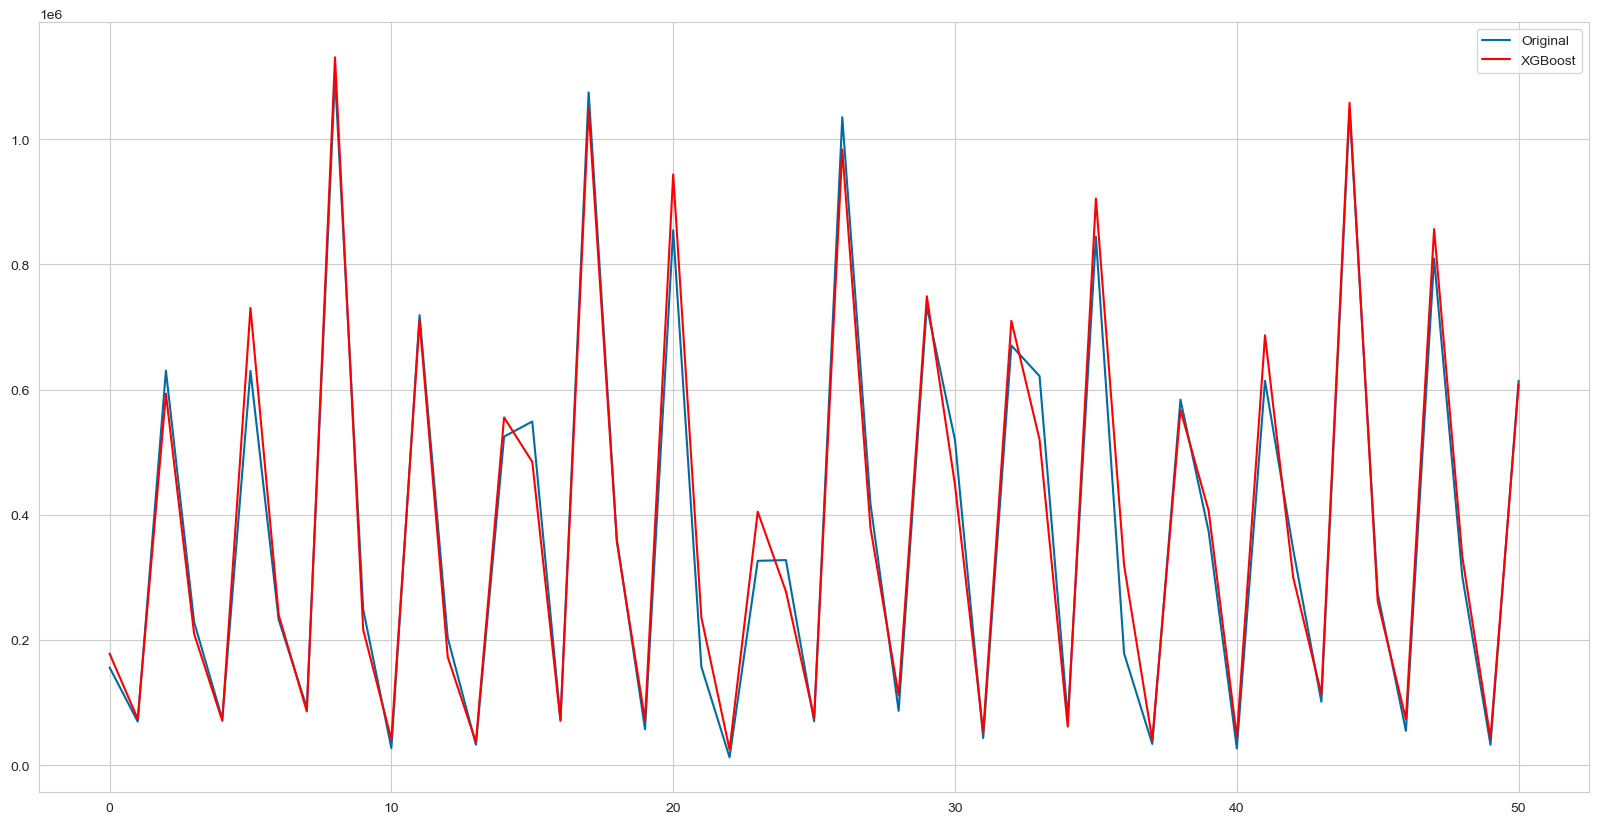

In [161]:
# Affichage des résultats
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost')
plt.legend()
plt.show()

In [162]:
import pandas as pd

# S'assurer que y_test est une Series (si ce n'est pas le cas)
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.squeeze()

# Création du DataFrame des résultats
results_df1 = X_test.copy()  # On part de X_test
results_df1['y_test'] = y_test.values
results_df1['yhat'] = yhat


In [163]:
results_df1.shape

(51, 21)

In [164]:
# renommer les colonnes y_test en Billings EURO et yhat en predicted_Billings dans ton DataFrame results_df1

results_df1 = results_df1.rename(columns={
    'y_test': 'Billings EURO',
    'yhat': 'predicted_Billings'
})


In [165]:
# Affichage des premières lignes
results_df1.tail(10)

Actual       Blg T-3       Blg T-2        Blg T-1  Blg Total Qty  \
257    20.0  243079.95000  387091.61000  646414.772005         268969   
258    25.0  218382.44146  190649.07990  218092.784890          75175   
259    25.0    3582.92900    1857.10200   19859.053700           8790   
260    25.0  339575.66000  509572.40600  653095.854400         286746   
261    19.0   94835.14832  165029.46099  216008.464722          60985   
262    19.0    4825.39365    5163.42340   45530.256000          44360   
263    19.0  320192.14000  360350.00000  614024.607500         335313   
264    18.0  139956.87673  168000.97341  290053.398635          53400   
265    18.0   23140.40060   85817.02235   92156.383600          36520   
266    18.0  178012.40250  318394.70000  552770.988000         193262   

       BACKLOG EUR  quarter  month  year  log_Backlog  ...   quarter_cos  \
257  687835.472220        1      2  2025    13.441306  ...  6.123234e-17   
258  313586.910510        1      3  2025    12.655835  ...  6.123234e-17   
259   24530.320580        1      3  2025    10.107706  ...  6.123234e-17   
260  889516.924980        1      3  2025    13.698435  ...  6.123234e-17   
261  289221.899230        2      4  2025    12.574953  ... -1.000000e+00   
262   70540.561870        2      4  2025    11.163957  ... -1.000000e+00   
263  852937.224000        2      4  2025    13.656442  ... -1.000000e+00   
264  257823.309372        2      5  2025    12.460034  ... -1.000000e+00   
265   47211.942990        2      5  2025    10.762423  ... -1.000000e+00   
266  518222.310000        2      5  2025    13.158162  ... -1.000000e+00   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  rolling_mean_sales_3  \
257             0.0          0.0            1.0         699579.796667   
258             1.0          0.0            0.0         391286.076667   
259             0.0          1.0            0.0          45081.000000   
260             0.0          0.0            1.0         680754.906667   
261             1.0          0.0            0.0         298946.923333   
262             0.0          1.0            0.0          54034.260000   
263             0.0          0.0            1.0         748588.516667   
264             1.0          0.0            0.0         330878.266667   
265             0.0          1.0            0.0          61002.283333   
266             0.0          0.0            1.0         823760.213333   

     sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  Billings EURO  \
257        30060.83      -230097.40       -56474.67      614076.05   
258       -28915.18       166101.75      -277017.46      344675.78   
259        74693.35        67402.40        26859.78      101399.51   
260       433598.23       463659.06       203500.83     1047674.28   
261       -70307.72       -99222.90        95794.03      274368.06   
262       -46498.33        28195.02        20904.07       54901.18   
263      -238143.97       195454.26       225515.09      809530.31   
264        27381.11       -42926.61       -71841.79      301749.17   
265       -22160.39       -68658.72         6034.63       32740.79   
266      -195343.97      -433487.94          110.29      614186.34   

     predicted_Billings  
257        6.867957e+05  
258        3.001794e+05  
259        1.135824e+05  
260        1.058373e+06  
261        2.611680e+05  
262        7.338627e+04  
263        8.564334e+05  
264        3.335496e+05  
265        4.274835e+04  
266        6.081336e+05  

[10 rows x 21 columns]

#### To change

#### To change

In [168]:
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler

# 1. Séparer les données
df_train = df[df['year'] < previous_year].copy()
df_test = df[(df['year'] >= previous_year)].copy()

X_train = df_train.drop(['Billings EURO'], axis=1)
y_train = df_train['Billings EURO']



In [169]:
X_train.head(5)

Actual       Blg T-3        Blg T-2        Blg T-1  Blg Total Qty  \
9     19.0   62676.83168   78562.945380  262337.353020         221355   
10    19.0   68819.74073   68987.634170  118691.302775         108785   
11    19.0  227507.07780  258324.621800  470679.459350         536218   
12    16.0   47129.25474  120600.114751  274366.893509         221043   
13    16.0   36342.45282   50699.617840   68852.364150          92350   

      BACKLOG EUR  quarter  month  year  log_Backlog   quarter_sin  \
9   293540.182180        2      4  2018    12.589773  1.224647e-16   
10  141150.597390        2      4  2018    11.857590  1.224647e-16   
11  707484.026750        2      4  2018    13.469472  1.224647e-16   
12  271896.510656        2      5  2018    12.513180  1.224647e-16   
13   92601.135290        2      5  2018    11.436067  1.224647e-16   

    quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
9          -1.0             1.0          0.0            0.0   
10         -1.0             0.0          1.0            0.0   
11         -1.0             0.0          0.0            1.0   
12         -1.0             1.0          0.0            0.0   
13         -1.0             0.0          1.0            0.0   

    rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  
9          171477.820000       -43380.48        -3609.45        13635.63  
10          83604.783333       -40406.91        34706.96        36745.65  
11         890846.963333      -277052.35       -78060.06      -139130.25  
12         176023.030000        26339.34       -17041.14        22729.89  
13          95853.333333       -33266.11       -73673.02         1440.85

In [170]:
# 2. Standardisation
#numeric_cols = ['Blg T-3','Blg T-2','Blg T-1','Blg Total Qty', 'BACKLOG EUR',
                #'rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']

#scaler = StandardScaler()
#X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

In [171]:
X_train.head(5)

Actual       Blg T-3        Blg T-2        Blg T-1  Blg Total Qty  \
9     19.0   62676.83168   78562.945380  262337.353020         221355   
10    19.0   68819.74073   68987.634170  118691.302775         108785   
11    19.0  227507.07780  258324.621800  470679.459350         536218   
12    16.0   47129.25474  120600.114751  274366.893509         221043   
13    16.0   36342.45282   50699.617840   68852.364150          92350   

      BACKLOG EUR  quarter  month  year  log_Backlog   quarter_sin  \
9   293540.182180        2      4  2018    12.589773  1.224647e-16   
10  141150.597390        2      4  2018    11.857590  1.224647e-16   
11  707484.026750        2      4  2018    13.469472  1.224647e-16   
12  271896.510656        2      5  2018    12.513180  1.224647e-16   
13   92601.135290        2      5  2018    11.436067  1.224647e-16   

    quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
9          -1.0             1.0          0.0            0.0   
10         -1.0             0.0          1.0            0.0   
11         -1.0             0.0          0.0            1.0   
12         -1.0             1.0          0.0            0.0   
13         -1.0             0.0          1.0            0.0   

    rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  
9          171477.820000       -43380.48        -3609.45        13635.63  
10          83604.783333       -40406.91        34706.96        36745.65  
11         890846.963333      -277052.35       -78060.06      -139130.25  
12         176023.030000        26339.34       -17041.14        22729.89  
13          95853.333333       -33266.11       -73673.02         1440.85

In [172]:
# 3. Initialiser un DataFrame pour les prédictions
df_forecast = df_test.copy()
df_forecast['predicted_Billings'] = np.nan

#### To change

In [174]:
# 4. Ajouter les vraies valeurs connues jusqu’à mONTH YEAR
known_df = df_forecast[(df_forecast['year'] == previous_year) | ((df_forecast['year'] == year) & (df_forecast['month'] < MTD_test))].copy()
pred_df = df_forecast[(df_forecast['year'] == year) & (df_forecast['month'] >= MTD_test)].copy()

In [175]:
# 5. Fusionner
combined = pd.concat([known_df, pred_df], ignore_index=True)
combined['predicted_Billings'] = combined['Billings EURO']

In [176]:
df_forecast.shape , known_df.shape , pred_df.shape , combined.shape 

((70, 21), (51, 21), (19, 21), (70, 21))

In [177]:
# 6. Fonction de mise à jour des features
#def update_features(df_region):
    #df_region = df_region.sort_values(by=['year', 'month']).copy()
    #df_region['rolling_mean_sales_3'] = df_region['predicted_Billings'].shift(1).rolling(window=3).mean()
    #for lag in range(1, 4):
        #df_region[f'sales_diff_t-{lag}'] = df_region['predicted_Billings'].diff(lag)
    #return df_region

In [178]:
def update_features(df_region):
    df_region = df_region.sort_values(by=['year', 'month']).copy()
    df_region['rolling_mean_sales_3'] = df_region['predicted_Billings'].shift(1).rolling(window=3).mean()
    for lag in range(1, 4):
        df_region[f'sales_diff_t-{lag}'] = df_region['predicted_Billings'].diff(lag)
    
    # Supprimer les lignes où l'une des colonnes calculées contient un NaN
    df_region = df_region.dropna(subset=['rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3'])
    
    return df_region


In [179]:
#df_region

In [180]:
for year in [year]:
    for month in range(debut_predict, fin_predict):
        print(f"Prévision {month}/{year}")
        idx_target = (combined['year'] == year) & (combined['month'] == month)

        for region_col in ['REGION_AMERICA', 'REGION_ASIA', 'REGION_EUROPE']:
            region_mask = combined[region_col] == 1
            df_region = combined[region_mask].copy()
            df_region = update_features(df_region)

            # On s'assure que seuls les index valides sont utilisés pour la mise à jour
            valid_index = df_region.index

            combined.loc[valid_index, ['rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']] = \
                df_region[['rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']]

        # Extraire les features
        X_pred = combined.loc[idx_target].drop(['Billings EURO', 'predicted_Billings'], axis=1).astype(float)

        # Standardiser la ligne à prédire
        #X_pred[numeric_cols] = scaler.transform(X_pred[numeric_cols])

        # Prédiction
        y_pred = best_xgb.predict(X_pred)
        combined.loc[idx_target, 'predicted_Billings'] = y_pred


Prévision 6/2025
Prévision 7/2025
Prévision 8/2025
Prévision 9/2025
Prévision 10/2025
Prévision 11/2025
Prévision 12/2025


In [181]:
# 7. Prévision itérative avec StandardScaler à chaque étape
#for year in [2025]:
    #for month in range(4, 13):
        #print(f"Prévision {month}/{year}")
        #idx_target = (combined['year'] == year) & (combined['month'] == month)

        #for region_col in ['REGION_AMERICA', 'REGION_ASIA', 'REGION_EUROPE']:
            #region_mask = combined[region_col] == 1
            #df_region = combined[region_mask].copy()
            #df_region = update_features(df_region)

            #combined.loc[region_mask, ['rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']] = \
                #df_region[['rolling_mean_sales_3', 'sales_diff_t-1', 'sales_diff_t-2', 'sales_diff_t-3']].values

        # Extraire les features
        #X_pred = combined.loc[idx_target].drop(['Billings EURO', 'predicted_Billings'], axis=1).astype(float)

        # Standardiser la ligne à prédire
        #X_pred[numeric_cols] = scaler.transform(X_pred[numeric_cols])

        # Prédiction
        #y_pred = best_xgb.predict(X_pred)
        #combined.loc[idx_target, 'predicted_Billings'] = y_pred

In [182]:
# 8. Évaluation
eval_mask = (combined['year'] == previous_year) | ((combined['year'] == year) & (combined['month'] < MTD_test))
y_true = combined.loc[eval_mask, 'Billings EURO']
y_pred_eval = combined.loc[eval_mask, 'predicted_Billings']

rmse = np.sqrt(MSE(y_true, y_pred_eval))
r2 = r2_score(y_true, y_pred_eval)
mae = MAE(y_true, y_pred_eval)
mae_percentage = (mae / np.mean(y_true)) * 100

print("Meilleur score R2 :", r2)
print("RMSE : % f" % rmse)
print("MAE en pourcentage : %.2f%%" % mae_percentage)

Meilleur score R2 : 1.0
RMSE :  0.000000
MAE en pourcentage : 0.00%


In [183]:
# 9. Export final
final_preds = combined[(combined['year'] == year)][['year', 'month', 'predicted_Billings']]

In [184]:
combined.isna().sum()

Actual                  0
Blg T-3                 0
Blg T-2                 0
Blg T-1                 0
Blg Total Qty           0
BACKLOG EUR             0
Billings EURO           0
quarter                 0
month                   0
year                    0
log_Backlog             0
quarter_sin             0
quarter_cos             0
REGION_AMERICA          0
REGION_ASIA             0
REGION_EUROPE           0
rolling_mean_sales_3    0
sales_diff_t-1          0
sales_diff_t-2          0
sales_diff_t-3          0
predicted_Billings      0
dtype: int64

In [185]:
combined.head(10)

Actual        Blg T-3        Blg T-2       Blg T-1  Blg Total Qty  \
0    16.0  103262.548500  134544.698010  2.646546e+05          48282   
1    16.0    3144.578500   35142.754830  6.344991e+04          36655   
2    16.0  284771.060000  459159.232800  5.384779e+05         280073   
3    20.0   76448.481952   54173.801140  2.118896e+05          58726   
4    20.0   45074.186485   42142.221540  5.038807e+04          36325   
5    20.0  267016.230000  532891.815000  6.700646e+05         314606   
6    25.0   16593.543000   43519.263092  1.467041e+05          60807   
7    25.0   31642.385490   36615.250475  7.851656e+04          50020   
8    25.0  271521.552000  628788.392000  1.004866e+06         325055   
9    19.0   16670.488776   37291.668887  5.906408e+04          37216   

    BACKLOG EUR  Billings EURO  quarter  month  year  ...   quarter_sin  \
0  3.045823e+05      156307.68        1      1  2024  ...  1.000000e+00   
1  8.510516e+04       69710.28        1      1  2024  ...  1.000000e+00   
2  5.899248e+05      630414.15        1      1  2024  ...  1.000000e+00   
3  2.500602e+05      228863.66        1      2  2024  ...  1.000000e+00   
4  5.147288e+04       73633.40        1      2  2024  ...  1.000000e+00   
5  6.413644e+05      629978.98        1      2  2024  ...  1.000000e+00   
6  2.152969e+05      232703.47        1      3  2024  ...  1.000000e+00   
7  7.979453e+04       91743.96        1      3  2024  ...  1.000000e+00   
8  1.062380e+06     1100987.67        1      3  2024  ...  1.000000e+00   
9  1.367214e+05      249117.06        2      4  2024  ...  1.224647e-16   

    quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
0  6.123234e-17             1.0          0.0            0.0   
1  6.123234e-17             0.0          1.0            0.0   
2  6.123234e-17             0.0          0.0            1.0   
3  6.123234e-17             1.0          0.0            0.0   
4  6.123234e-17             0.0          1.0            0.0   
5  6.123234e-17             0.0          0.0            1.0   
6  6.123234e-17             1.0          0.0            0.0   
7  6.123234e-17             0.0          1.0            0.0   
8  6.123234e-17             0.0          0.0            1.0   
9 -1.000000e+00             1.0          0.0            0.0   

   rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  \
0         295576.486667      -209996.38       -75148.71      -132661.33   
1          51994.436667         -985.38         7727.05        46405.86   
2         795833.456667      -197671.30      -187185.21      -111401.41   
3         251356.043333        72555.98      -137440.40        -2592.73   
4          67463.056667         3923.12         2937.74        11650.17   
5         758699.653333         -435.17      -198106.47      -187620.38   
6         250491.800000         3839.81        76395.79      -133600.59   
7          71346.446667        18110.56        22033.68        21048.30   
8         696159.526667       471008.69       470573.52       272902.22   
9         205958.270000        16413.59        20253.40        92809.38   

   predicted_Billings  
0           156307.68  
1            69710.28  
2           630414.15  
3           228863.66  
4            73633.40  
5           629978.98  
6           232703.47  
7            91743.96  
8          1100987.67  
9           249117.06  

[10 rows x 21 columns]

In [186]:
combined.shape

(70, 21)

In [187]:
combined.tail(40)

Actual        Blg T-3        Blg T-2        Blg T-1  Blg Total Qty  \
30    18.0  285455.446650  288838.261740  304283.581640          77010   
31    18.0   11826.444250   25407.080670   21604.853060          26550   
32    18.0  262900.535000  404947.787410  587147.223700         247788   
33    23.0  359200.775310  398809.302995  467871.635320          76185   
34    23.0    3095.080680    3967.036680   30413.075620          29690   
35    23.0  410316.235000  550162.992000  609922.695000         345723   
36    12.0  129338.318265   87881.632195  182540.489385          29070   
37    12.0     904.666000     898.909000    4231.075500          36605   
38    12.0  209449.310000  270472.090000  355172.966000         149639   
39    20.0  191869.077076  335619.644135  478806.119170          55866   
40    20.0    6143.319650   65939.044960   49643.983115          33825   
41    20.0  243079.950000  387091.610000  646414.772005         268969   
42    25.0  218382.441460  190649.079900  218092.784890          75175   
43    25.0    3582.929000    1857.102000   19859.053700           8790   
44    25.0  339575.660000  509572.406000  653095.854400         286746   
45    19.0   94835.148320  165029.460990  216008.464722          60985   
46    19.0    4825.393650    5163.423400   45530.256000          44360   
47    19.0  320192.140000  360350.000000  614024.607500         335313   
48    18.0  139956.876730  168000.973410  290053.398635          53400   
49    18.0   23140.400600   85817.022350   92156.383600          36520   
50    18.0  178012.402500  318394.700000  552770.988000         193262   
51    23.0   60299.487100  303772.565485  439867.340345          89884   
52    23.0    1684.795000    1681.870500   18367.364460          29320   
53    23.0  363973.985000  552644.115000  898596.708000         308701   
54    19.0   77584.438436  115901.508310  169840.069183          21922   
55    19.0     665.595250    1517.861500   12679.612500          20990   
56    19.0  295531.380000  279354.525000  649709.555000         279801   
57     5.0   20054.924620   16966.910800   93122.539895           9245   
58     5.0       0.000000       0.000000    7118.333980           1190   
59     5.0  195148.187500  206149.300000  255011.281950          90642   
60    25.0   28336.495000   28287.315000  105340.724000           5665   
61    25.0       0.000000     829.889000     306.937000            750   
62    25.0  141503.220000  176350.160000  154590.350000          44326   
63    20.0       0.000000       0.000000     155.191620            270   
64    20.0       0.000000     828.448500     306.937000            250   
65    20.0  185216.960000  191253.040000  251553.890000          77851   
66    19.0    9429.462000    9413.096000    8637.426000           2020   
67    19.0       0.000000       0.000000     760.181500            500   
68    19.0  155038.330000  152730.170000  197115.250000          60911   
69    26.0  159563.200000  180587.670000  203900.010000          43177   

      BACKLOG EUR  Billings EURO  quarter  month  year  ...   quarter_sin  \
30  407553.685860      519470.57        4     11  2024  ... -2.449294e-16   
31   34004.951660       43465.13        4     11  2024  ... -2.449294e-16   
32  699038.477850      670550.72        4     11  2024  ... -2.449294e-16   
33  438558.864720      621693.24        4     12  2024  ... -2.449294e-16   
34   33280.613960       74539.73        4     12  2024  ... -2.449294e-16   
35  835762.422000      844173.45        4     12  2024  ... -2.449294e-16   
36  180811.355350      178574.03        1      1  2025  ...  1.000000e+00   
37   44973.684775       33997.11        1      1  2025  ...  1.000000e+00   
38  349342.256000      584015.22        1      1  2025  ...  1.000000e+00   
39  400682.973118      373590.96        1      2  2025  ...  1.000000e+00   
40   47949.732850       26706.16        1      2  2025  ...  1.000000e+00   
41  687835.472220      614076.05        1    

In [188]:
#  filtrer uniquement les lignes de la table combined où la colonne 'Billings EURO' est égale à 0.00

combined = combined[np.isclose(combined['Billings EURO'], 0.00)]

In [189]:
combined.tail(40)

Actual        Blg T-3        Blg T-2        Blg T-1  Blg Total Qty  \
51    23.0   60299.487100  303772.565485  439867.340345          89884   
52    23.0    1684.795000    1681.870500   18367.364460          29320   
53    23.0  363973.985000  552644.115000  898596.708000         308701   
54    19.0   77584.438436  115901.508310  169840.069183          21922   
55    19.0     665.595250    1517.861500   12679.612500          20990   
56    19.0  295531.380000  279354.525000  649709.555000         279801   
57     5.0   20054.924620   16966.910800   93122.539895           9245   
58     5.0       0.000000       0.000000    7118.333980           1190   
59     5.0  195148.187500  206149.300000  255011.281950          90642   
60    25.0   28336.495000   28287.315000  105340.724000           5665   
61    25.0       0.000000     829.889000     306.937000            750   
62    25.0  141503.220000  176350.160000  154590.350000          44326   
63    20.0       0.000000       0.000000     155.191620            270   
64    20.0       0.000000     828.448500     306.937000            250   
65    20.0  185216.960000  191253.040000  251553.890000          77851   
66    19.0    9429.462000    9413.096000    8637.426000           2020   
67    19.0       0.000000       0.000000     760.181500            500   
68    19.0  155038.330000  152730.170000  197115.250000          60911   
69    26.0  159563.200000  180587.670000  203900.010000          43177   

      BACKLOG EUR  Billings EURO  quarter  month  year  ...   quarter_sin  \
51  432800.072882            0.0        2      6  2025  ...  1.224647e-16   
52   31538.550680            0.0        2      6  2025  ...  1.224647e-16   
53  943359.402580            0.0        2      6  2025  ...  1.224647e-16   
54  223994.680099            0.0        3      7  2025  ... -1.000000e+00   
55   21684.338930            0.0        3      7  2025  ... -1.000000e+00   
56  825154.425000            0.0        3      7  2025  ... -1.000000e+00   
57   94842.048440            0.0        3      8  2025  ... -1.000000e+00   
58   11564.039240            0.0        3      8  2025  ... -1.000000e+00   
59  327417.060100            0.0        3      8  2025  ... -1.000000e+00   
60  106220.389095            0.0        3      9  2025  ... -1.000000e+00   
61    1099.136750            0.0        3      9  2025  ... -1.000000e+00   
62  186607.695000            0.0        3      9  2025  ... -1.000000e+00   
63    9538.116930            0.0        4     10  2025  ... -2.449294e-16   
64     309.500250            0.0        4     10  2025  ... -2.449294e-16   
65  339911.335000            0.0        4     10  2025  ... -2.449294e-16   
66    9566.005320            0.0        4     11  2025  ... -2.449294e-16   
67     766.529500            0.0        4     11  2025  ... -2.449294e-16   
68  264289.370000            0.0        4     11  2025  ... -2.449294e-16   
69  257197.935000            0.0        4     12  2025  ... -2.449294e-16   

     quarter_cos  REGION_AMERICA  REGION_ASIA  REGION_EUROPE  \
51 -1.000000e+00             1.0          0.0            0.0   
52 -1.000000e+00             0.0          1.0            0.0   
53 -1.000000e+00             0.0          0.0            1.0   
54 -1.836970e-16             1.0          0.0            0.0   
55 -1.836970e-16             0.0          1.0            0.0   
56 -1.836970e-16             0.0          0.0            1.0   
57 -1.836970e-16             1.0          0.0            0.0   
58 -1.836970e-16             0.0          1.0            0.0   
59 -1.836970e-16             0.0          0.0            1.0   
60 -1.836970e-16             1.0          0.0            0.0   
61 -1.836970e-16             0.0          1.0            0.0   
62 -1.836970e-16             0.0          0.0            1.0   
63  1.000000e+00             1.0          0.0            0.0   
64  1.000000e+00             0.0          1.0            0.0   
65  1.000000e+00      

In [190]:
combined_final = pd.concat([results_df1,combined], ignore_index=True)


In [191]:
combined_final.head(15)

Actual        Blg T-3        Blg T-2       Blg T-1  Blg Total Qty  \
0     16.0  103262.548500  134544.698010  2.646546e+05          48282   
1     16.0    3144.578500   35142.754830  6.344991e+04          36655   
2     16.0  284771.060000  459159.232800  5.384779e+05         280073   
3     20.0   76448.481952   54173.801140  2.118896e+05          58726   
4     20.0   45074.186485   42142.221540  5.038807e+04          36325   
5     20.0  267016.230000  532891.815000  6.700646e+05         314606   
6     25.0   16593.543000   43519.263092  1.467041e+05          60807   
7     25.0   31642.385490   36615.250475  7.851656e+04          50020   
8     25.0  271521.552000  628788.392000  1.004866e+06         325055   
9     19.0   16670.488776   37291.668887  5.906408e+04          37216   
10    19.0    4018.204600   48003.270800  5.303679e+04          45830   
11    19.0  193387.010000  438121.416000  6.022355e+05         292822   
12    15.0   28500.640730   52440.716440  2.183578e+05          55825   
13    15.0   13390.644005   22878.657935  1.874862e+04          11405   
14    15.0  177435.709500  375215.157000  6.307127e+05         256680   

     BACKLOG EUR  quarter  month  year  log_Backlog  ...   quarter_cos  \
0   3.045823e+05        1      1  2024    12.626700  ...  6.123234e-17   
1   8.510516e+04        1      1  2024    11.351655  ...  6.123234e-17   
2   5.899248e+05        1      1  2024    13.287752  ...  6.123234e-17   
3   2.500602e+05        1      2  2024    12.429461  ...  6.123234e-17   
4   5.147288e+04        1      2  2024    10.848830  ...  6.123234e-17   
5   6.413644e+05        1      2  2024    13.371355  ...  6.123234e-17   
6   2.152969e+05        1      3  2024    12.279778  ...  6.123234e-17   
7   7.979453e+04        1      3  2024    11.287223  ...  6.123234e-17   
8   1.062380e+06        1      3  2024    13.876023  ...  6.123234e-17   
9   1.367214e+05        2      4  2024    11.825708  ... -1.000000e+00   
10  8.504685e+04        2      4  2024    11.350969  ... -1.000000e+00   
11  7.616986e+05        2      4  2024    13.543308  ... -1.000000e+00   
12  2.179494e+05        2      5  2024    12.292023  ... -1.000000e+00   
13  2.383477e+04        2      5  2024    10.078943  ... -1.000000e+00   
14  6.910352e+05        2      5  2024    13.445947  ... -1.000000e+00   

    REGION_AMERICA  REGION_ASIA  REGION_EUROPE  rolling_mean_sales_3  \
0              1.0          0.0            0.0         295576.486667   
1              0.0          1.0            0.0          51994.436667   
2              0.0          0.0            1.0         795833.456667   
3              1.0          0.0            0.0         251356.043333   
4              0.0          1.0            0.0          67463.056667   
5              0.0          0.0            1.0         758699.653333   
6              1.0          0.0            0.0         250491.800000   
7              0.0          1.0            0.0          71346.446667   
8              0.0          0.0            1.0         696159.526667   
9              1.0          0.0            0.0         205958.270000   
10             0.0          1.0            0.0          78362.546667   
11             0.0          0.0            1.0         787126.933333   
12             1.0          0.0            0.0         236894.730000   
13             0.0          1.0            0.0          64231.513333   
14             0.0          0.0            1.0         816662.550000   

    sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  Billings EURO  \
0       -209996.38       -75148.71      -132661.33      156307.68   
1          -985.38         7727.05        46405.86       69710.28   
2       -197671.30      -187185.21      -111401.41      630414.15   
3         72555.98      -137440.40        -2592.73      228863.66   
4          3923.12         2937.74        11650.17       73633.40   
5          -435.17      -198106.47      -187620.38      629978.98   
6          383

In [192]:
df_encoded = combined_final[['REGION_AMERICA','REGION_ASIA','REGION_EUROPE']]

In [193]:
df_encoded.shape , combined_final.shape 

((70, 3), (70, 21))

In [194]:
# Reconstruction de la colonne REGION
#df_encoded= df_encoded.copy()
df_encoded['REGION'] = encoder.inverse_transform(df_encoded).squeeze()

C:\Users\rtekem\AppData\Local\Temp\ipykernel_19072\3411269311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['REGION'] = encoder.inverse_transform(df_encoded).squeeze()


In [195]:
df_encoded.head(5)

REGION_AMERICA  REGION_ASIA  REGION_EUROPE   REGION
0             1.0          0.0            0.0  AMERICA
1             0.0          1.0            0.0     ASIA
2             0.0          0.0            1.0   EUROPE
3             1.0          0.0            0.0  AMERICA
4             0.0          1.0            0.0     ASIA

In [196]:
df_encoded = df_encoded.drop(columns=['REGION_AMERICA','REGION_ASIA','REGION_EUROPE'])

In [197]:
df_encoded.head(5)

REGION
0  AMERICA
1     ASIA
2   EUROPE
3  AMERICA
4     ASIA

In [198]:
# ✅ Fusion avec df sans REGION
combined_final = combined_final.join(df_encoded)

In [199]:
combined_final.head(5)

Actual        Blg T-3       Blg T-2        Blg T-1  Blg Total Qty  \
0    16.0  103262.548500  134544.69801  264654.616685          48282   
1    16.0    3144.578500   35142.75483   63449.912110          36655   
2    16.0  284771.060000  459159.23280  538477.927560         280073   
3    20.0   76448.481952   54173.80114  211889.630963          58726   
4    20.0   45074.186485   42142.22154   50388.068545          36325   

     BACKLOG EUR  quarter  month  year  log_Backlog  ...  REGION_AMERICA  \
0  304582.347680        1      1  2024    12.626700  ...             1.0   
1   85105.163640        1      1  2024    11.351655  ...             0.0   
2  589924.763120        1      1  2024    13.287752  ...             0.0   
3  250060.154319        1      2  2024    12.429461  ...             1.0   
4   51472.876855        1      2  2024    10.848830  ...             0.0   

   REGION_ASIA  REGION_EUROPE  rolling_mean_sales_3  sales_diff_t-1  \
0          0.0            0.0         295576.486667      -209996.38   
1          1.0            0.0          51994.436667         -985.38   
2          0.0            1.0         795833.456667      -197671.30   
3          0.0            0.0         251356.043333        72555.98   
4          1.0            0.0          67463.056667         3923.12   

   sales_diff_t-2  sales_diff_t-3  Billings EURO  predicted_Billings   REGION  
0       -75148.71      -132661.33      156307.68       178396.703125  AMERICA  
1         7727.05        46405.86       69710.28        73958.234375     ASIA  
2      -187185.21      -111401.41      630414.15       593564.937500   EUROPE  
3      -137440.40        -2592.73      228863.66       210042.031250  AMERICA  
4         2937.74        11650.17       73633.40        71013.664062     ASIA  

[5 rows x 22 columns]

In [200]:
combined_final  = combined_final.drop(columns=['REGION_AMERICA','REGION_ASIA','REGION_EUROPE'])

In [201]:
combined_final.head(5)

Actual        Blg T-3       Blg T-2        Blg T-1  Blg Total Qty  \
0    16.0  103262.548500  134544.69801  264654.616685          48282   
1    16.0    3144.578500   35142.75483   63449.912110          36655   
2    16.0  284771.060000  459159.23280  538477.927560         280073   
3    20.0   76448.481952   54173.80114  211889.630963          58726   
4    20.0   45074.186485   42142.22154   50388.068545          36325   

     BACKLOG EUR  quarter  month  year  log_Backlog  quarter_sin  \
0  304582.347680        1      1  2024    12.626700          1.0   
1   85105.163640        1      1  2024    11.351655          1.0   
2  589924.763120        1      1  2024    13.287752          1.0   
3  250060.154319        1      2  2024    12.429461          1.0   
4   51472.876855        1      2  2024    10.848830          1.0   

    quarter_cos  rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  \
0  6.123234e-17         295576.486667      -209996.38       -75148.71   
1  6.123234e-17          51994.436667         -985.38         7727.05   
2  6.123234e-17         795833.456667      -197671.30      -187185.21   
3  6.123234e-17         251356.043333        72555.98      -137440.40   
4  6.123234e-17          67463.056667         3923.12         2937.74   

   sales_diff_t-3  Billings EURO  predicted_Billings   REGION  
0      -132661.33      156307.68       178396.703125  AMERICA  
1        46405.86       69710.28        73958.234375     ASIA  
2      -111401.41      630414.15       593564.937500   EUROPE  
3        -2592.73      228863.66       210042.031250  AMERICA  
4        11650.17       73633.40        71013.664062     ASIA

In [202]:
# Condition sur la colonne REGION
combined_final['Material Grp 3'] = combined_final['REGION'].apply(lambda x: 'FP1' if x == 'CN' else 'FP1')

In [203]:
combined_final.head(5)

Actual        Blg T-3       Blg T-2        Blg T-1  Blg Total Qty  \
0    16.0  103262.548500  134544.69801  264654.616685          48282   
1    16.0    3144.578500   35142.75483   63449.912110          36655   
2    16.0  284771.060000  459159.23280  538477.927560         280073   
3    20.0   76448.481952   54173.80114  211889.630963          58726   
4    20.0   45074.186485   42142.22154   50388.068545          36325   

     BACKLOG EUR  quarter  month  year  log_Backlog  quarter_sin  \
0  304582.347680        1      1  2024    12.626700          1.0   
1   85105.163640        1      1  2024    11.351655          1.0   
2  589924.763120        1      1  2024    13.287752          1.0   
3  250060.154319        1      2  2024    12.429461          1.0   
4   51472.876855        1      2  2024    10.848830          1.0   

    quarter_cos  rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  \
0  6.123234e-17         295576.486667      -209996.38       -75148.71   
1  6.123234e-17          51994.436667         -985.38         7727.05   
2  6.123234e-17         795833.456667      -197671.30      -187185.21   
3  6.123234e-17         251356.043333        72555.98      -137440.40   
4  6.123234e-17          67463.056667         3923.12         2937.74   

   sales_diff_t-3  Billings EURO  predicted_Billings   REGION Material Grp 3  
0      -132661.33      156307.68       178396.703125  AMERICA            FP1  
1        46405.86       69710.28        73958.234375     ASIA            FP1  
2      -111401.41      630414.15       593564.937500   EUROPE            FP1  
3        -2592.73      228863.66       210042.031250  AMERICA            FP1  
4        11650.17       73633.40        71013.664062     ASIA            FP1

In [204]:
# Affichage des résultats
tekem = combined_final[['month','Billings EURO','predicted_Billings']]

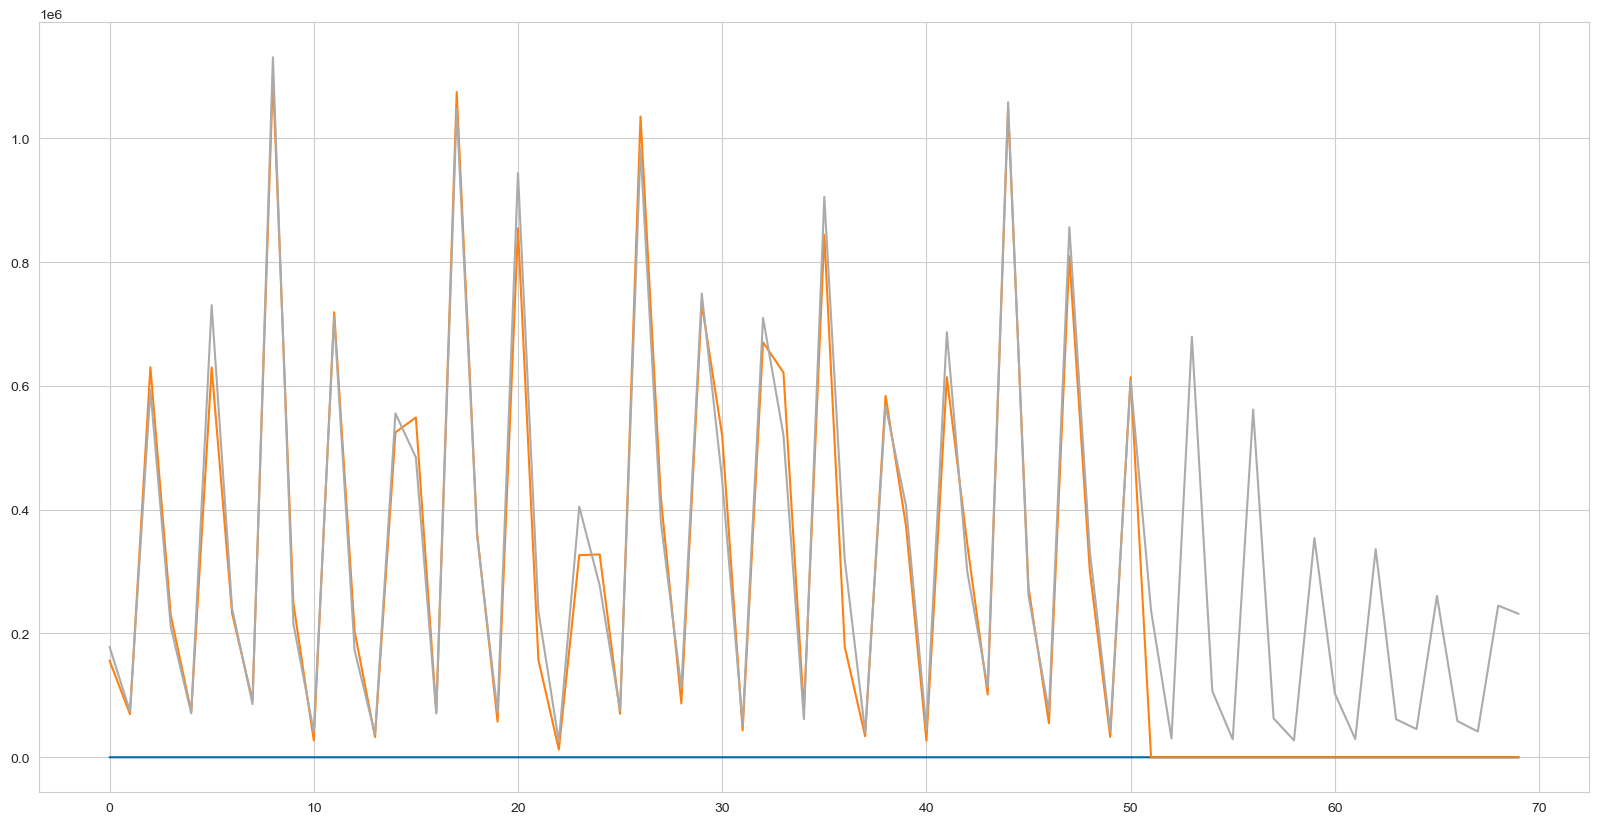

In [205]:
plt.plot(tekem)

In [206]:
df_FP1 = combined_final.copy()

In [207]:
df_FP1['periode'] = df_FP1['year'].astype(str) + "-" + df_FP1['month'].astype(str).str.zfill(2)

df_FP1.head()

Actual        Blg T-3       Blg T-2        Blg T-1  Blg Total Qty  \
0    16.0  103262.548500  134544.69801  264654.616685          48282   
1    16.0    3144.578500   35142.75483   63449.912110          36655   
2    16.0  284771.060000  459159.23280  538477.927560         280073   
3    20.0   76448.481952   54173.80114  211889.630963          58726   
4    20.0   45074.186485   42142.22154   50388.068545          36325   

     BACKLOG EUR  quarter  month  year  log_Backlog  ...   quarter_cos  \
0  304582.347680        1      1  2024    12.626700  ...  6.123234e-17   
1   85105.163640        1      1  2024    11.351655  ...  6.123234e-17   
2  589924.763120        1      1  2024    13.287752  ...  6.123234e-17   
3  250060.154319        1      2  2024    12.429461  ...  6.123234e-17   
4   51472.876855        1      2  2024    10.848830  ...  6.123234e-17   

   rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  \
0         295576.486667      -209996.38       -75148.71      -132661.33   
1          51994.436667         -985.38         7727.05        46405.86   
2         795833.456667      -197671.30      -187185.21      -111401.41   
3         251356.043333        72555.98      -137440.40        -2592.73   
4          67463.056667         3923.12         2937.74        11650.17   

   Billings EURO  predicted_Billings   REGION Material Grp 3  periode  
0      156307.68       178396.703125  AMERICA            FP1  2024-01  
1       69710.28        73958.234375     ASIA            FP1  2024-01  
2      630414.15       593564.937500   EUROPE            FP1  2024-01  
3      228863.66       210042.031250  AMERICA            FP1  2024-02  
4       73633.40        71013.664062     ASIA            FP1  2024-02  

[5 rows x 21 columns]

In [208]:
# Conversion de la colonne "periode" en type datetime
df_FP1['periode'] = pd.to_datetime(df_FP1['periode'], format='%Y-%m')
                                                                                                
df_FP1.head()

Actual        Blg T-3       Blg T-2        Blg T-1  Blg Total Qty  \
0    16.0  103262.548500  134544.69801  264654.616685          48282   
1    16.0    3144.578500   35142.75483   63449.912110          36655   
2    16.0  284771.060000  459159.23280  538477.927560         280073   
3    20.0   76448.481952   54173.80114  211889.630963          58726   
4    20.0   45074.186485   42142.22154   50388.068545          36325   

     BACKLOG EUR  quarter  month  year  log_Backlog  ...   quarter_cos  \
0  304582.347680        1      1  2024    12.626700  ...  6.123234e-17   
1   85105.163640        1      1  2024    11.351655  ...  6.123234e-17   
2  589924.763120        1      1  2024    13.287752  ...  6.123234e-17   
3  250060.154319        1      2  2024    12.429461  ...  6.123234e-17   
4   51472.876855        1      2  2024    10.848830  ...  6.123234e-17   

   rolling_mean_sales_3  sales_diff_t-1  sales_diff_t-2  sales_diff_t-3  \
0         295576.486667      -209996.38       -75148.71      -132661.33   
1          51994.436667         -985.38         7727.05        46405.86   
2         795833.456667      -197671.30      -187185.21      -111401.41   
3         251356.043333        72555.98      -137440.40        -2592.73   
4          67463.056667         3923.12         2937.74        11650.17   

   Billings EURO  predicted_Billings   REGION Material Grp 3    periode  
0      156307.68       178396.703125  AMERICA            FP1 2024-01-01  
1       69710.28        73958.234375     ASIA            FP1 2024-01-01  
2      630414.15       593564.937500   EUROPE            FP1 2024-01-01  
3      228863.66       210042.031250  AMERICA            FP1 2024-02-01  
4       73633.40        71013.664062     ASIA            FP1 2024-02-01  

[5 rows x 21 columns]

In [209]:
# Regrouper par période et sommer les valeurs
df_somme = df_FP1.groupby('periode')[['Billings EURO', 'predicted_Billings']].sum().reset_index()

# Afficher le résultat
print(df_somme)

      periode  Billings EURO  predicted_Billings
0  2024-01-01      856432.11        8.459199e+05
1  2024-02-01      932476.04        1.011600e+06
2  2024-03-01     1425435.10        1.457403e+06
3  2024-04-01      995455.24        9.677797e+05
4  2024-05-01      761201.40        7.653618e+05
5  2024-06-01     1696635.60        1.603341e+06
6  2024-07-01     1273784.88        1.373045e+06
7  2024-08-01      496447.44        6.660150e+05
8  2024-09-01     1433138.12        1.337286e+06
9  2024-10-01     1237776.44        1.239923e+06
10 2024-11-01     1233486.42        1.210118e+06
11 2024-12-01     1540406.42        1.487455e+06
12 2025-01-01      796586.36        9.272917e+05
13 2025-02-01     1014373.17        1.138026e+06
14 2025-03-01     1493749.57        1.472135e+06
15 2025-04-01     1138799.55        1.190988e+06
16 2025-05-01      948676.30        9.844316e+05
17 2025-06-01           0.00        9.468509e+05
18 2025-07-01           0.00        6.975143e+05
19 2025-08-01       

In [210]:
from IPython.display import display
display(df_somme)

periode  Billings EURO  predicted_Billings
0  2024-01-01      856432.11        8.459199e+05
1  2024-02-01      932476.04        1.011600e+06
2  2024-03-01     1425435.10        1.457403e+06
3  2024-04-01      995455.24        9.677797e+05
4  2024-05-01      761201.40        7.653618e+05
5  2024-06-01     1696635.60        1.603341e+06
6  2024-07-01     1273784.88        1.373045e+06
7  2024-08-01      496447.44        6.660150e+05
8  2024-09-01     1433138.12        1.337286e+06
9  2024-10-01     1237776.44        1.239923e+06
10 2024-11-01     1233486.42        1.210118e+06
11 2024-12-01     1540406.42        1.487455e+06
12 2025-01-01      796586.36        9.272917e+05
13 2025-02-01     1014373.17        1.138026e+06
14 2025-03-01     1493749.57        1.472135e+06
15 2025-04-01     1138799.55        1.190988e+06
16 2025-05-01      948676.30        9.844316e+05
17 2025-06-01           0.00        9.468509e+05
18 2025-07-01           0.00        6.975143e+05
19 2025-08-01           0.00        4.443223e+05
20 2025-09-01           0.00        4.688278e+05
21 2025-10-01           0.00        3.675465e+05
22 2025-11-01           0.00        3.451856e+05
23 2025-12-01           0.00        2.317638e+05

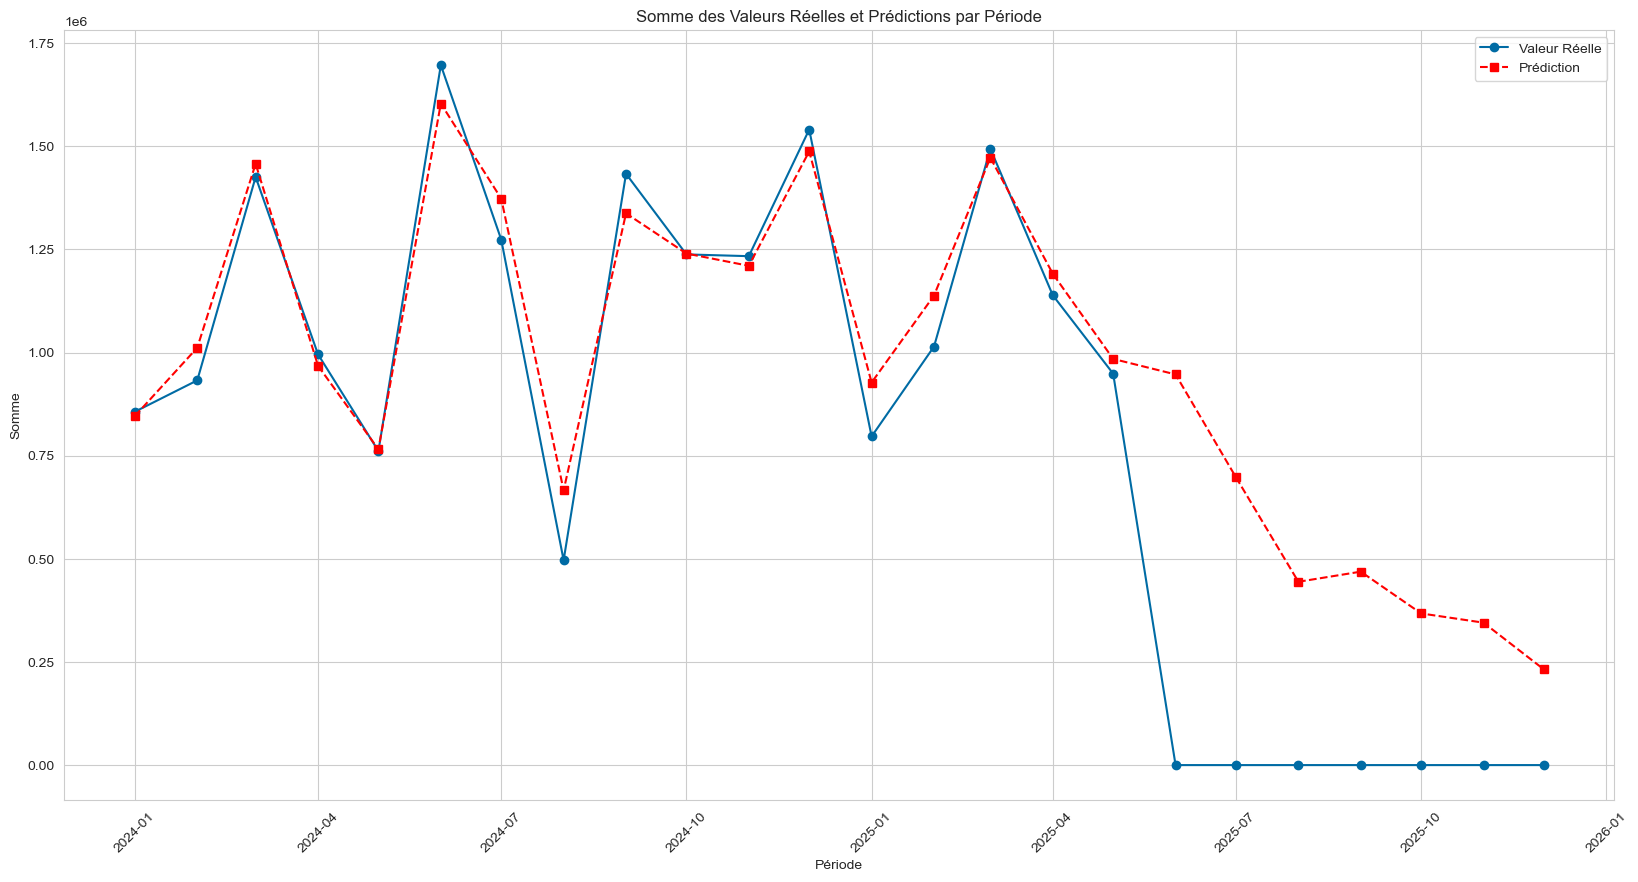

In [211]:
plt.plot(df_somme['periode'], df_somme['Billings EURO'], label='Valeur Réelle', marker='o')
plt.plot(df_somme['periode'], df_somme['predicted_Billings'], label='Prédiction', marker='s', linestyle='dashed', color='red')

plt.xlabel('Période')
plt.ylabel('Somme')
plt.title('Somme des Valeurs Réelles et Prédictions par Période')
plt.legend()
plt.xticks(rotation=45)  # Rotation des dates pour meilleure lisibilité
plt.grid(True)
plt.show()